In [1]:
import sys
#sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021/Functions')
#sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/Functions_2022')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/PaperScripts/GitHub/Functions2023')
sys.path.append('/exports/csce/datastore/geos/users/s2110831/out')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import os
import pathlib
import xarray as xr
import pandas as pd
import json
from pyasdf import ASDFDataSet
import h5py
import cmcrameri as cmm
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# Import own functions
from FCT_plotting import *
from FCT_BP_filter_loop import BP_filter
from FCT_3D_gradients import dttv, _1st_DER, _2nd_DER, ROT_2nd_DER
from FCT_laplacian import *
from FCT_WaveEquations import *
from FCT_Normal_Solution import *
from FCT_objective import *
from FCT_LinearRegression import *
from FCT_MISFIT_WaveEquations import *
from RHO_INV_matrix import *
from RHO_INV_inversion import *
from FCT_GRAD_HELMHOLTZ import *

In [5]:
#Colorbar
colors = ['ivory',"wheat",'burlywood','tab:brown']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

palette = sns.color_palette("YlGnBu", 10).as_hex()
ccc=['#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d']
YlGnBu=LinearSegmentedColormap.from_list("mycmap", ccc)

my_cmap = cmap1
mpl.rc('image', cmap=my_cmap)

## Project 

In [6]:
output = '/exports/csce/datastore/geos/users/s2110831/'

# Load an existing project.
project_name = '3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el'#'3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el'#'3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el_SAME'
event_name = "src_loc_c_isotropic_FS_src_SURF"

geometry = 'orthogonal' #OR 'parallel'

In [7]:
# Read data from file:
path_ev = str(output)+"out/"+str(project_name)+"/EVENTS/"+str(event_name)
fig_ = str(path_ev)+'/FIGURES'
para_ = str(path_ev)+'/PARAMETERS'
input_ = str(path_ev)+'/INPUT_MODELS'
output_ = str(path_ev)+'/OUTPUT_FIELDS'
data_ = str(output_)+'/DATA'
mod_ = str(fig_)+'/MODELS'
fields = fig_+str('/FIELDS')
vel_ = fields+ str('/vel')
disp_ = fields+ str('/disp')
_res =  str(fig_)+'/RESULTS'

# Data
OUT =  xr.open_dataset(output_+"/output.nc")

# Simulation Parameters
PARA = json.load( open( para_+"/_ALL.json" ) )
nx  = PARA['x_domain']
ny  = PARA['y_domain']
nz  = PARA['z_domain']
nr = int(np.sqrt(PARA['recs_surf']))
nrx = nr
nry = nr
nrz = PARA['recs_depth']
dist_r = PARA['dist_X']
nt = PARA['nt']
dt = PARA['dt']
rx0 = PARA['rec_grid_pos'][0]
ry0 = PARA['rec_grid_pos'][1]
rx1 = PARA['rec_grid_pos'][2]
ry1 = PARA['rec_grid_pos'][3]
sx  = PARA['src_loc'][0]
sy  = PARA['src_loc'][1]
sz  = abs(PARA['src_loc'][2]-nz)

# Models
ds_without_q = xr.open_dataset(str(input_)+"/ds_without_q.nc")
model_true = xr.open_dataset(str(input_)+"/model_true.nc")

#el_pos = xr.open_dataset(str(input_)+"/el_pos.nc")

# Receiver names & positions
receiver_field = xr.open_dataset(str(input_)+"/recs.nc")
rec_list = pd.DataFrame(np.array(receiver_field.location))
pd.set_option("display.max_rows", None, "display.max_columns", None)
grid = np.array([rec_list[0], rec_list[1]])

In [8]:
# Synthetic Pressure ad
VEL_Z     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))
VEL_Z_COPY     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))


### Normalization

In [9]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

normalise = 'yes'

if normalise =='yes':

                VEL_Z = normalize(VEL_Z)
    

### Position

In [10]:
# Example receiver for visualisation
# Surface Receiver position
posX = 2 
posY = 2

# Depth level 
posZ = 0 

### Spectrogram

(0.0, 30.0)

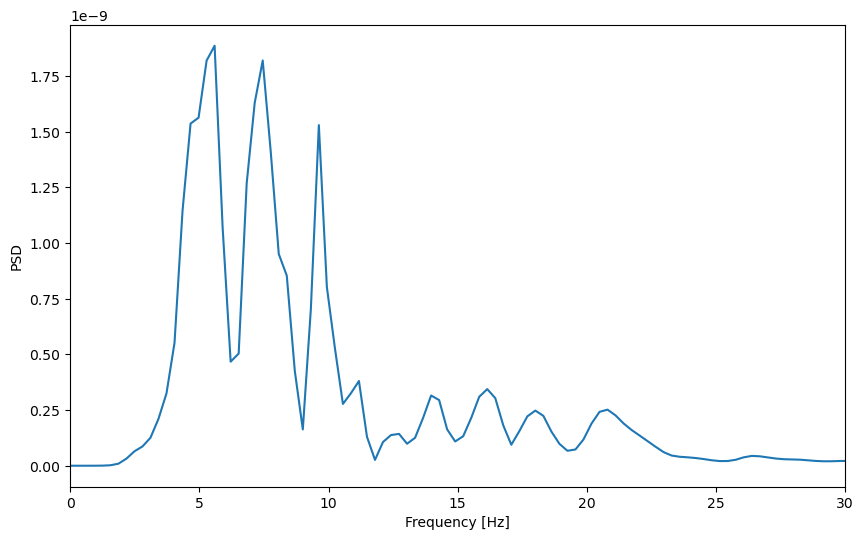

In [11]:
f, t, Sxx = signal.spectrogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'],window=('tukey', 0.1), nperseg=None, noverlap=None)
fff, Pxx = signal.periodogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'])


fig, axs = plt.subplots(figsize=(10,6))
plt.plot(fff,Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,30)

### Filtering

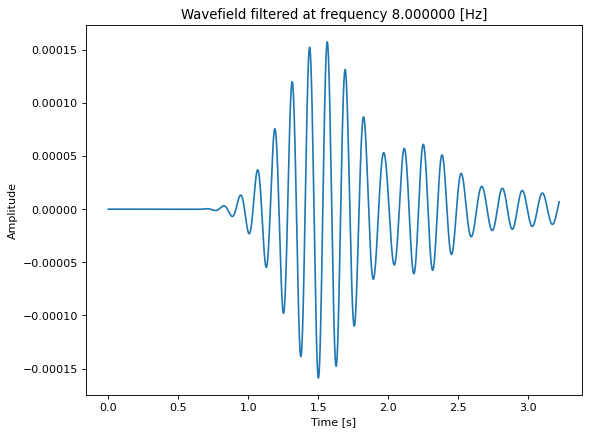

In [12]:
# Bandbass Filter
t = np.linspace(0,PARA['nt']*PARA['dt'], PARA['nt'])

nn = np.array([7])
mm = np.array([9])
f_BAND = np.array([nn,mm])


U_filt_Z = np.zeros((VEL_Z.shape[0],VEL_Z.shape[1], nrz, VEL_Z.shape[3],len(f_BAND[0,:])))

for dd in range(nrz):


        U_filterZ, f_filt_cent = BP_filter(VEL_Z[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        U_filt_Z[:,:,dd,:,:] = np.reshape(U_filterZ, (U_filt_Z[:,:,dd,:,:].shape))


nf = 0
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, U_filt_Z[posX,posY,posZ,:,nf])
plt.title('Wavefield filtered at frequency %f [Hz]' %np.round(f_filt_cent[nf],2))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show() 
    
ll = len(f_filt_cent)
    

In [13]:
AMP = np.zeros((nr,nr))

for l in range(0,nr): 
        for k in range(0,nr):

            AMP[l,k] = np.max( U_filt_Z[l,k,0,:,0])

### Subsampling

In [14]:
# Spatial Subsampling of true model
# Get velocity, density and attenuation fields at receiver points

rxx=nr
ryy=nr
rzz = nrz


Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) ).tolist()
Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) ).tolist()
Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

vp_sub_INPUT     = ds_without_q.vp.values[:,:,Rz]
vp_sub_INPUT     = vp_sub_INPUT[Rx,:,:]
vp_sub_INPUT     = np.asarray(vp_sub_INPUT[:,Ry,:])

rho_grad_INPUT   = ds_without_q.rho.values[:,:,Rz]
rho_grad_INPUT   = rho_grad_INPUT[Rx,:,:]
rho_grad_INPUT   = np.asarray(rho_grad_INPUT[:,Ry,:])

vp_sub     = model_true.VP[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
vp_sub     = vp_sub[Rx,:,:]
vp_sub     = np.asarray(vp_sub[:,Ry,:])

rho_grad   = model_true.RHO[:,:,Rz].values #ds_without_q.rho.values[:,:,Rz]
rho_grad   = rho_grad[Rx,:,:]
rho_grad   = np.asarray(rho_grad[:,Ry,:])


c_sub      = vp_sub 


In [15]:
# Potential temporal subsampling
sub= 20         
nt_sub = np.ceil(PARA['nt']/sub).astype(int) 
dt_sub = sub* PARA['dt']
t_sub  = np.linspace(0,nt_sub*dt_sub, nt_sub)

#Potential spatial sampling
dx = PARA['dist_X']
dy = PARA['dist_Y']
dz = PARA['dist_Z']

sub_spXY = 2
dx = dx*sub_spXY
dy = dy*sub_spXY
sub_spZ  = 1
dz = dz*sub_spZ
dist_r=dist_r*sub_spXY
nr  = int(nr/sub_spXY)
rxx = int(rxx/sub_spXY)
ryy = int(ryy/sub_spXY)
nrz = int(nrz/sub_spZ)
rzz = int(rzz/sub_spZ)

nrx = rxx
nry = ryy
nrz = rzz

u_field_Z =   U_filt_Z[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]
   

vp_subTRUE = vp_sub[:,:,:]   
rho_gradTRUE = rho_grad[:,:,:]
vp_sub = vp_sub[::sub_spXY,::sub_spXY,::sub_spZ]
#vs_sub = vs_sub[::sub_spXY,::sub_spXY,::sub_spZ]
rho_grad = rho_grad[::sub_spXY,::sub_spXY,::sub_spZ]

vp_sub_INPUT = vp_sub_INPUT[::sub_spXY,::sub_spXY,::sub_spZ]
#vs_sub = vs_sub[::sub_spXY,::sub_spXY,::sub_spZ]
rho_grad_INPUT = rho_grad_INPUT[::sub_spXY,::sub_spXY,::sub_spZ]

AMP = AMP[::sub_spXY,::sub_spXY]
#Pxx = Pxx[:,::sub_spXY,::sub_spXY]

c_sub=vp_sub

## Gradient Calculation

### Temporal

In [16]:
N =  nr**2 * nrz 
VEL_Z = np.reshape(u_field_Z[:,:,:,:,:], (N,nt_sub,u_field_Z[:,:,:,:,:].shape[4]))

In [17]:
# Temporal derivatives, order options: 2, 4, 8
order = 2
dttv1, dttv2, dttv3 = dttv(VEL_Z, VEL_Z, VEL_Z, dt_sub, nt_sub, order)

In [18]:
dttv1 = np.reshape(dttv1, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))
dttv2 = np.reshape(dttv2, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))
dttv3 = np.reshape(dttv3, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))

### Spatial

(via Classical FD stencil)
- #### cross-shaped, regular grid

In [19]:
VEL_Z = np.reshape(VEL_Z, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))

In [20]:
# First Order derivatives
order = 2 # second order accurate

VEL_X_gradX, VEL_Y_gradX, VEL_Z_gradX, VEL_X_gradY, VEL_Y_gradY, VEL_Z_gradY, VEL_X_gradZ, VEL_Y_gradZ, VEL_Z_gradZ \
= _1st_DER(VEL_Z, VEL_Z, VEL_Z, dx, dy, dz, nrx, nry, nrz, order)

In [21]:
# Second Order derivatives
order = 2 # second order accurate

VEL_X_gradXX, VEL_Y_gradXX, VEL_Z_gradXX, VEL_X_gradYY, VEL_Y_gradYY, VEL_Z_gradYY, VEL_X_gradZZ,\
VEL_Y_gradZZ, VEL_Z_gradZZ, VEL_X_gradXY, VEL_Y_gradXY, VEL_Z_gradXY, VEL_X_gradYX, VEL_Y_gradYX,\
VEL_Z_gradYX, VEL_X_gradYZ, VEL_Y_gradYZ, VEL_Z_gradYZ, VEL_X_gradXZ, VEL_Y_gradXZ, VEL_Z_gradXZ \
= _2nd_DER(VEL_Z, VEL_Z, VEL_Z, dx, dy, dz, nrx, nry, nrz, order)

- ### 2D Helmholtz Acoustic Wave Equation


In [22]:
a=0#1
b=nt_sub#nt_sub-1

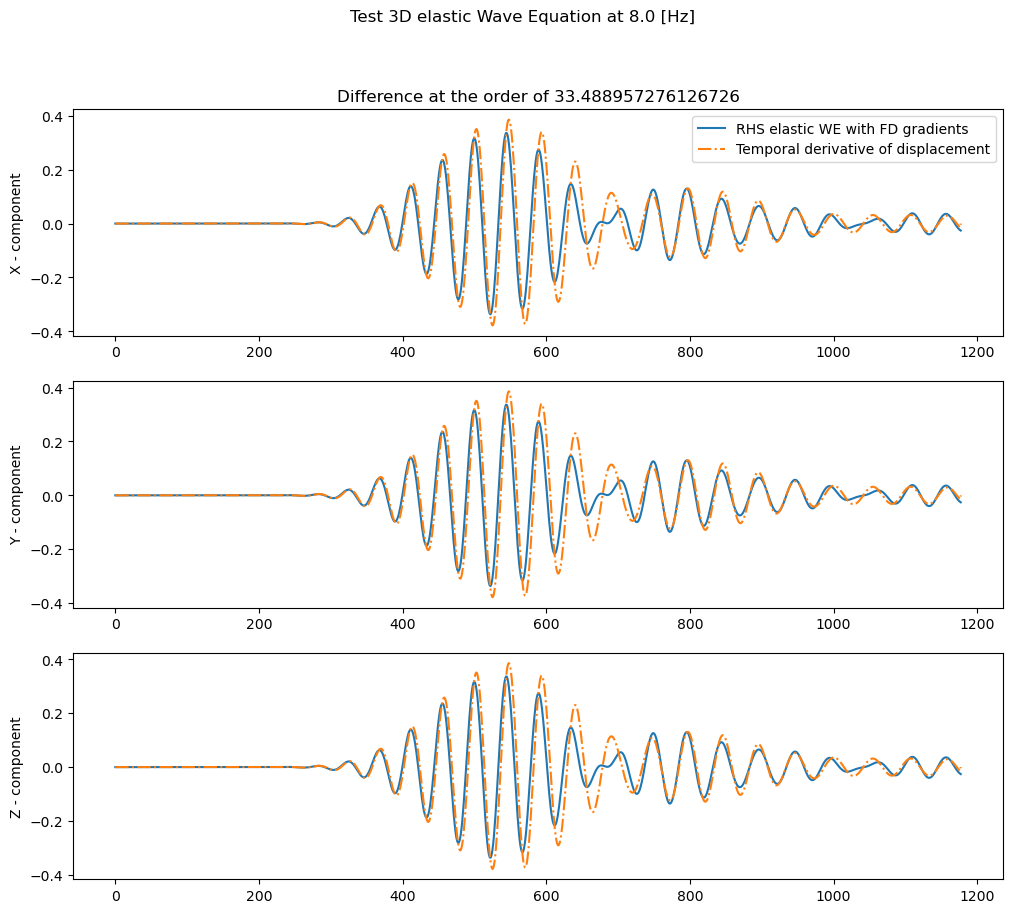

In [23]:
filtered='yes'
acc1_2D,acc2_2D,acc3_2D = WE_2D_ACOUSTIC(VEL_X_gradXX[:,:,:,a:b,:], VEL_Y_gradXX[:,:,:,a:b,:], VEL_Z_gradXX[:,:,:,a:b,:], VEL_X_gradYY[:,:,:,a:b,:], VEL_Y_gradYY[:,:,:,a:b,:], VEL_Z_gradYY[:,:,:,a:b,:], VEL_X_gradZZ[:,:,:,a:b,:],\
VEL_Y_gradZZ[:,:,:,a:b,:], VEL_Z_gradZZ[:,:,:,a:b,:], VEL_X_gradXY[:,:,:,a:b,:], VEL_Y_gradXY[:,:,:,a:b,:], VEL_Z_gradXY[:,:,:,a:b,:], VEL_X_gradYX[:,:,:,a:b,:], VEL_Y_gradYX[:,:,:,a:b,:],\
VEL_Z_gradYX[:,:,:,a:b,:], VEL_X_gradYZ[:,:,:,a:b,:], VEL_Y_gradYZ[:,:,:,a:b,:], VEL_Z_gradYZ[:,:,:,a:b,:], VEL_X_gradXZ[:,:,:,a:b,:], VEL_Y_gradXZ[:,:,:,a:b,:], VEL_Z_gradXZ[:,:,:,a:b,:], vp_sub, c_sub,\
dttv1[:,:,:,a:b,:], dttv2[:,:,:,a:b,:], dttv3[:,:,:,a:b,:], posX,posY, posZ, nf, f_filt_cent, filtered)

In [24]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [25]:
centx = 12
centy = 12
step1=0
step2=nt_sub

# Gradient of central station
fig,axs=plt.subplots(figsize=(24,24),nrows=3)
axs[0].scatter(t_sub[step1:step2], VEL_Z[centx,centy,0,step1:step2], s=1, color='darkgrey')
axs[1].scatter(t_sub[step1:step2], acc3_2D[centx,centy,0,step1:step2,0], s=1, color='darkgrey')
axs[2].scatter(t_sub[step1:step2], dttv3[centx,centy,0,step1:step2,0], s=1,color='darkgrey')
axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)
axs[2].xaxis.set_tick_params(labelsize=20)
axs[2].yaxis.set_tick_params(labelsize=20)
axs[0].set_xlabel('Time [s]',fontsize=24)
axs[1].set_xlabel('Time [s]',fontsize=24)
axs[2].set_xlabel('Time [s]',fontsize=24)
axs[0].set_ylabel('Pressure Wavefield',fontsize=24)
axs[1].set_ylabel('Spatial Gradient',fontsize=24)
axs[2].set_ylabel('Temporal Gradient',fontsize=24)
axs[1].set_xlim(t_sub[step1],t_sub[step2-1])
axs[2].set_xlim(t_sub[step1],t_sub[step2-1])

(0.0, 3.2238581250773364)

In [26]:
ordd=0
nt_range = b-a
comp = 'Z'
c_phase_Z_2D, mZ_2D, r_sq_Z_2D = LinReg_c(acc3_2D[:,:,:,:,:],dttv3[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz,ordd)

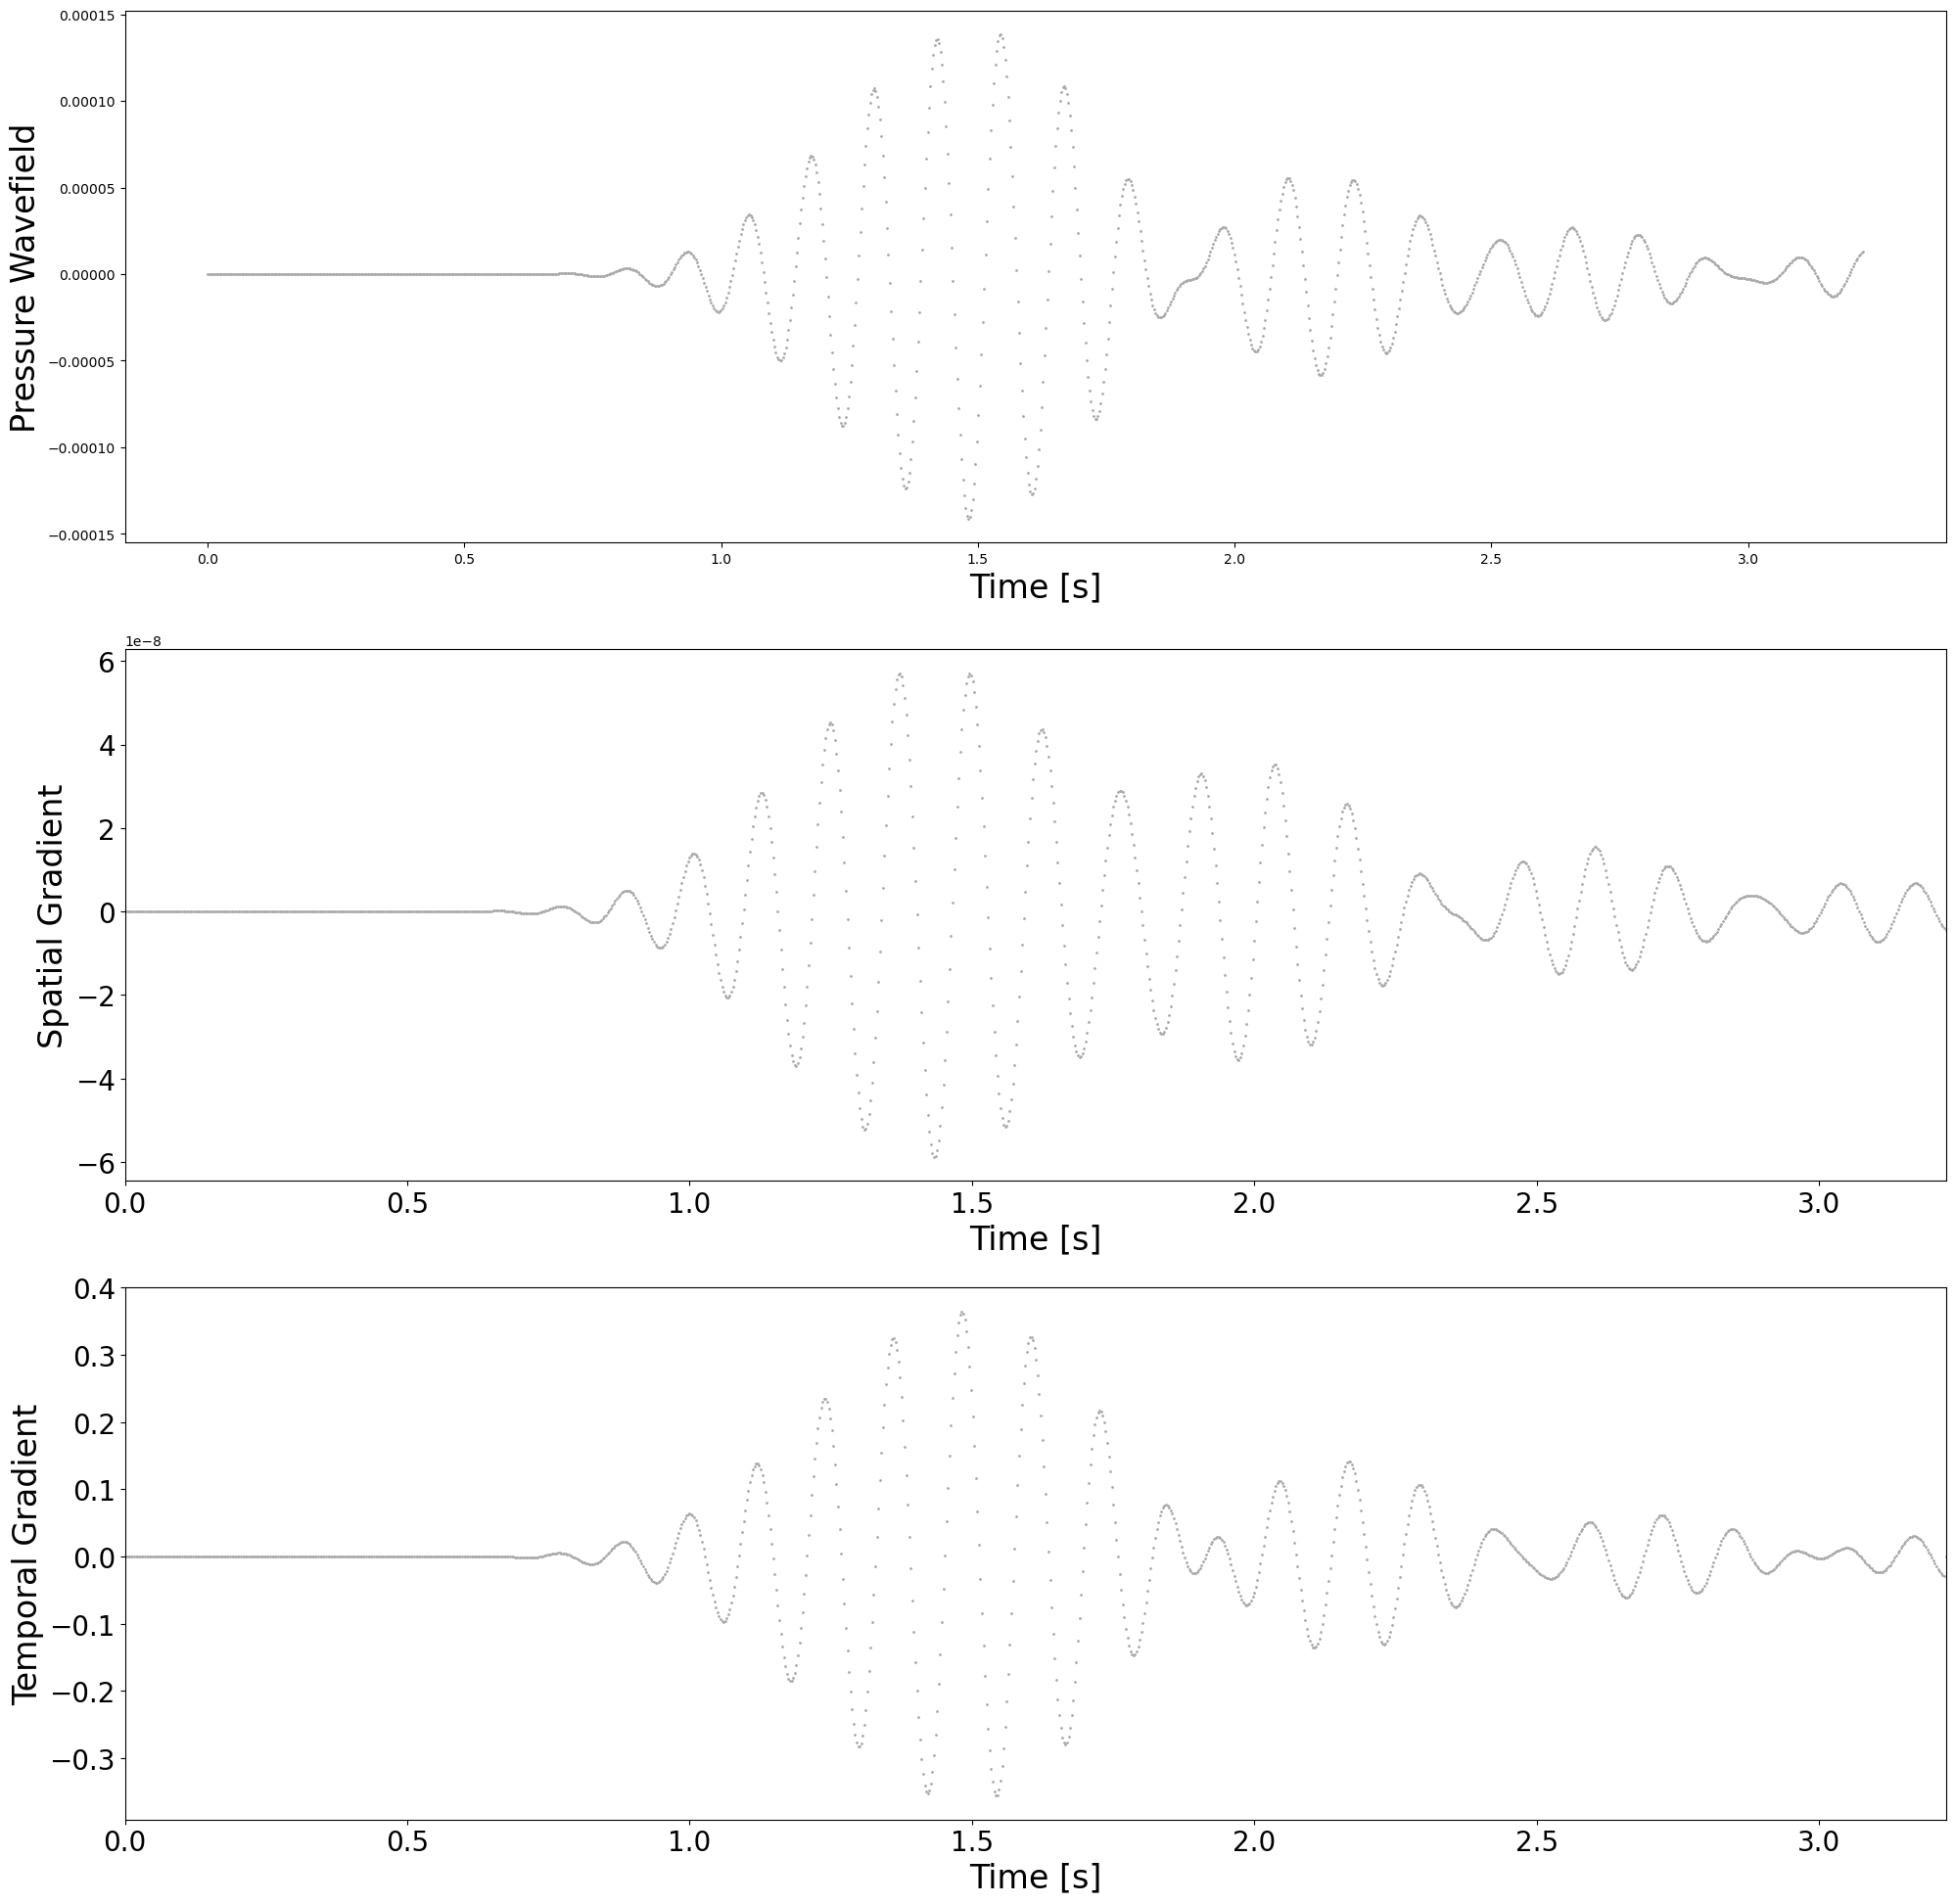

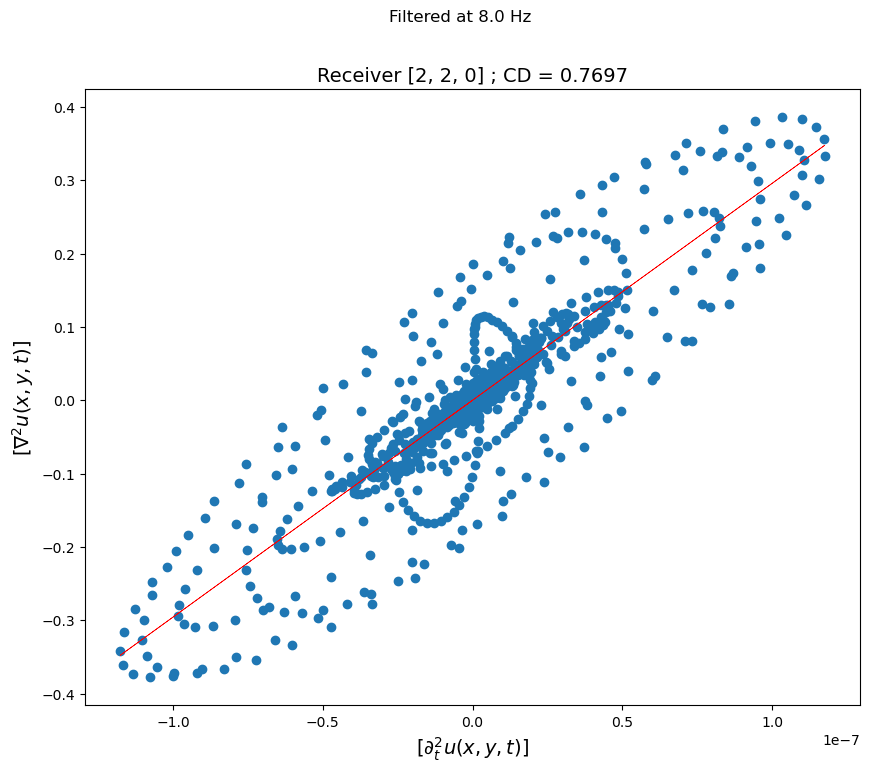

In [27]:
comp = 'Z'
if comp == 'X':
    LinReg_PLOT(acc1_2D[:,:,:,:,:], dttv1[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz, posX, posY, posZ, nf, mX_2D, r_sq_X_2D, f_filt_cent, filtered)
elif comp == 'Y':
    LinReg_PLOT(acc2_2D[:,:,:,:,:], dttv2[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz, posX, posY, posZ, nf, mY_2D, r_sq_Y_2D, f_filt_cent, filtered)
elif comp == 'Z':
    LinReg_PLOT(acc3_2D[:,:,:,:,:], dttv3[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz, posX, posY, posZ, nf, mZ_2D, r_sq_Z_2D, f_filt_cent, filtered)

In [28]:
fig = plt.figure(figsize=(8,6))
plt.title('Coefficient of Determination (f=%d [Hz])' %f_filt_cent[nf], size=20)     
im=plt.imshow( r_sq_Z_2D[1:-1,1:-1,posZ,nf] ,  aspect='auto', interpolation='none', origin='lower', extent=[1,18,1,18], cmap=YlGnBu ) #,extent=[-3, 3, -3, 3]
cb=plt.colorbar(im)
cb.set_label(label=r'CDI', size=16)
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14  
plt.xlabel('X-Axis [m]', fontsize=14)
plt.ylabel('Y-Axis [m]', fontsize=14)
#plt.savefig(str(fig_)+'/2DHELM_'+str(round(f_filt_cent[0])))


Text(0, 0.5, 'Y-Axis [m]')

In [29]:
c_phase = c_phase_Z_2D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.title('Helmholtz velocity',fontsize=16)
plt.title('Estimated Velocity - Helmholtz WE (f=%d [Hz])' %f_filt_cent[nf], size=16) 

im2=plt.imshow(c_phase_Z_2D[1:-1,1:-1,0,0] ,vmin=np.min(c_phase_Z_2D[1:-1,1:-1,0,0]), vmax=np.max(c_phase_Z_2D[1:-1,1:-1,0,0]), aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label='[m/s]',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
for t in cbar.ax.get_xticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xticks([1,3,5,7,9,11,13,15,17])
ax.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax.set_yticks([1,3,5,7,9,11,13,15,17])
ax.set_yticklabels(['2','4','6','8','10','12','14','16','18'])


[Text(0, 1, '2'),
 Text(0, 3, '4'),
 Text(0, 5, '6'),
 Text(0, 7, '8'),
 Text(0, 9, '10'),
 Text(0, 11, '12'),
 Text(0, 13, '14'),
 Text(0, 15, '16'),
 Text(0, 17, '18')]

## RHO Inversion

In [30]:
N = nrx**2 
NN        = (nrx-order)**2 
ww_corner   = 1e-20 
ww_BC       = 1e-20 
ww_internal = 1


input_field = VEL_Z
time_field = dttv3
ntt =  nt_range
M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)


In [31]:
###################
#GRADIOMETRY - CONSTANT DENSITY
###################

U_LAPLACE_CST, Utt_LAPLACE_CST, prod , Dxx_CST = GRAD_LAPLACE_CST(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, order, f_filt_cent)

In [32]:
###################
#GRADIOMETRY - VARIABLE DENSITY
################### 
rho_gradd=rho_grad[:,:,:]
rho_m_sub = rho_gradd[:,:,0]#.values
U_LAPLACE_VAR_true, Utt_LAPLACE_VAR_true, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], nt_sub, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)
plt.title('Helmholtz vs. TRUE Full Acoustic')
plt.scatter(U_LAPLACE_CST[posX,posY,1:-1],Utt_LAPLACE_CST[posX,posY,1:-1])
plt.scatter(U_LAPLACE_VAR_true[posX,posY,1:-1],Utt_LAPLACE_VAR_true[posX,posY,1:-1])


In [33]:
c_phase_VAR_true, mZ_VAR_true, r_sq_VAR_true = LinReg_c2(U_LAPLACE_VAR_true[:,:,1:-1,:],Utt_LAPLACE_VAR_true[:,:,1:-1,:], nt_range-2, ll, N, nr, nr, nrz,ordd)
plt.imshow(c_phase_VAR_true[1:-1,1:-1], origin='lower', cmap='YlGnBu')
plt.colorbar()

c_diff_VAR_true = 100*(c_phase_VAR_true[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
c_difff_VAR_true = (c_phase_VAR_true[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
c_RMS_VAR_true  = np.sqrt((1/(nr-2)**2)*c_difff_VAR_true[1:-1,1:-1].sum(0).sum(0))

In [34]:
# Initial density model guess

comp ='Z'
m_init0 =  np.ones(rho_gradd[:,:,0].shape)*np.mean(rho_gradd[:,:,0])
m_init =  np.ones(rho_gradd[:,:,0].shape)*np.mean(rho_gradd[:,:,0])#np.ones(rho_gradd[:,:,0].shape)*np.mean(rho_gradd[:,:,0])#rho_grad[:,:,0]#np.ones(rho_grad[:,:,0].shape)*np.mean(rho_grad[:,:,0])#rho_grad[:,:,0] #np.ones(rho_grad[:,:,0].shape)*np.mean(rho_grad[:,:,0])#.values # rho_grad[:,:,0] #np.ones(rho_grad[:,:,0].shape) *2000# np.mean(rho_grad) 
c_input = c_phase_Z_2D[:,:,0,0]+1e-5#c_sub[:,:,0]

In [35]:
c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
#Store c_RMS & difff
c_RMS_all_store = []
c_RMS_singleST_store = []
c_misfit = []

c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)
c_misfit = np.append(c_misfit, c_diff)

#rho_input = rho_grad[:,:,0]
rho_true = np.asarray(rho_gradd[:,:,0])

In [36]:
############################################################################################# 
#  Inversion
#############################################################################################
# number of iterations
n_it = 0

NNN = (nrx-2)*(nry-2)
# plot model parameters Number: begin to stop
begin = 30
stop = 60
test = 'false'
a_s        = 0.1 *np.mean(AMP)*np.ones((AMP.shape)) #10 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) ##0.001 0.01 *AMP #0.01 *AMP #1000# 500#10
rho_inv1, rr, misfit, RMS, difff, mis =  rho_inverse0(rho_true, c_input, m_init, nt_sub, N, dist_r, time_field[:,:,0,a:b,0],WW, M_l, nr, begin, stop, test, a_s, n_it)
print('Misfit inversion output and true model:',misfit)

#Store rho_inv data
store=[]
store = np.append(store, rho_inv1)

n_it = n_it + 1

#Store RMS & difff
RMS_all_store = []
RMS_all_store = np.append(RMS_all_store, RMS)
RMS_singleST_store = []
RMS_singleST_store = np.append(RMS_singleST_store, difff)

maxMIS = np.max((mis[1:-1,1:-1]))
minMIS = np.min((mis[1:-1,1:-1]))

print('mean parameter error'+str(np.mean(mis)))

RMS: 287.15305460023285
Misfit inversion output and true model: -14.681963077041821
mean parameter error3.2866993382733565


In [37]:
rho_m_sub = rho_inv1

U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)

#Store gradients
Usp_VAR_store = []
Usp_VAR_store = np.append(Usp_VAR_store, U_LAPLACE_VAR)
Utt_VAR_store = []
Utt_VAR_store = np.append(Utt_VAR_store, Utt_LAPLACE_VAR)

In [38]:
c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], ntt-2, ll, N, nrx, nry, nrz,ordd)

#Store phase velocity
c_VAR_store = []
c_VAR_store = np.append(c_VAR_store, c_phase_new)
c_coeffdet = []
c_coeffdet = np.append(c_coeffdet, r_sq_new)

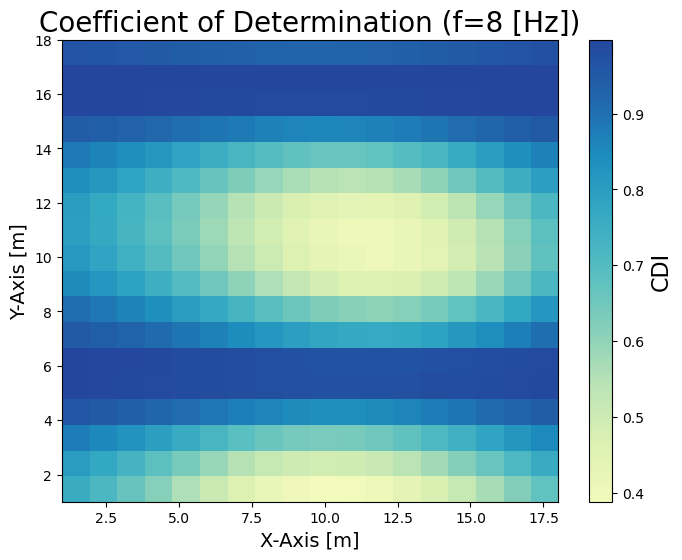

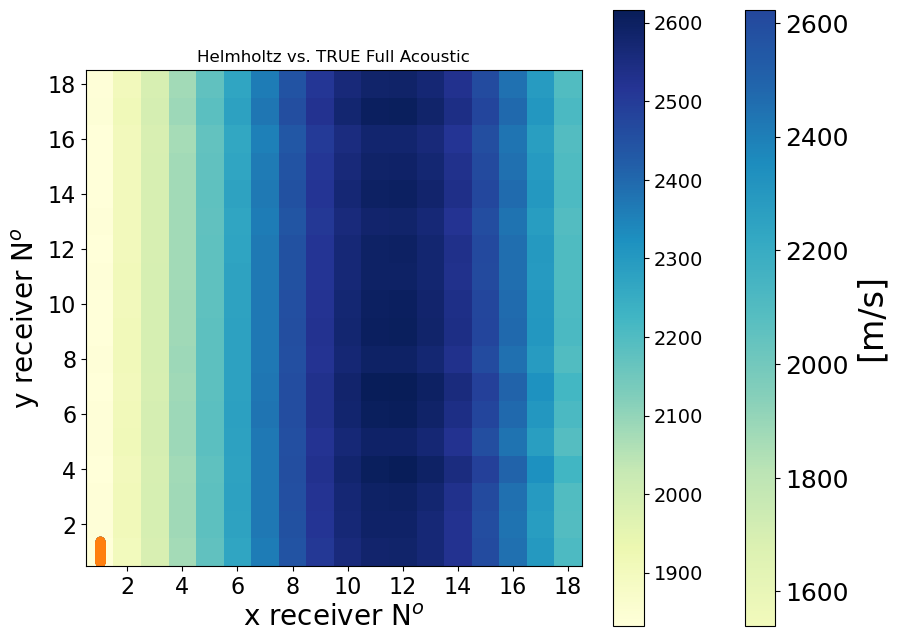

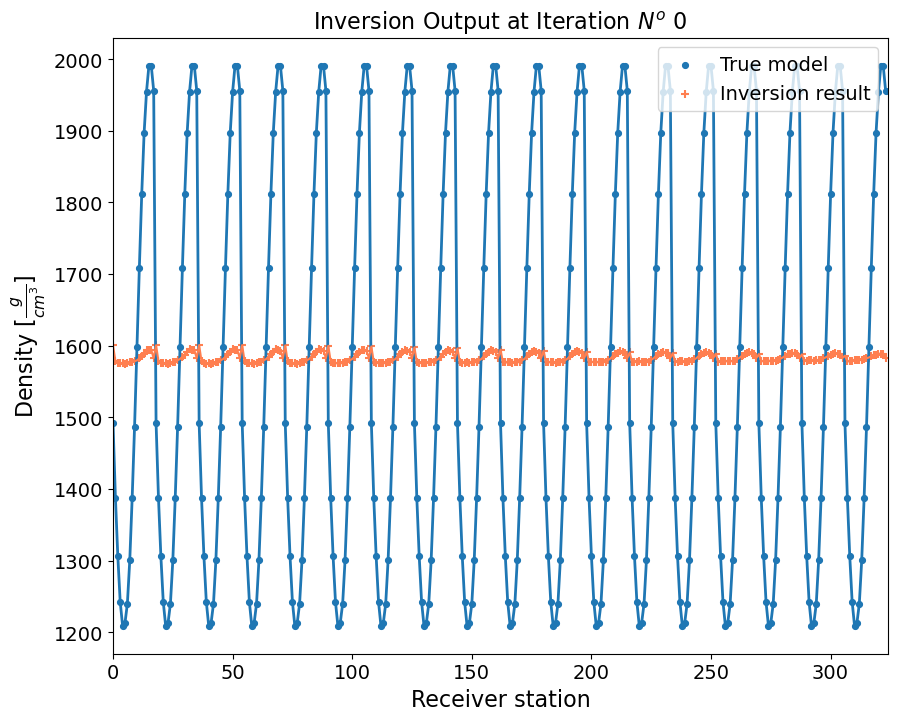

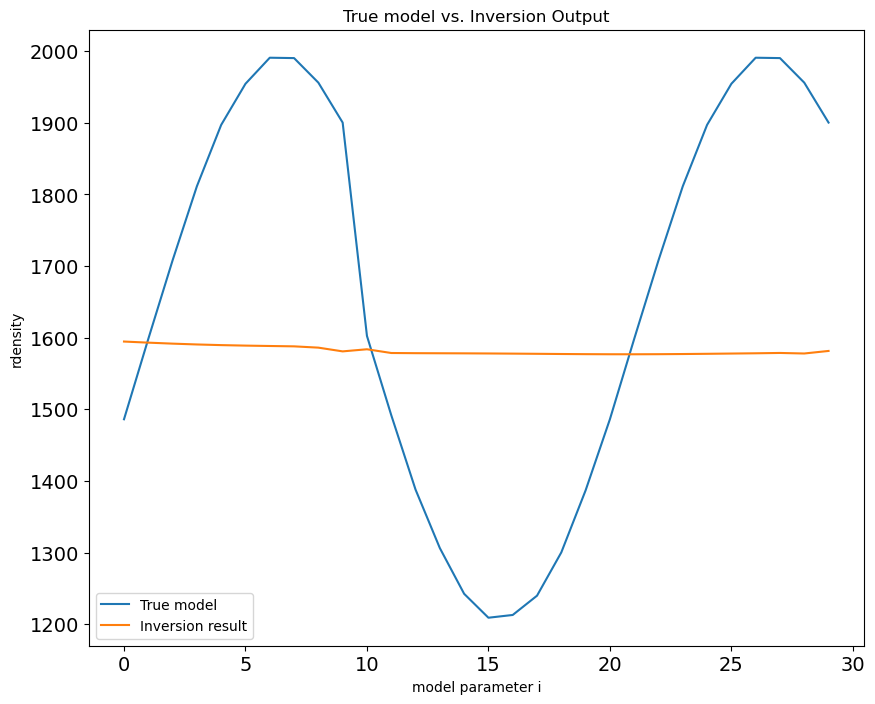

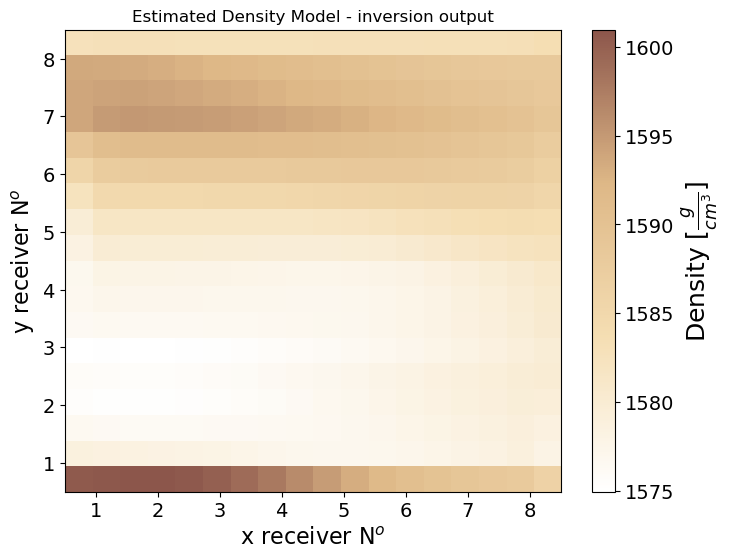

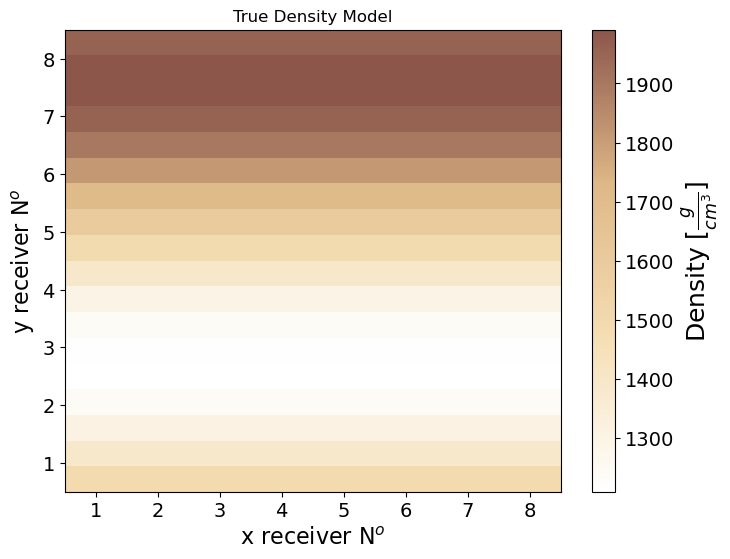

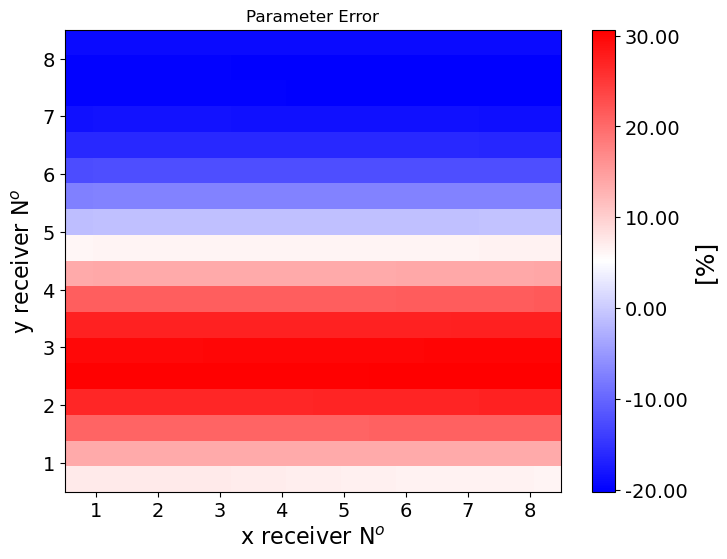

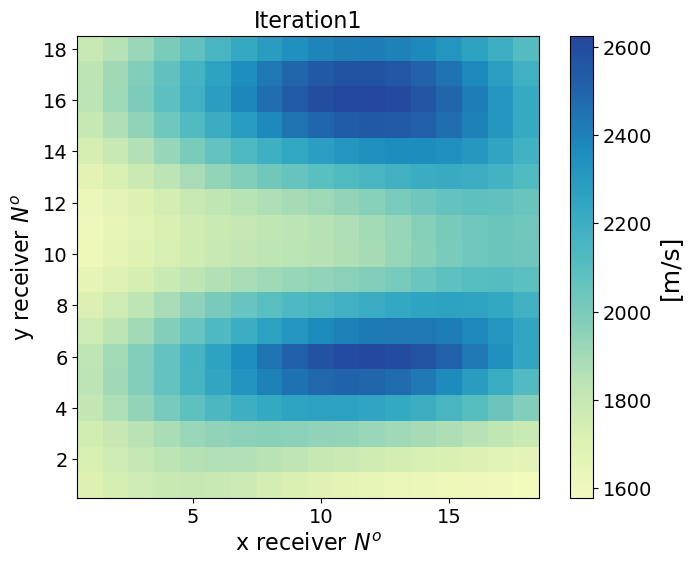

In [39]:
fig = plt.figure(figsize=(8,6))
plt.title('Iteration'+str(n_it),fontsize=16)
im=plt.imshow(c_phase_new[1:-1,1:-1], origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5],cmap=YlGnBu )#,vmin=np.min(c_sub[1:-1,1:-1,0]), vmax=np.max(c_sub[1:-1,1:-1,0]), aspect='auto', interpolation='none')
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im, format='%.0f')
cbar.set_label(label='[m/s]',size=18)
plt.xlabel(r'x receiver $N^{o}$',fontsize=16)
plt.ylabel(r'y receiver $N^{o}$',fontsize=16)
plt.show()

In [40]:
# Initial density model guess

m_init = rho_inv1    #*np.mean(rho_grad) 
c_input = c_phase_new[:,:,0]
#rho_true = np.asarray(rho_gradd[:,:,0])

c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
#Store c_RMS & difff
c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)
c_misfit = np.append(c_misfit, c_diff)


# Weighting
ww_corner   = 1e-15#1e-10#30
ww_BC       = 1e-15#1e-10#20#1e-30 #0.0000001
ww_internal = 1#0.2#0.1#1e-10

M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)

############################################################################################# 
#  Inversion
#############################################################################################
# plot model parameters Number: begin to stop
begin = 30
stop = 60
test = 'false'
a_s        = 0.01 *np.mean(AMP)*np.ones((AMP.shape)) #0.05 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) ##0.001 #0.001 *np.mean(AMP)*np.ones((AMP.shape)) #0.01*AMP # 0.001*AMP #100#10
rho_inv2, rr, misfit, RMS, difff, mis = rho_inverse(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,a:b,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)
print('Misfit inversion output and true model:',misfit)
store = np.append(store, rho_inv2)
n_it = n_it + 1

#Store RMS & difff
RMS_all_store = []
RMS_all_store = np.append(RMS_all_store, RMS)
RMS_singleST_store = []
RMS_singleST_store = np.append(RMS_singleST_store, difff)

print('mean parameter error'+str(np.mean(mis)))

RMS: 152.63118451435037
Misfit inversion output and true model: 11.912619480442943
mean parameter error0.4184178530748693


In [41]:
rho_m_sub = rho_inv2

U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)
#comp = 'X'
c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], ntt-2, ll, N, nrx, nry, nrz,ordd)
#LinReg_PLOT(U_LAPLACE_VAR[:,:,:,:],Utt_LAPLACE_VAR[:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz, posX, posY, posZ, nf, mZ_2D, r_sq_Z_2D, f_filt_cent, filtered)

#Store gradients
Usp_VAR_store = np.append(Usp_VAR_store, U_LAPLACE_VAR)
Utt_VAR_store = np.append(Utt_VAR_store, Utt_LAPLACE_VAR)
#Store phase velocity
c_VAR_store = np.append(c_VAR_store, c_phase_new)
c_coeffdet = np.append(c_coeffdet, r_sq_new)

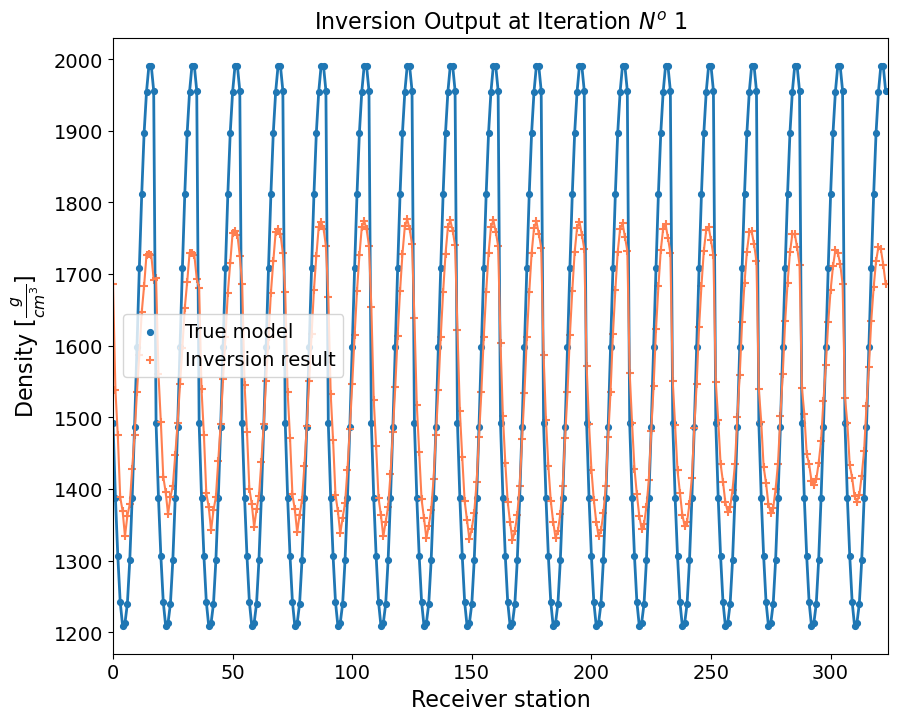

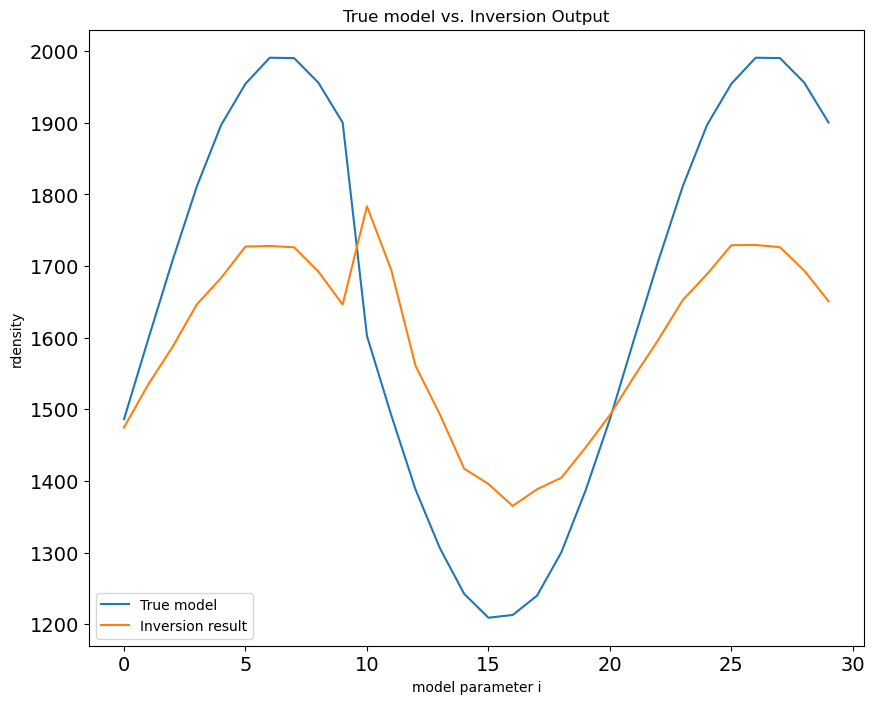

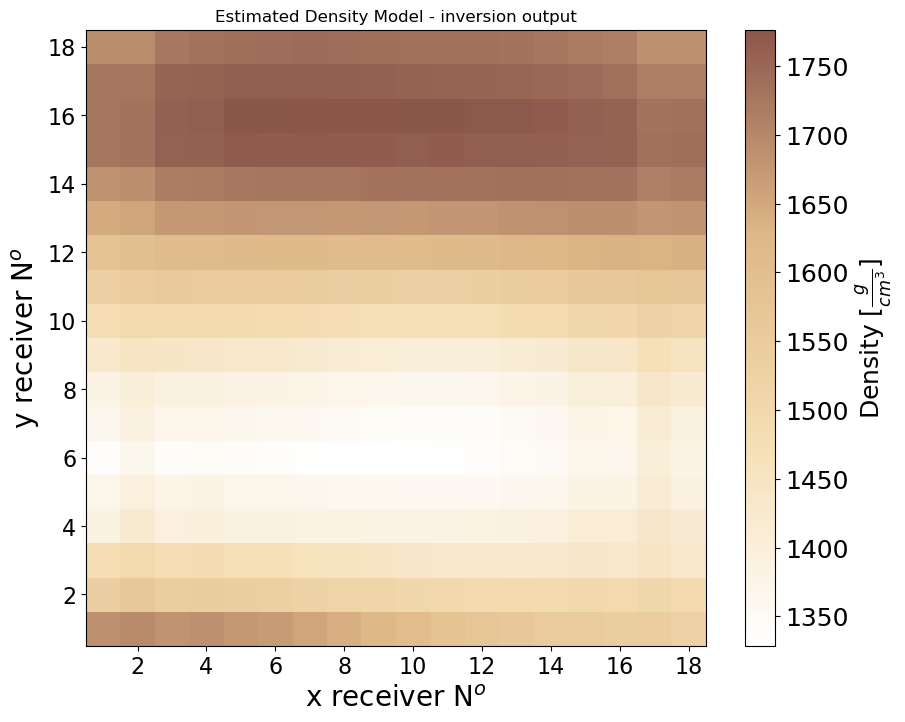

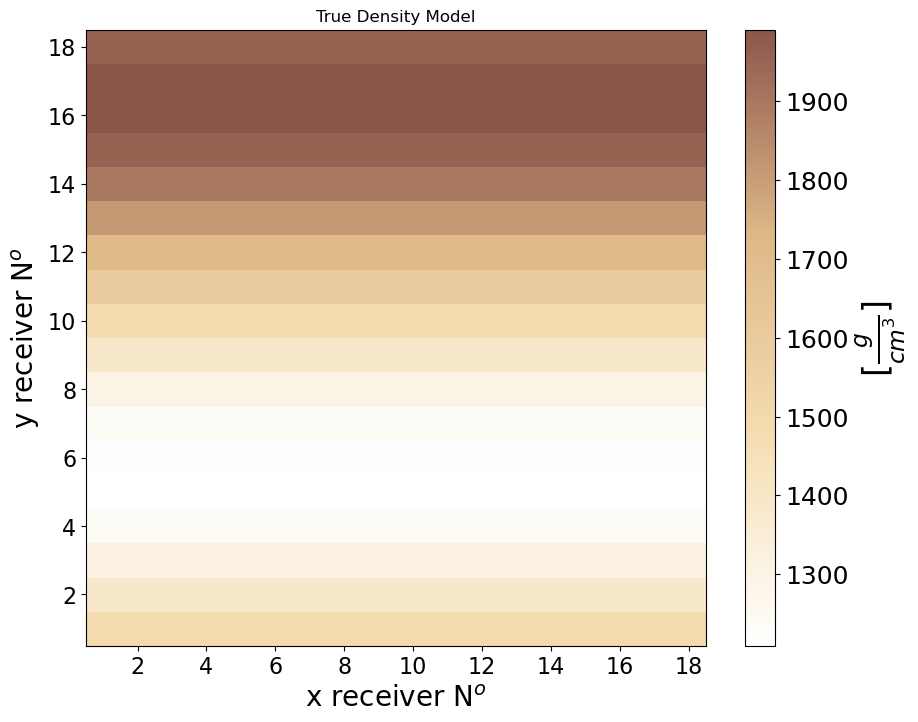

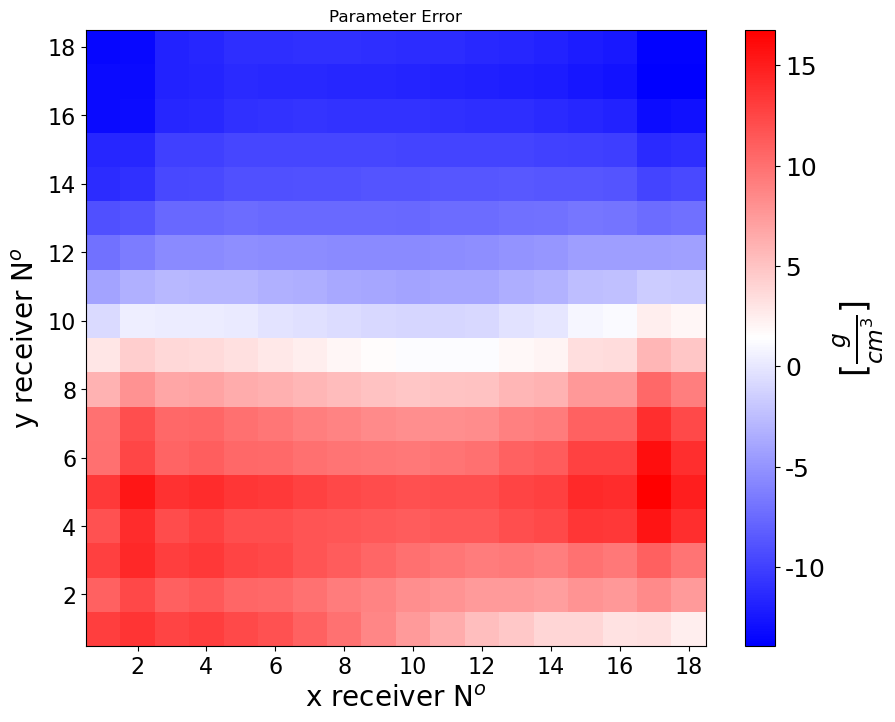

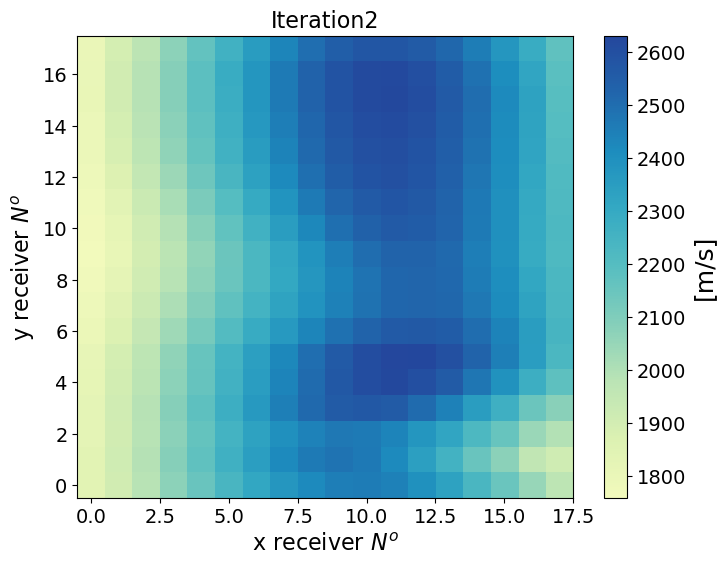

In [42]:
fig = plt.figure(figsize=(8,6))
plt.title('Iteration'+str(n_it),fontsize=16)

im=plt.imshow(c_phase_new[1:-1,1:-1] ,vmin=np.min(c_phase_new[1:-1,1:-1]), vmax=np.max(c_phase_new[1:-1,1:-1]), aspect='auto', interpolation='none', cmap=YlGnBu ,origin='lower') #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im, format='%.0f')
cbar.set_label(label='[m/s]',size=18)
plt.xlabel(r'x receiver $N^{o}$',fontsize=16)
plt.ylabel(r'y receiver $N^{o}$',fontsize=16)

plt.show() 

In [43]:
# Initial density model guess

m_init = rho_inv2    #*np.mean(rho_grad) 
c_input = c_phase_new[:,:,0]+1e-5
#rho_true = np.asarray(rho_gradd[:,:,0])

c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
#Store c_RMS & difff
c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)
c_misfit = np.append(c_misfit, c_diff)

# Weighting
ww_corner   = 1e-15#1e-10#30
ww_BC       = 1e-15#1e-10#20#1e-30 #0.0000001
ww_internal = 1#1e-5#0.5

M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)

############################################################################################# 
#  Inversion
#############################################################################################
# plot model parameters Number: begin to stop
begin = 30
stop = 60
test = 'false'
a_s        = 0.01 *np.mean(AMP)*np.ones((AMP.shape)) #1 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) #0.001 *np.mean(AMP)*np.ones((AMP.shape)) #0.01*AMP# 0.001*AMP #100#10
rho_inv2, rr, misfit, RMS, difff,mis = rho_inverse(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,a:b,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)
print('Misfit inversion output and true model:',misfit)
store = np.append(store, rho_inv2)
n_it = n_it + 1

#Store RMS & difff
RMS_all_store = np.append(RMS_all_store, RMS)
RMS_singleST_store = np.append(RMS_singleST_store, difff)

print('mean parameter error'+str(np.mean(mis)))

RMS: 93.31838317794444
Misfit inversion output and true model: 3.2643345362817167
mean parameter error0.5081159745210817


In [44]:
rho_inv22 = rho_inv2

In [45]:
# Initial density model guess
for i in range(0,10): #5
    
    
    rho_m_sub = rho_inv22

    U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)
    #comp = 'X'
    plt.scatter(U_LAPLACE_VAR[posX,posY],Utt_LAPLACE_VAR[posX,posY])

    c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], ntt-2, ll, N, nrx, nry, nrz,ordd)
    
    fig,ax = plt.subplots(figsize=(10,8))
    plt.title('Iteration'+str(n_it),fontsize=16)
    im=plt.imshow(c_phase_new[1:-1,1:-1],vmax=np.max(c_phase_new[1:-1,1:-1]), aspect='auto', interpolation='none', cmap=YlGnBu ,origin='lower',extent=[0.5,nr-2+0.5,0.5,nr-2+0.5]) #,extent=[-3, 3, -3, 3]
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im, format='%.0f')
    cbar.set_label(label='[m/s]',size=24)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
    plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
    plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    #plt.show() 
    
    #Store gradients
    Usp_VAR_store = np.append(Usp_VAR_store, U_LAPLACE_VAR)
    Utt_VAR_store = np.append(Utt_VAR_store, Utt_LAPLACE_VAR)
    #Store phase velocity
    c_VAR_store = np.append(c_VAR_store, c_phase_new)
    c_coeffdet = np.append(c_coeffdet, r_sq_new)
    c_misfit = np.append(c_misfit, c_diff)
    
    
    m_init = rho_inv22    #*np.mean(rho_grad) 
    c_input = c_phase_new[:,:,0]+1e-5
    #rho_true = np.asarray(rho_gradd[:,:,0])
    
    c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
    c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
    c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
    #Store c_RMS & difff
    c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
    c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)
    

    # Weighting
    ww_corner   = 1e-15#1e-10#40 #-30
    ww_BC       = 1e-15#1e-10#30 #-20 #1e-30 #0.0000001
    ww_internal = 1#0.8#0.1#1e-2#0.7

    M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)

    ############################################################################################# 
    #  Inversion
    #############################################################################################
    # plot model parameters Number: begin to stop
    begin = 30
    stop = 60
    test = 'false'
    a_s        = 0.01 *np.mean(AMP)*np.ones((AMP.shape)) #1 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) ##0.001 #0.001*np.mean(AMP)*np.ones((AMP.shape))#0.0005*AMP#100#10#e-9
    rho_inv22, rr, misfit, RMS, difff,mis = rho_inverse(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,:,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)
    print('Misfit inversion output and true model:',misfit)
    store = np.append(store, rho_inv22)
    n_it = n_it + 1
    
    #Store RMS & difff
    RMS_all_store = np.append(RMS_all_store, RMS)
    RMS_singleST_store = np.append(RMS_singleST_store, difff)
    
    print('mean parameter error'+str(np.mean(mis)))

RMS: 59.198090693557525
Misfit inversion output and true model: -4.906231950716552
mean parameter error0.8001454877503409
RMS: 40.06287871300117
Misfit inversion output and true model: -10.930200115378089
mean parameter error1.0656279359565604


/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/PaperScripts/GitHub/Functions2023/RHO_INV_inversion.py:1007: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(10,8))


RMS: 30.850766904996956
Misfit inversion output and true model: -15.17274736764997
mean parameter error1.2747449115856861
RMS: 27.832781734952416
Misfit inversion output and true model: -18.128049701599654
mean parameter error1.431813559165888
RMS: 27.838585858265546
Misfit inversion output and true model: -20.191785512096697
mean parameter error1.5477857419295362
RMS: 28.8876708160841
Misfit inversion output and true model: -21.645739007112912
mean parameter error1.6330418514054688
RMS: 30.109830420781325
Misfit inversion output and true model: -22.682309987571653
mean parameter error1.695808154096518
RMS: 31.207226884507204
Misfit inversion output and true model: -23.43108716007081
mean parameter error1.742209434254176
RMS: 32.10834069099809
Misfit inversion output and true model: -23.979345467706764
mean parameter error1.7766989001742166
RMS: 32.82013770607518
Misfit inversion output and true model: -24.38626435264234
mean parameter error1.802490283207888


In [46]:
rho_inv3=rho_inv22

In [47]:
# Initial density model guess
for i in range(0,20):#22
    
    
    rho_m_sub = rho_inv3

    U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)
    #comp = 'X'
    c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], ntt-2, ll, N, nrx, nry, nrz,ordd)
    
    
    fig,ax = plt.subplots(figsize=(10,8))
    plt.title('Iteration'+str(n_it),fontsize=16)
    im=plt.imshow(c_phase_new[1:-1,1:-1], origin='lower', cmap=YlGnBu ,extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#,vmin=np.min(c_sub[1:-1,1:-1,0]), vmax=np.max(c_sub[1:-1,1:-1,0]), aspect='auto', interpolation='none')
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im, format='%.0f')
    cbar.set_label(label='[m/s]',size=24)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
    plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
    plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    
    #plt.show() 
    
    #Store gradients
    Usp_VAR_store = np.append(Usp_VAR_store, U_LAPLACE_VAR)
    Utt_VAR_store = np.append(Utt_VAR_store, Utt_LAPLACE_VAR)
    #Store phase velocity
    c_VAR_store = np.append(c_VAR_store, c_phase_new)
    c_coeffdet = np.append(c_coeffdet, r_sq_new)
    c_misfit = np.append(c_misfit, c_diff)

    m_init = rho_inv3    #*np.mean(rho_grad) 
    c_input = c_phase_new[:,:,0]+1e-5
    #rho_true = np.asarray(rho_gradd[:,:,0].T)
    
    c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
    c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
    c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
    #Store c_RMS & difff
    c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
    c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)

    # Weighting
    ww_corner   = 1e-15#30#1e-5
    ww_BC       = 1e-15 #20#1e-4#1e-30 #0.0000001
    ww_internal = 1#0.1#1e-2#0.7

    M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)

    ############################################################################################# 
    #  Inversion
    #############################################################################################
    # plot model parameters Number: begin to stop
    begin = 30
    stop = 60
    test = 'false'
    a_s        = 0.01 *np.mean(AMP)*np.ones((AMP.shape)) #0.5 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) ##0.001 #0.0001*np.mean(AMP)*np.ones((AMP.shape))#0.0005*AMP#50 #10#e-9
    rho_inv3, rr, misfit, RMS, difff,mis = rho_inverse(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,:,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)
    print('Misfit inversion output and true model:',misfit)
    store = np.append(store, rho_inv3)
    n_it = n_it + 1
    
    #Store RMS & difff

    RMS_all_store = np.append(RMS_all_store, RMS)
    RMS_singleST_store = np.append(RMS_singleST_store, difff)
    
    print('mean parameter error'+str(np.mean(mis)))

RMS: 33.372239610271755
Misfit inversion output and true model: -24.69238450726342
mean parameter error1.8219027913352255
RMS: 33.796969713079115
Misfit inversion output and true model: -24.925803241750156
mean parameter error1.8366158171398166
RMS: 34.12287511194803
Misfit inversion output and true model: -25.10622669705404
mean parameter error1.8478513557528178
RMS: 34.37323441971777
Misfit inversion output and true model: -25.247635508969722
mean parameter error1.8565032729814988
RMS: 34.566322157725004
Misfit inversion output and true model: -25.36005552762326
mean parameter error1.863228801604394
RMS: 34.716195708423136
Misfit inversion output and true model: -25.450747980848533
mean parameter error1.8685135236618806
RMS: 34.83354321612019
Misfit inversion output and true model: -25.525019521281415
mean parameter error1.8727177781577007
RMS: 34.92643467726872
Misfit inversion output and true model: -25.586780492803424
mean parameter error1.8761100146444738
RMS: 35.00093733044912
M

In [48]:
# plt.figure(figsize=(10,8))
# plt.plot(meanPxx.flatten()/np.max(meanPxx))
# plt.plot(rho_inv3.T.flatten()/np.max(rho_inv3))

In [ ]:
for i in range(0,30):#19
    
    
    rho_m_sub = rho_inv3

    U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)
    #comp = 'X'
    c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], ntt-2, ll, N, nrx, nry, nrz,ordd)
    
    
    fig,ax = plt.subplots(figsize=(10,8))
    plt.title('Iteration'+str(n_it),fontsize=16)
    im=plt.imshow(c_phase_new[1:-1,1:-1], origin='lower', cmap=YlGnBu, extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#,vmin=np.min(c_sub[1:-1,1:-1,0]), vmax=np.max(c_sub[1:-1,1:-1,0]), aspect='auto', interpolation='none')
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im, format='%.0f')
    cbar.set_label(label='[m/s]',size=24)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
    plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
    plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    #plt.show() 
    
    #Store gradients
    Usp_VAR_store = np.append(Usp_VAR_store, U_LAPLACE_VAR)
    Utt_VAR_store = np.append(Utt_VAR_store, Utt_LAPLACE_VAR)
    #Store phase velocity
    c_VAR_store = np.append(c_VAR_store, c_phase_new)
    c_coeffdet = np.append(c_coeffdet, r_sq_new)
    c_misfit = np.append(c_misfit, c_diff)

    m_init = rho_inv3    #*np.mean(rho_grad) 
    c_input = c_phase_new[:,:,0]+1e-5
    #rho_true = np.asarray(rho_gradd[:,:,0].T)
    
    c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
    c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
    c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
    #Store c_RMS & difff
    c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
    c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)

    # Weighting
    ww_corner   = 1e-15#30#1e-5
    ww_BC       = 1e-15#20#1e-4#1e-30 #0.0000001
    ww_internal = 1#0.1#1e-2#0.7

    M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)

    ############################################################################################# 
    #  Inversion
    #############################################################################################
    # plot model parameters Number: begin to stop
    begin = 30
    stop = 60
    test = 'false'
    a_s        = 0.01 *np.mean(AMP)*np.ones((AMP.shape)) #0.1 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) ##0.001 #0.0001*np.mean(AMP)*np.ones((AMP.shape)) #0.0001*AMP #10 #1 #e-9
    rho_inv3, rr, misfit, RMS, difff,mis = rho_inverse(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,:,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)
    print('Misfit inversion output and true model:',misfit)
    store = np.append(store, rho_inv3)
    n_it = n_it + 1
    
    #Store RMS & difff

    RMS_all_store = np.append(RMS_all_store, RMS)
    RMS_singleST_store = np.append(RMS_singleST_store, difff)
    
    print('mean parameter error'+str(np.mean(mis)))

RMS: 35.38066732308307
Misfit inversion output and true model: -25.963779347055674
mean parameter error1.8953241579486637
RMS: 35.39868985397367
Misfit inversion output and true model: -25.98109722592237
mean parameter error1.8962842620990727
RMS: 35.41612949299454
Misfit inversion output and true model: -25.997843414761668
mean parameter error1.8972345515023465
RMS: 35.43307545536403
Misfit inversion output and true model: -26.014093064736
mean parameter error1.8981780100547059
RMS: 35.449597780188114
Misfit inversion output and true model: -26.029908729792016
mean parameter error1.8991168692141858
RMS: 35.46575213687226
Misfit inversion output and true model: -26.0453429064636
mean parameter error1.9000527882796154
RMS: 35.48158339671881
Misfit inversion output and true model: -26.0604400058208
mean parameter error1.9009869919736584
RMS: 35.49712828517858
Misfit inversion output and true model: -26.07523789173259
mean parameter error1.9019203754876788
RMS: 35.5124173500938
Misfit inv

In [ ]:
rho_inv4=rho_inv3

In [ ]:
# Initial density model guess
for i in range(0,17):#22
    
    
    rho_m_sub = rho_inv4

    U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)
    #comp = 'X'
    c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], ntt-2, ll, N, nrx, nry, nrz,ordd)
    
    
    fig,ax = plt.subplots(figsize=(10,8))
    plt.title('Iteration'+str(n_it),fontsize=16)
    im=plt.imshow(c_phase_new[1:-1,1:-1], origin='lower', cmap=YlGnBu, extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#,vmin=np.min(c_sub[1:-1,1:-1,0]), vmax=np.max(c_sub[1:-1,1:-1,0]), aspect='auto', interpolation='none')
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im, format='%.0f')
    cbar.set_label(label='[m/s]',size=24)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
    plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
    plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
   # plt.show() 
    
    #Store gradients
    Usp_VAR_store = np.append(Usp_VAR_store, U_LAPLACE_VAR)
    Utt_VAR_store = np.append(Utt_VAR_store, Utt_LAPLACE_VAR)
    #Store phase velocity
    c_VAR_store = np.append(c_VAR_store, c_phase_new)
    c_coeffdet = np.append(c_coeffdet, r_sq_new)
    c_misfit = np.append(c_misfit, c_diff)

    m_init = rho_inv4   #*np.mean(rho_grad) 
    c_input = c_phase_new[:,:,0]+1e-5
    #rho_true = np.asarray(rho_gradd[:,:,0].T)
    
    c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
    c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
    c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
    #Store c_RMS & difff
    c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
    c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)

    # Weighting
    ww_corner   = 1e-15#30#1e-5
    ww_BC       = 1e-15 #20#1e-4#1e-30 #0.0000001
    ww_internal = 1#0.1#1e-2#0.7

    M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)

    ############################################################################################# 
    #  Inversion
    #############################################################################################
    # plot model parameters Number: begin to stop
    begin = 30
    stop = 60
    test = 'false'
    a_s        = 0.01 *np.mean(AMP)*np.ones((AMP.shape)) #0.1 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) ##0.001 #0.00001*np.mean(AMP)*np.ones((AMP.shape))#0.1 #0.1 # 1e-3#e-9
    rho_inv4, rr, misfit, RMS, difff,mis = rho_inverse(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,:,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)
    print('Misfit inversion output and true model:',misfit)
    store = np.append(store, rho_inv4)
    n_it = n_it + 1
    
    #Store RMS & difff

    RMS_all_store = np.append(RMS_all_store, RMS)
    RMS_singleST_store = np.append(RMS_singleST_store, difff)
    
    print('mean parameter error'+str(np.mean(mis)))

In [ ]:
# Initial density model guess
for i in range(0,22):#22
    
    
    rho_m_sub = rho_inv4

    U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], ntt, nrx, nry, dt_sub, rho_m_sub, f_filt_cent)
    #comp = 'X'
    c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], ntt-2, ll, N, nrx, nry, nrz,ordd)
    
    
    fig,ax = plt.subplots(figsize=(10,8))
    plt.title('Iteration'+str(n_it),fontsize=16)
    im=plt.imshow(c_phase_new[1:-1,1:-1], origin='lower', cmap=YlGnBu ,extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#,vmin=np.min(c_sub[1:-1,1:-1,0]), vmax=np.max(c_sub[1:-1,1:-1,0]), aspect='auto', interpolation='none')
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im, format='%.0f')
    cbar.set_label(label='[m/s]',size=24)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
    plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
    plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
   # plt.show() 
    
    #Store gradients
    Usp_VAR_store = np.append(Usp_VAR_store, U_LAPLACE_VAR)
    Utt_VAR_store = np.append(Utt_VAR_store, Utt_LAPLACE_VAR)
    #Store phase velocity
    c_VAR_store = np.append(c_VAR_store, c_phase_new)
    c_coeffdet = np.append(c_coeffdet, r_sq_new)
    c_misfit = np.append(c_misfit, c_diff)

    m_init = rho_inv4   #*np.mean(rho_grad) 
    c_input = c_phase_new[:,:,0]+1e-5
    #rho_true = np.asarray(rho_gradd[:,:,0].T)
    
    c_diff = 100*(c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])/c_sub[1:-1,1:-1,0]
    c_difff = (c_input[1:-1,1:-1]-c_sub[1:-1,1:-1,0])**2
    c_RMS  = np.sqrt((1/(nr-2)**2)*c_difff[1:-1,1:-1].sum(0).sum(0))
    #Store c_RMS & difff
    c_RMS_all_store = np.append(c_RMS_all_store, c_RMS)
    c_RMS_singleST_store = np.append(c_RMS_singleST_store, c_difff)

    # Weighting
    ww_corner   = 1e-15#30#1e-5
    ww_BC       = 1e-15 #20#1e-4#1e-30 #0.0000001
    ww_internal = 1#0.1#1e-2#0.7

    M_l, WW = matrix_rho_inv_corr(input_field[:,:,0,:,0],nr,nrx, nry, N, ntt,ww_corner, ww_BC, ww_internal)

    ############################################################################################# 
    #  Inversion
    #############################################################################################
    # plot model parameters Number: begin to stop
    begin = 30
    stop = 60
    test = 'false'
    a_s        = 0.01 *np.mean(AMP)*np.ones((AMP.shape)) #0.01 *np.mean(AMP)*np.ones((AMP.shape)) ##0.001 #1e-8*np.mean(AMP)*np.ones((AMP.shape))#0.0000001*AMP#0.1 #0.1 # 1e-3#e-9
    rho_inv4, rr, misfit, RMS, difff,mis = rho_inverse(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,:,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)
    print('Misfit inversion output and true model:',misfit)
    store = np.append(store, rho_inv4)
    n_it = n_it + 1
    
    #Store RMS & difff

    RMS_all_store = np.append(RMS_all_store, RMS)
    RMS_singleST_store = np.append(RMS_singleST_store, difff)
    
    print('mean parameter error'+str(np.mean(mis)))

In [ ]:
#rho_invtest, rr, misfit, RMS, difff,mis,b,bb,d = rho_inverse0(rho_true, c_input, m_init, ntt, N, dist_r, time_field[:,:,0,:,0],WW, M_l, nr, begin, stop, test, a_s, n_it, maxMIS, minMIS)

In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(meanPxx.flatten()/np.max(meanPxx))
# plt.plot(rho_inv3.T.flatten()/np.max(rho_inv3))

In [ ]:
store = np.reshape(store, (n_it,nrx,nry))
RMS_singleST_store = np.reshape(RMS_singleST_store, (n_it-1,nrx,nry))
c_RMS_singleST_store = np.reshape(c_RMS_singleST_store, (n_it,nrx-2,nry-2))
Usp_VAR_store = np.reshape(Usp_VAR_store, (n_it-1,nrx,nry,nt_sub))
Utt_VAR_store = np.reshape(Utt_VAR_store, (n_it-1,nrx,nry,nt_sub))
c_VAR_store = np.reshape(c_VAR_store, (n_it-1,nrx,nry))
c_coeffdet = np.reshape(c_coeffdet, (n_it-1,nrx,nry))

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(RMS_all_store[0:-1])
ax2.plot(c_RMS_all_store[0:-1], color='orange')
ax2.plot(np.ones(len(c_RMS_all_store[0:-1]))*np.mean(c_RMS_VAR_true), color='orange', linestyle=':')
plt.xlim([0,n_it-2])
ax1.set_ylabel('Density RMS',fontsize=16)
ax2.set_ylabel('Phase Velocity RMS',fontsize=16)
ax1.set_xlabel('Number of iterations',fontsize=16)

min_RMS = np.argwhere(RMS_all_store[0:-1]==np.min(RMS_all_store[0:-1]))
print(min_RMS)

In [ ]:
nr=20

In [ ]:
U_LAPLACE_VAR_min = Usp_VAR_store[min_RMS[0][0]+1,:,:]
Utt_LAPLACE_VAR_min = Utt_VAR_store[min_RMS[0][0]+1,:,:]

import matplotlib.ticker as ticker
posX=12
posY=12
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)
fig, ax2 = plt.subplots(figsize=(14,12))

ax2.set_title(r'Variable $\rho$ Model', fontsize=20)
ax2.plot(time_vec,U_LAPLACE_CST[posX,posY,1:-1,0], linewidth= 3, color='black',label=r'[ $\nabla^{2}$ P]')
#ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,1:-1], linewidth= 4, color='crimson' , linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
ax2.plot(time_vec,U_LAPLACE_VAR_min[posX,posY,1:-1], linewidth= 4, color='darkgrey' , linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')

ax2.plot(time_vec,U_LAPLACE_VAR_min[posX,posY,1:-1]-U_LAPLACE_CST[posX,posY,1:-1,0], linestyle='-',linewidth= 2, color='lime', label='Density Signal')
ax2.set_xlabel('Time [s]',fontsize=16)
ax2.set_ylabel('Signal Amplitude',fontsize=16)

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax2.legend(fontsize=16, ncol=2)

In [ ]:
d_obs = dttv3[:,:,0,1:-1,0]
d_pred_HELM = (c_phase_Z_2D[:,:,0,0,np.newaxis]**2) * acc3_2D[:,:,0,1:-1,0]

mean = np.mean(d_obs,axis=2)
diff = (d_obs-mean[:,:,np.newaxis])**2
variance =  (1/nt_sub) * diff.sum(2)

d_pred_ACC = np.zeros((n_it-1,nr,nr,nt_sub-2))
d_pred_ACC_TRUE = np.zeros((n_it-1,nr,nr,nt_sub-2))

for nnn in range(0,n_it-2):
    d_pred_ACC[nnn] = (c_VAR_store[nnn,:,:,np.newaxis]**2)* Usp_VAR_store[nnn+1,:,:,1:-1]
    #d_pred_ACC_TRUE[nnn] = (c_VAR_store[nnn,:,:,np.newaxis]**2)* U_LAPLACE_VAR_true[:,:,1:-1,0]

J_DAMP =  (rho_inv4-m_init)**2
J_DAMP = a_s*J_DAMP.sum().sum()

residual_HELM = (d_obs-d_pred_HELM)
residual_ACC = (d_obs-d_pred_ACC)
residual_HELM_sum = (d_obs-d_pred_HELM).sum(2)/(nt_sub-2)
residual_ACC_sum = (d_obs-d_pred_ACC).sum(3)/(nt_sub-2)
J_HELM =   ((d_obs-d_pred_HELM))**2
J_ACC  =   ((d_obs-d_pred_ACC))**2
J_ACC_SCALED  =   ((d_obs-d_pred_ACC))**2 / diff
#J_ACC_TRUE  =   ((d_obs-d_pred_ACC))**2
J_HELM = ( 1/(nt_sub-2)) * J_HELM.sum(2)
J_ACC  = (1/(nt_sub-2)) * J_ACC.sum(3) 
J_ACC_SCALED  = (1/(nt_sub-2)) * J_ACC_SCALED.sum(3) 
#J_ACC_TRUE  = (1/(nt_sub-2) * J_ACC_TRUE.sum(3) )

#plt.imshow(J_ACC[n_it-2,1:-1,1:-1])
#plt.colorbar()

store_ref = np.vstack((m_init[np.newaxis,:,:], store[0:-1,:,:]))
#a_s_vec = np.linspace(0.6,1,(n_it-2))*np.mean(AMP)
#a_s_vec = np.append(2.3 *np.mean(AMP),a_s_vec[:])
a_s_vec = np.ones((n_it-2))*0.01*np.mean(AMP)
a_s_vec = np.append(0.1 *np.mean(AMP),a_s_vec[:])


#a_s_vec = np.append(a_s_vec,0.01 *np.mean(AMP)*np.ones((AMP.shape)))
DAMP        =   (store-store_ref)**2
J_ACC_DAMP  = (J_ACC) + (a_s_vec[:,np.newaxis,np.newaxis] * DAMP[0:-1,:,:])

In [ ]:
to_export = pd.DataFrame(J_HELM[:,:])
to_export.to_csv(fig_+'/J_HELM'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(J_ACC[n_it-3,:,:])
to_export.to_csv(fig_+'/J_ACC_100'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(J_ACC[min_RMS[0][0],:,:])
to_export.to_csv(fig_+'/J_ACC_min'+'_'+str(round(f_filt_cent[0])), index=False)

In [ ]:
sum_trace_misfit_HELM = J_HELM[1:-1,1:-1].sum().sum()/(nr-2)**2
sum_trace_misfit_FullACC = J_ACC[:,1:-1,1:-1].sum(2).sum(1)/(nr-2)**2
sum_trace_misfit_FullACC = np.log(sum_trace_misfit_FullACC)
sum_trace_misfit_HELM = np.log(sum_trace_misfit_HELM)

#sum_trace_misfit_FullACC_TRUE = J_ACC_TRUE[:,1:-1,1:-1].sum(2).sum(1)/(nr-2)**2
#sum_trace_misfit_FullACC_TRUE = np.log(sum_trace_misfit_FullACC_TRUE)

min_MIS = np.argwhere(sum_trace_misfit_FullACC[:]==np.min(sum_trace_misfit_FullACC[:]))
print(min_MIS)

min_MIS_MEAN = np.argwhere(sum_trace_misfit_FullACC[:]==np.min(sum_trace_misfit_FullACC[:]))
print(min_MIS_MEAN)

to_export = pd.DataFrame(store[min_MIS[0][0],:,:])
to_export.to_csv(fig_+'/rho_inv_minMIS'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(c_VAR_store[n_it-3,:,:])
to_export.to_csv(fig_+'/cVAR_inv'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(store[n_it-3,:,:])
to_export.to_csv(fig_+'/rho_inv'+'_'+str(round(f_filt_cent[0])), index=False)


to_export = pd.DataFrame(c_VAR_store[min_RMS[0][0]+1,:,:])
to_export.to_csv(fig_+'/cVAR_inv_minRMS'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(store[min_RMS[0][0],:,:])
to_export.to_csv(fig_+'/rho_inv_minRMS'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(store[min_MIS[0][0],:,:])
to_export.to_csv(fig_+'/rho_inv_minMIS'+'_'+str(round(f_filt_cent[0])), index=False)
to_export = pd.DataFrame(c_VAR_store[min_MIS[0][0]+1,:,:])
to_export.to_csv(fig_+'/cVAR_inv_minMIS'+'_'+str(round(f_filt_cent[0])), index=False)

# Parameter Error
store_ERROR_MEAN = np.zeros((n_it-2))
store_ERROR_MEAN_X = np.zeros((n_it-2,nr-2))
store_ERROR_MEAN_Y = np.zeros((n_it-2,nr-2))

store_ERROR = 100*(store[:,1:-1,1:-1]-rho_grad[np.newaxis,1:-1,1:-1,0])/rho_grad[1:-1,1:-1,0]
for i in range(0,n_it-2):
    store_ERROR_MEAN[i] = (1/(nr-2)**2)*(100*abs(store[i,1:-1,1:-1]-rho_grad[np.newaxis,1:-1,1:-1,0])/rho_grad[1:-1,1:-1,0]).sum().sum().sum()
    store_ERROR_MEAN_X[i] = (1/(nr-2)**2)*(100*abs(store[i,1:-1,1:-1]-rho_grad[np.newaxis,1:-1,1:-1,0])/rho_grad[1:-1,1:-1,0]).sum(0).sum(1)
    store_ERROR_MEAN_Y[i] = (1/(nr-2)**2)*(100*abs(store[i,1:-1,1:-1]-rho_grad[np.newaxis,1:-1,1:-1,0])/rho_grad[1:-1,1:-1,0]).sum(0).sum(0)

min_ERR_MEAN = np.argwhere(store_ERROR_MEAN[:]==np.min(store_ERROR_MEAN[:]))
print(min_ERR_MEAN)


In [ ]:
c_GRAD_X_true  = np.empty((nr, nr))
c_GRAD_Y_true  = np.empty((nr, nr))

for l in range(1,nr-1):
                c_GRAD_X_true[l, :] = (c_sub[l+1,:,0] - c_sub[l-1,:,0])/(dist_r*2)
for k in range(1,nr-1):
                c_GRAD_Y_true[:,k] = (c_sub[:,k+1,0] -  c_sub[:,k-1,0])/(dist_r*2)
c_GRAD_true = c_GRAD_X_true + c_GRAD_Y_true


rho_GRAD_X_true  = np.empty((nr, nr))
rho_GRAD_Y_true  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD_X_true[l, :] = (rho_grad[l+1,:,0] - rho_grad[l-1,:,0])/(dist_r*2)
for k in range(1,nr-1):
                rho_GRAD_Y_true[:,k] = (rho_grad[:,k+1,0] -  rho_grad[:,k-1,0])/(dist_r*2)
rho_GRAD_true = rho_GRAD_X_true + rho_GRAD_Y_true

rho_GRAD_X_true_scaled  = np.empty((nr, nr))
rho_GRAD_Y_true_scaled  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD_X_true_scaled[l, :] = 100*(rho_grad[l+1,:,0] - rho_grad[l-1,:,0])/(dist_r*2*rho_grad[l,:,0])
for k in range(1,nr-1):
                rho_GRAD_Y_true_scaled[:,k] = 100*(rho_grad[:,k+1,0] -  rho_grad[:,k-1,0])/(dist_r*2*rho_grad[:,k,0])
rho_GRAD_true_scaled = rho_GRAD_X_true_scaled + rho_GRAD_Y_true_scaled


store_grad_X  = np.empty((n_it,nr, nr))
store_grad_Y  = np.empty((n_it,nr, nr))
for ii in range(0,n_it):
    for l in range(1,nr-1):
                    store_grad_X[ii,l, :] = (store[ii,l+1,:] - store[ii,l-1,:])/(dist_r*2)
    for k in range(1,nr-1):
                    store_grad_Y[ii,:,k] = (store[ii,:,k+1] -  store[ii,:,k-1])/(dist_r*2)
store_grad = store_grad_X + store_grad_Y

store_grad_X_scaled  = np.empty((n_it,nr, nr))
store_grad_Y_scaled  = np.empty((n_it,nr, nr))
for ii in range(0,n_it):
    for l in range(1,nr-1):
                    store_grad_X_scaled[ii,l, :] = 100*(store[ii,l+1,:] - store[ii,l-1,:])/(dist_r*2*store[ii,l,:])
    for k in range(1,nr-1):
                    store_grad_Y_scaled[ii,:,k] = 100*(store[ii,:,k+1] -  store[ii,:,k-1])/(dist_r*2*store[ii,:,k])
store_grad_scaled = store_grad_X_scaled + store_grad_Y_scaled

In [ ]:
# gradient_rho = np.empty((n_it,2,nr,nr))
# for ii in range(0,n_it):
#     gradient_rho[ii] = np.asarray(np.gradient(store[ii,:,:]))
    
# gradient_rho_TRUE = np.asarray(np.gradient(rho_grad[:,:,0]))

errorX = 100*(abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_X[:,1:-1,1:-1]+1))/abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1)
errorY = 100*(abs(rho_GRAD_Y_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_Y[:,1:-1,1:-1]+1))/abs(rho_GRAD_Y_true[np.newaxis,1:-1,1:-1]+1)

errorX_ABS = (abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_X[:,1:-1,1:-1]+1))
errorY_ABS = (abs(rho_GRAD_Y_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_Y[:,1:-1,1:-1]+1))

diff = rho_GRAD_true[np.newaxis,1:-1,1:-1] - store_grad[:,1:-1,1:-1]
error_rel = (abs(rho_GRAD_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad[:,1:-1,1:-1]+1))
error = 100*(abs(rho_GRAD_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad[:,1:-1,1:-1]+1))/(abs(rho_GRAD_true[np.newaxis,1:-1,1:-1]+1))
#error = 100*((error_abs[error_min[0][0]])-np.min(error_abs[error_min[0][0]]))/np.min(error_abs[error_min[0][0]])

error_sumX_REL = (abs(abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_X[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2
error_sumY_REL = (abs(abs(rho_GRAD_Y_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_Y[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2
error_sum_REL = (abs(abs(rho_GRAD_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2

error_sumX = 100*(abs(abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_X[:,1:-1,1:-1]+1))/abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1)).sum(2).sum(1)/(nr-2)**2
error_sumY = 100*(abs(abs(rho_GRAD_Y_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_Y[:,1:-1,1:-1]+1))/abs(rho_GRAD_Y_true[np.newaxis,1:-1,1:-1]+1)).sum(2).sum(1)/(nr-2)**2
error_sum = 100*(abs(abs(rho_GRAD_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad[:,1:-1,1:-1]+1))/abs(rho_GRAD_true[np.newaxis,1:-1,1:-1]+1)).sum(2).sum(1)/(nr-2)**2

error_minX = np.argwhere(error_sumX[1::]==np.min(error_sumX[1::]))
error_minY = np.argwhere(error_sumY[1::]==np.min(error_sumY[1::]))
error_min = np.argwhere(error_sum[1::]==np.min(error_sum[1::]))

error_minX = np.argwhere(error_sumX_REL[1::]==np.min(error_sumX_REL[1::]))
error_minY = np.argwhere(error_sumY_REL[1::]==np.min(error_sumY_REL[1::]))
error_min = np.argwhere(error_sum_REL[1::]==np.min(error_sum_REL[1::]))


plt.plot(error_sumX[1:-1], label='Error on x-gradients')
plt.plot(error_sumY[1:-1], label='Error on y-gradients')
plt.plot(error_sum[1:-1], label='Total error')
plt.legend()

print('Minimum error in x-gradient: ind=' +str(error_minX[0][0]))
print('Minimum error in y-gradient: ind=' +str(error_minY[0][0]))
print('Minimum error in total gradient: ind=' +str(error_min[0][0]))

In [ ]:
plt.plot(store_ERROR_MEAN_X[1::,2])
plt.plot(store_ERROR_MEAN_X[1::,5])
plt.plot(store_ERROR_MEAN_X[1::,14])

In [ ]:
plt.plot(store_ERROR_MEAN_Y[1::,2],label='Y')
plt.plot(store_ERROR_MEAN_X[1::,2],label='X')
plt.legend()

In [ ]:
plt.plot(store_ERROR_MEAN_Y[1::,2])
plt.plot(store_ERROR_MEAN_Y[1::,4])
plt.plot(store_ERROR_MEAN_Y[1::,7])
plt.plot(store_ERROR_MEAN_Y[1::,5])
plt.plot(store_ERROR_MEAN_Y[1::,10])
plt.plot(store_ERROR_MEAN_Y[1::,14])
plt.plot(store_ERROR_MEAN_Y[1::,11])
plt.plot(store_ERROR_MEAN_Y[1::,17])

In [ ]:
plt.scatter(np.arange(1,n_it-2),store_ERROR_MEAN[1::])


In [ ]:
plt.imshow(100*(abs(rho_GRAD_Y_true_scaled[1:-1,1:-1])-abs(store_grad_Y_scaled[min_MIS[0][0],1:-1,1:-1]))/abs(rho_GRAD_Y_true_scaled[1:-1,1:-1]))
plt.colorbar()
plt.show()


In [ ]:
errorX_scaled = 100*(abs(rho_GRAD_X_true_scaled[np.newaxis,1:-1,1:-1]) - abs(store_grad_X_scaled[:,1:-1,1:-1]) )/(abs(rho_GRAD_X_true_scaled[np.newaxis,1:-1,1:-1]))
errorY_scaled = 100*(abs(rho_GRAD_Y_true_scaled[np.newaxis,1:-1,1:-1]) - abs(store_grad_Y_scaled[:,1:-1,1:-1])+1)/(abs(rho_GRAD_Y_true_scaled[np.newaxis,1:-1,1:-1])+1)

errorX_ABS_scaled = (abs(rho_GRAD_X_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_X_scaled[:,1:-1,1:-1]+1))
errorY_ABS_scaled = (abs(rho_GRAD_Y_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_Y_scaled[:,1:-1,1:-1]+1))

diff_scaled = rho_GRAD_true_scaled[np.newaxis,1:-1,1:-1] - store_grad_scaled[:,1:-1,1:-1]
error_rel = (abs(rho_GRAD_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_scaled[:,1:-1,1:-1]+1))
error = 100*(abs(rho_GRAD_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_scaled[:,1:-1,1:-1]+1))/(abs(rho_GRAD_true_scaled[np.newaxis,1:-1,1:-1]+1))
#error = 100*((error_abs[error_min[0][0]])-np.min(error_abs[error_min[0][0]]))/np.min(error_abs[error_min[0][0]])

error_sumX_REL_scaled = (abs(abs(rho_GRAD_X_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_X_scaled[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2
error_sumY_REL_scaled = (abs(abs(rho_GRAD_Y_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_Y_scaled[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2
error_sum_REL_scaled = (abs(abs(rho_GRAD_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_scaled[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2

error_sumX_scaled = abs(errorX_scaled).mean(axis=1).mean(axis=1)
error_sumY_scaled = abs(errorY_scaled).mean(axis=1).mean(axis=1)
error_sum_scaled = 100*(abs(abs(rho_GRAD_true_scaled[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_scaled[:,1:-1,1:-1]+1))/abs(rho_GRAD_true_scaled[np.newaxis,1:-1,1:-1]+1)).sum(2).sum(1)/((nr-2)**2)

error_minX_scaled = np.argwhere(error_sumX_scaled[1::]==np.min(error_sumX_scaled[1::]))
error_minY_scaled = np.argwhere(error_sumY_scaled[1::]==np.min(error_sumY_scaled[1::]))
error_min_scaled = np.argwhere(error_sum_scaled[1::]==np.min(error_sum_scaled[1::]))

# error_minX_scaled = np.argwhere(error_sumX_REL_scaled[1::]==np.min(error_sumX_REL_scaled[1::]))
# error_minY_scaled = np.argwhere(error_sumY_REL_scaled[1::]==np.min(error_sumY_REL_scaled[1::]))
# error_min_scaled = np.argwhere(error_sum_REL_scaled[1::]==np.min(error_sum_REL_scaled[1::]))

plt.plot(error_sumX_scaled[1:-1], label='Error on x-gradients')
plt.plot(error_sumY_scaled[1:-1], label='Error on y-gradients')
plt.plot(error_sum_scaled[1:-1], label='Total error')
plt.legend()

print('Minimum error in x-gradient: ind=' +str(error_minX_scaled[0][0]))
print('Minimum error in y-gradient: ind=' +str(error_minY_scaled[0][0]))
print('Minimum error in total gradient: ind=' +str(error_min_scaled[0][0]))

In [ ]:
plt.plot(errorX_ABS_scaled[min_MIS[0][0],:,12])

# Misfit calculation

In [ ]:
stx = 12 #12
sty = 12 #12

len_test = 40 
test_vec = np.linspace(rho_grad[stx,sty,0]-(0.25*rho_grad[stx,sty,0]),rho_grad[stx,sty,0]+(0.25*rho_grad[stx,sty,0]),len_test)

test_vec = np.append(test_vec, rho_grad[stx-1,sty,0])
test_vec = np.append(test_vec, rho_grad[stx+1,sty,0])
#test_vec = np.append(test_vec, rho_grad[stx,sty,0])
#test_vec = np.append(test_vec, rho_grad[stx,sty,0])

test_vec = np.sort(test_vec)
test_vec2 = test_vec[::-1]#test_vec[::-1]#np.ones((test_vec.shape))*rho_grad[stx-1,sty,0]#test_vec[::-1]
xv, yv = np.meshgrid(test_vec, test_vec, indexing='ij')

rho_test = np.zeros((nr,nr,len_test+2,len_test+2))
for i in range(0,len(test_vec)):
    for j in range(0,len(test_vec)):
        rho_test[:,:,i,j] = (np.ones(m_init0.shape) *rho_grad[stx,sty,0])#m_init0[stx,sty])#rho_grad[stx,sty,0])#m_init0[:,:]#rho_gradd[:,:,0] #store[min_MIS[0][0]] #m_init0[:,:]#rho_gradd[:,:,0] #m_init0[:,:]#rho_gradd[:,:,0]
        #rho_test[stx,sty,rr] = test_vec[rr]
        #rho_test[stx,sty,i,j] = xv[i,j]
        rho_test[stx+1,sty,i,j] = xv[i,j]
        rho_test[stx-1,sty,i,j] = yv[i,j]
        #rho_test[stx,sty+1,i,j] = rho_gradd[stx,sty+1,0]
        #rho_test[stx,sty-1,i,j] = rho_gradd[stx,sty-1,0]

rho_GRAD_X_test  = np.empty((nr, nr, len_test+2, len_test+2))
rho_GRAD_Y_test  = np.empty((nr, nr, len_test+2, len_test+2))


for i in range(0,len(test_vec)):
    for j in range(0,len(test_vec)):

            for l in range(1,nr-1):
                rho_GRAD_X_test[l, :,i,j] = (rho_test[l+1,:,i,j] -  rho_test[l-1,:,i,j])/(dist_r*2)
            for k in range(1,nr-1):
                rho_GRAD_Y_test[:,k,i,j] = (rho_test[:,k+1,i,j] -  rho_test[:,k-1,i,j])/(dist_r*2)
rho_GRAD_test = rho_GRAD_X_test + rho_GRAD_Y_test


In [ ]:
rho_GRAD_X_test_scaled  = np.empty((nr, nr, len(test_vec),len(test_vec)))#, len_test+2))
rho_GRAD_Y_test_scaled  = np.empty((nr, nr, len(test_vec),len(test_vec)))#, len_test+2))


for i in range(0,len(test_vec)):
    for j in range(0,len(test_vec)):

            for l in range(1,nr-1):
                rho_GRAD_X_test_scaled[l, :,i,j] = 100*(rho_test[l+1,:,i,j] -  rho_test[l-1,:,i,j])/(dist_r*2*rho_test[l,:,i,j])
            for k in range(1,nr-1):
                rho_GRAD_Y_test_scaled[:,k,i,j] = 100*(rho_test[:,k+1,i,j] -  rho_test[:,k-1,i,j])/(dist_r*2*rho_test[:,k,i,j])
rho_GRAD_test_scaled = rho_GRAD_X_test_scaled[stx,sty,:,:] + rho_GRAD_Y_test_scaled[stx,sty,:,:]
gradients = rho_GRAD_test_scaled


In [ ]:
midpoint = c_VAR_store[min_MIS[0][0],stx,sty] #2200 #c_phase[stx,sty,0,0] # c_sub[stx,sty,0]

gradients_ABS = (xv-yv)/(dist_r*2)
#c_test = np.linspace(c_sub[stx,sty,0]-500,c_sub[stx,sty,0]+700,len_test+10)
c_test = np.linspace(midpoint-(0.25*midpoint),midpoint+(0.25*midpoint),len_test+10)
c_test = np.append(c_test, midpoint)
c_test = np.append(c_test, midpoint)
c_test = np.sort(c_test)
# c_xv, drho_yv = np.meshgrid(c_test, rho_GRAD_test[12,12,:], indexing='ij')

c_test2 = np.zeros((nr,nr,len_test+12))
for i in range(0,len(test_vec)):
#     for j in range(0,len(test_vec)):
         c_test2[:,:,i] = midpoint*np.ones(c_phase[:,:,0,0].shape) #c_sub[:,:,0]# np.mean(c_sub[:,:,0])*np.ones(c_sub[:,:,0].shape) #c_sub[:,:,0]
         c_test2[:,:,i] = midpoint*np.ones(c_phase[:,:,0,0].shape) #c_sub[:,:,0]# np.mean(c_sub[:,:,0])*np.ones(c_sub[:,:,0].shape) ##c_sub[:,:,0]
c_test2[stx,sty,:] = c_test


# plt.imshow(drho_yv)
# plt.colorbar()


# plt.imshow(drho_yv)
# plt.colorbar()

In [ ]:
plt.imshow(gradients[:,:])
plt.colorbar()

In [ ]:
grads = np.zeros(((len_test+2)))
grads_ABS = np.zeros(((len_test+2)))
rho_GRAD_test_scaled2= np.zeros(((len_test+2)))
for i in range(0,len(test_vec)):
    #for j in range(0,len(test_vec)):
        grads[i] = gradients[len(test_vec)-1-i,i] 
        grads_ABS[i] = gradients_ABS[len(test_vec)-1-i,i] 
        rho_GRAD_test_scaled2[i] = rho_GRAD_test_scaled[len(test_vec)-1-i,i] 
        

In [ ]:
grads.shape

In [ ]:
plt.plot(grads)

In [ ]:
U_LAPLACE_VAR_test = np.zeros(((nr,nr, nt_sub, 1,len_test+2,len_test+2)))
Utt_LAPLACE_VAR_test = np.zeros(((nr,nr, nt_sub, 1,len_test+2,len_test+2)))

d_obs = dttv3[:,:,0,1:-1,0]

for i in range(0,len(test_vec)):
    for j in range(0,len(test_vec)):
        U_LAPLACE_VAR_test[:,:,:,:,i,j], Utt_LAPLACE_VAR_test[:,:,:,:,i,j], prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, input_field[:,:,0,:,:], nt_sub, nrx, nry, dt_sub, rho_test[:,:,i,j], f_filt_cent)
    

In [ ]:
U_LAPLACE_VAR_test.shape

In [ ]:
np.diag(xv).shape

In [ ]:
U_LAPLACE_VAR_test2 = np.zeros(((nr,nr, nt_sub-2, len_test+2)))
xv2=np.zeros((len_test+2,len_test+2))
yv2=np.zeros((len_test+2,len_test+2))
for i in range(0,len(test_vec)):
    #for j in range(0,len(test_vec)):
        U_LAPLACE_VAR_test2[:,:,:,i] = U_LAPLACE_VAR_test[:,:,1:-1,0,len(test_vec)-1-i,i]  #cross-section through all gradient values
        xv2[i,i] = xv[len(test_vec)-1-i,i]
        yv2[i,i] = yv[len(test_vec)-1-i,i]
xv2=np.diag(xv2)
yv2=np.diag(yv2)

In [ ]:
LHS_test = np.zeros(((nr,nr, nt_sub-2, len_test+2, len_test+12)))
misfit_test = np.zeros(((nr,nr, len_test+2, len_test+12)))

xs=np.zeros((nr,nr,len_test+2,len_test+12,nt_sub-2))
ys=np.zeros((nr,nr,len_test+2,len_test+12,nt_sub-2))


xs2=np.zeros((nr,nr,len_test+2,len_test+12,nt_sub-2))
ys2=np.zeros((nr,nr,len_test+2,len_test+12,nt_sub-2))

#LHS_test[:,:,:,:,:] =  (c_test2[:,:,np.newaxis,:,np.newaxis]**2) * U_LAPLACE_VAR_test[:,:,1:-1,0,:,:]
#LHS_test[:,:,:,:,:] =  (c_test2[:,:,np.newaxis,:,np.newaxis]**2) * U_LAPLACE_VAR_test2[:,:,:,:,np.newaxis]
for nn in range(0,nt_sub-2):
     for ii in range(0,nr):
        for jj in range(0,nr):
            #xs, ys = np.meshgrid(c_test2[ii,jj,:], U_LAPLACE_VAR_test[ii,jj,nn,0,0,:])
            xs[ii,jj,:,:,nn], ys[ii,jj,:,:,nn] = np.meshgrid(c_test2[ii,jj,:], U_LAPLACE_VAR_test2[ii,jj,nn,:])
            xs2[ii,jj,:,:,nn], ys2[ii,jj,:,:,nn] = np.meshgrid(c_test2[ii,jj,:], grads[:])
            LHS_test[ii,jj,nn,:,:] =  (xs[ii,jj,:,:,nn]**2) * ys[ii,jj,:,:,nn]

misfit_test[:,:,:,:] = np.log(((d_obs[:,:,:,np.newaxis,np.newaxis] - LHS_test[:,:,:,:,:])**2).sum(2) / (nt_sub-2))


In [ ]:
ind_min = np.argwhere(misfit_test[stx,sty,:,:]==np.min(misfit_test[stx,sty,:,:]))
ind_min

In [ ]:
plt.plot(misfit_test[stx,sty,:,0])
plt.plot(misfit_test[stx,sty,0,:])

In [ ]:
print(c_test2[stx,sty,ind_min[0][1]])
print(c_sub[stx,sty,0])
print(c_VAR_store[min_MIS[0][0],stx,sty])
print(grads[ind_min[0][0]])
print((rho_grad[stx+1,sty,0]-rho_grad[stx-1,sty,0])/(2*dist_r))
print(store_grad[min_MIS[0][0],stx,sty])

print((rho_GRAD_true_scaled[stx,sty]))
print(store_grad_scaled[min_MIS[0][0],stx,sty])

In [ ]:
h = plt.contourf(c_test2[stx,sty,:], grads[:],misfit_test[stx,sty,:,:],cmap='viridis',origin='lower')
#plt.axis('scaled')
#plt.colorbar()
plt.show()


In [ ]:
fig,ax=plt.subplots(figsize=(10,8))
im=plt.imshow(misfit_test[stx,sty,:,:],extent=[c_test2[stx,sty,0],c_test2[stx,sty,-1],grads_ABS[0],grads_ABS[-1]],cmap='viridis',origin='lower',aspect=4)
#plt.axis('scaled')
#ax.invert_yaxis()
plt.plot(c_test2[stx,sty,:],np.ones((c_test2[stx,sty,:].shape))*rho_GRAD_true[stx,sty], color='crimson', label='True density gradient', linestyle=':')
plt.scatter(c_test2[stx,sty,ind_min[0][1]],grads_ABS[ind_min[0][0]],s =200, marker='*', color='gold', label=r'Joint parameter misfit minimum')
plt.scatter(c_VAR_store[min_MIS[0][0],stx,sty],store_grad[min_MIS[0][0],stx,sty],s =150, marker='+', color='magenta', label=r'Iterative inversion result')

plt.ylabel(r'Absolute density gradient [$\frac{kg}{m^{3}}$]', fontsize=20)
plt.xlabel(r'Phase velocity [$\frac{m}{s}$]', fontsize=20)
cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=20)
#plt.tight_layout()
ax.legend(fontsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(16)
        
# ax.text(0.505, 0.78, r'$ \Delta \: \rho$ : ' + str(np.round(grads[ind_min[0][0]],1)) + r' $\frac{kg}{m^{3}}$' ' \n' 'Phase velocity : '+ str(np.round(c_test2[stx,sty,ind_min[0][1]],1)) + r' $\frac{m}{s}$' '\n' 'Misfit : '+ str(np.round(misfit_test[stx,sty,ind_min[0][0],ind_min[0][1]],1)), transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

# ax.text(0.065, 0.78, r'$ \Delta \: \rho$ : ' + str(np.round(store_grad[min_MIS[0][0],stx,sty],1)) + r' $\frac{kg}{m^{3}}$' ' \n' 'Phase velocity : '+ str(np.round(c_VAR_store[min_MIS[0][0],stx,sty],1)) + r' $\frac{m}{s}$' '\n' 'Misfit : '+ str(np.round(np.log(J_ACC[min_MIS[0][0],stx,sty]),1)), transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.405, 0.45, r'Joint parameter misfit minimum:' '\n' r'$ \Delta \: \rho$ : ' + str(np.round(grads_ABS[ind_min[0][0]],1)) + r' $\frac{kg}{m^{3}}$' ' \n' 'Phase velocity : '+ str(np.round(c_test2[stx,sty,ind_min[0][1]],1)) + r' $\frac{m}{s}$' '\n' 'Misfit : '+ str(np.round(misfit_test[stx,sty,ind_min[0][0],ind_min[0][1]],1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.text(1.405, 0.2, r'Iterative inversion solution:' '\n' r'$ \Delta \: \rho$ : ' + str(np.round(store_grad[min_MIS[0][0],stx,sty],1)) + r' $\frac{kg}{m^{3}}$' ' \n' 'Phase velocity : '+ str(np.round(c_VAR_store[min_MIS[0][0],stx,sty],1)) + r' $\frac{m}{s}$' '\n' 'Misfit : '+ str(np.round(np.log(J_ACC[min_MIS[0][0],stx,sty]),1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

In [ ]:
grads

In [ ]:
c_test2[stx,sty,:]

In [ ]:
c_phase_VAR_true[stx,sty,0]

In [ ]:
c_BASE = pd.read_csv(fig_+'/c_BASELINE_'+str(round(f_filt_cent[0]))).values
c_BASE[stx,sty]

In [ ]:
error = abs(100*(rho_GRAD_true_scaled[stx,sty] - grads[ind_min[0][0]])/rho_GRAD_true_scaled[stx,sty])
print(rho_GRAD_true_scaled[stx,sty])
print(grads[ind_min[0][0]])

fig,ax=plt.subplots(figsize=(10,8))
im=plt.imshow(misfit_test[stx,sty,:,:],extent=[c_test2[stx,sty,0],c_test2[stx,sty,-1],grads[0],grads[-1]],cmap='magma_r', alpha=0.9,origin='lower',aspect=90)#, vmin=-7.1, vmax=0.2)#4

plt.plot(c_BASE[stx,sty]*np.ones((grads.shape)),grads, color='white',  linestyle=':', linewidth=1.5) #label=r'True $\frac{\Delta\rho}{\rho}$',
#plt.plot(c_phase_VAR_true[stx,sty,0]*np.ones((grads.shape)),grads, color='white',  linestyle=':', linewidth=1.5) #label=r'True $\frac{\Delta\rho}{\rho}$',
plt.plot(c_test2[stx,sty,:],np.ones((c_test2[stx,sty,:].shape))*rho_GRAD_true_scaled[stx,sty], color='white',  linestyle='--', linewidth=3) #label=r'True $\frac{\Delta\rho}{\rho}$',
plt.plot(c_test2[stx,sty,ind_min[0][1]],grads[ind_min[0][0]],markersize =30, marker='*', color='crimson', label=r'Minimum misfit', linewidth=0)
plt.plot(c_VAR_store[4,stx,sty],store_grad_scaled[4,stx,sty],markersize =7, marker='+', color='black', label=r'$[c_{\omega},\frac{\nabla\cdot\rho}{\rho}]_{inv}$ @ Iteration 5', linewidth=0,markeredgewidth=2.5)
plt.plot(c_VAR_store[24,stx,sty],store_grad_scaled[24,stx,sty],markersize =11, marker='+', color='black', label=r'$[c_{\omega},\frac{\nabla\cdot\rho}{\rho}]_{inv}$ @ Iteration 25', linewidth=0,markeredgewidth=2.5)
plt.plot(c_VAR_store[99,stx,sty],store_grad_scaled[99,stx,sty],markersize =15, marker='+', color='black', label=r'$[c_{\omega},\frac{\nabla\cdot\rho}{\rho}]_{inv}$ @ Iteration 100', linewidth=0,markeredgewidth=3)

plt.ylabel(r'Relative density gradient' +'\n' +r'$\frac{\nabla\cdot\rho}{\rho}$ [$\%$]', fontsize=20)
plt.xlabel(r'Phase velocity $c_{\omega}$ [$\frac{m}{s}$]', fontsize=20)
cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(16)
props = dict(boxstyle='round', facecolor='white', alpha=0)
# ax.text(0.015, 0.452, r'True $\mathbf{\frac{\nabla\cdot\rho}{\rho}}$= '+str(np.round(rho_GRAD_true_scaled[stx,sty],1)) + r' [$\%$]', transform=ax.transAxes,
#         verticalalignment='top', bbox=props, color='white', size=16, weight='bold')
ax.text(0.48, 0.975, r'Reference $c_{\omega}$', transform=ax.transAxes,
        verticalalignment='top', bbox=props, color='white', size=16, rotation = 90)#, weight='bold')
ax.text(0.46, 0.975, r'True $c_{\omega}$', transform=ax.transAxes,
        verticalalignment='top', bbox=props, color='white', size=16, rotation = 90)
ax.set_title('|Error| = '+ str(np.round(error,1)) + r' [$\%$]'+' \n', fontsize=16)
ax.set_title('|Error| = '+ str(np.round(error,1)) + r' [$\%$], Minimum Misfit = '+str(np.round(misfit_test[stx,sty,ind_min[0][0],ind_min[0][1]],1)), fontsize=16)
ax.set_title('|Error| = '+ str(np.round(error,1)) + r' [$\%$], Minimum log($\delta_{d}$) = '+str(np.round(misfit_test[stx,sty,ind_min[0][0],ind_min[0][1]],1)), fontsize=16)
ax.legend(fontsize=14,ncol=1, loc='best', bbox_to_anchor=(1.9, 1.01))
ax.legend(fontsize=14,ncol=2, loc='best', bbox_to_anchor=(1.075, -0.15))
#ax.set_ylim([5.8,-5.8])
min_MIS[0][0]
plt.show()

In [ ]:
args_6=np.argwhere(misfit_test[stx,sty,:,:]<-11.4)
#args_6

c_RANGE=np.zeros((len(args_6)))
rho_RANGE=np.zeros((len(args_6)))
for i in range(0,len(args_6)):
    #print(c_test2[stx,sty,args_6[i][1]],grads[args_6[i][0]])
    c_RANGE[i]=c_test2[stx,sty,args_6[i][1]]
    rho_RANGE[i]=grads[args_6[i][0]]
    
print(np.min(c_RANGE),np.max(c_RANGE))
print(np.min(rho_RANGE),np.max(rho_RANGE))

print('Velocity variability: '+str( 100*abs(np.min(c_RANGE)-np.max(c_RANGE))/(np.max(c_test2[stx,sty])-np.min(c_test2[stx,sty])))+'%')
print('Density variability: '+str(100*abs(np.min(rho_RANGE)-np.max(rho_RANGE))/(np.max(grads)-np.min(grads)))+'%')

print(np.min(misfit_test[stx,sty]), np.max(misfit_test[stx,sty]))

In [ ]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
im=ax.plot_surface(np.mean(xs2[stx,sty,:,:,:],axis=2),np.mean(ys2[stx,sty,:,:,:],axis=2),misfit_test[stx,sty,:,:],  cmap='viridis',rcount=misfit_test[stx,sty,:,:].shape[0], ccount=misfit_test[stx,sty,:,:].shape[1], zorder=10)
plt.ylabel(r'Density gradient [$\frac{kg}{m^{3}}$]', fontsize=16)
plt.xlabel(r'Phase velocity [$\frac{m}{s}$]', fontsize=16)
cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=18)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(14)
plt.show()

In [ ]:
break

In [ ]:
# plt.plot(LHS_test[stx,sty,:,:].sum(0))
# plt.scatter(100,d_obs[stx,sty,:].sum(0))

In [ ]:
# ind_min = np.argwhere(misfit_test[stx+1,sty,:]==np.min(misfit_test[stx+1,sty,:]))
# ind_min
#test_vec[ind_min]

In [ ]:
#plt.plot(test_vec,(misfit_test[stx+1,sty,:]))

In [ ]:
abs(rho_GRAD_true[5,1:-1])

In [ ]:
plt.imshow(abs(rho_GRAD_true[1:-1,1:-1]), origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(abs(store_grad[n_it-2,1:-1,1:-1]), origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(abs(np.asarray(np.gradient(c_sub[1:-1,1:-1,0]))[1]), origin='lower')
plt.colorbar()

In [ ]:
import matplotlib.ticker as ticker
posX=12
posY=12
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)
fig, ax2 = plt.subplots(figsize=(14,12))

ax2.set_title(r'Variable $\rho$ Model', fontsize=20)
ax2.plot(time_vec,d_obs[posX,posY,:]/(c_sub[posX,posY,0]**2), linewidth= 4.5,linestyle='-', color='tab:blue', label=r' $\delta_{t}^{2}$ P')
ax2.plot(time_vec,acc3_2D[posX,posY,0,1:-1], linewidth= 3, color='darkgrey',linestyle=':',label=r'[ $\nabla^{2}$ P]')
#ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,1:-1], linewidth= 4, color='crimson' , linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,1:-1], linewidth= 4, color='black' , linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')

ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,1:-1]-acc3_2D[posX,posY,0,1:-1], linestyle='-',linewidth= 2, color='lime', label='Density Signal')
ax2.set_xlabel('Time [s]',fontsize=16)
ax2.set_ylabel('Signal Amplitude',fontsize=16)

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax2.legend(fontsize=16, ncol=2)
ax2.set_xlim([0.3,2.0])

In [ ]:
d_pred_HELM_true = (c_sub[1:-1,1:-1,0,np.newaxis]**2) * acc3_2D[1:-1,1:-1,0,1:-1,0]

d_pred_ACC_true = (c_sub[1:-1,1:-1,0,np.newaxis]**2) * U_LAPLACE_VAR_true[1:-1,1:-1,1:-1,0]

In [ ]:
fig, ax2 = plt.subplots(figsize=(14,12))
ax2.plot(time_vec,d_obs[posX,posY,:], linewidth= 7,linestyle='-', color='tab:blue', label=r' $\delta_{t}^{2}$ P')
#ax2.plot(time_vec,d_pred_ACC[min_MIS[0][0],posX,posY,:], linewidth=3, color='black',linestyle='--',label=r'$ [c_{w}^{2}] \: \: \rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
ax2.plot(time_vec,d_pred_ACC_true[posX,posY,:], linewidth=3, color='black',linestyle='--',label=r'$ [c_{w}^{2}] \: \: \rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
ax2.plot(time_vec,d_pred_HELM[posX,posY,:], linewidth= 4,linestyle=':', color='grey',label=r'$[c_{w}^{2}] \: \: \: \: \: \: \:[ \nabla^{2}$ P]')
#ax2.plot(time_vec,d_pred_HELM_true[posX,posY,:], linewidth= 4,linestyle=':', color='darkgrey',label=r'$[c_{w}^{2}] \: \: \: \: \: \: \:[ \nabla^{2}$ P]')
ax2.set_xlim([0.3,2.0])

In [ ]:
palette = sns.color_palette("Reds", 10).as_hex()
print(palette)
ccc_r= ['white','#fee6da', '#fdd0bc', '#fcb499', '#fc9576']
Reds=LinearSegmentedColormap.from_list("myreds", ccc_r)

In [ ]:
fig, ax = plt.subplots()
im=ax.imshow(abs(abs(store_grad_Y[min_MIS[0][0],1:-1,1:-1])-abs(rho_GRAD_Y_true[1:-1,1:-1])))
divider = make_axes_locatable(ax)
ax = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im, format='%.2f',cax=ax)
plt.show()


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24,8),ncols=3,gridspec_kw={'width_ratios': [1,1,1]})
fig.tight_layout(pad=10.0)

############im1=ax1.imshow(abs(gradient_rho_TRUE[0,1:-1,1:-1]) ,vmin=np.min(abs(gradient_rho_TRUE[0,1:-1,1:-1])), vmax=np.max(abs(gradient_rho_TRUE[0,1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im1=ax1.imshow(abs(rho_GRAD_Y_true[1:-1,1:-1]) ,vmin=np.min(abs(rho_GRAD_Y_true[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_Y_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im1=ax1.imshow((rho_GRAD_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im1, format='%.0f',cax=ax11)
cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title('True Density y-Gradient',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
        
#im2=ax2.imshow(abs(store_grad_X[error_minX[0][0],1:-1,1:-1]) ,vmin=np.min(abs(rho_GRAD_Y_true[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_Y_true[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im2=ax2.imshow(abs(store_grad_Y[min_MIS[0][0],1:-1,1:-1]),vmin=np.min(abs(rho_GRAD_Y_true[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_Y_true[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im2=ax2.imshow((store_grad[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])),  aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im2, format='%.0f',cax=ax22)
cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#ax2.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title('Estimated Density y-Gradient',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)

#im2=ax2.imshow(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1]),vmin=np.min(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
# im3=ax3.imshow(errorX[error_minX[0][0],:,:] ,vmin=-np.max(errorX[error_minX[0][0],:,:]), vmax=np.max(errorX[error_minX[0][0],:,:]), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((diff[error_min[0][0],:,:]) ,vmin=np.min((diff[error_min[0][0],:,:])), vmax=-np.min((diff[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(error[min_MIS[0][0],:,:]) ,vmin=np.min(abs(error[min_MIS[0][0],:,:])), vmax=np.max(abs(error[min_MIS[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(errorX_ABS[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorX_ABS[min_MIS[0][0],:,:])), vmax=np.max(abs(errorX_ABS[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

im3=ax3.imshow(abs(errorY_ABS[min_MIS[0][0],:,:]) ,vmin=0, vmax=2, cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im3=ax3.imshow(abs(errorY[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorY[min_MIS[0][0],:,:])), vmax=np.max(abs(errorY[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(errorX_ABS[min_MIS[0][0],:,:])) ,vmin=np.min(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), vmax=np.max(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((errorX[min_MIS[0][0],:,:]) ,vmin=np.min((errorX[error_min[0][0],:,:])), vmax=np.max((errorX[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((rho_GRAD_true[1:-1,1:-1]-store_grad[min_MIS[0][0],1:-1,1:-1]), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#vmin=np.min((error[error_min[0][0],:,:])), vmax=np.max((error[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])),  cmap='Reds',aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((error_rel[error_min[0][0],:,:]) ,vmin=np.min((error_rel[error_min[0][0],:,:])), vmax=np.max((error_rel[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(error[error_min[0][0],:,:])) ,vmin=np.min(np.log(abs(error[error_min[0][0],:,:]))), vmax=np.max(np.log(abs(error[error_min[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax3)
ax33 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im3, format='%.2f',cax=ax33)
cbar.set_label(label='[%]',size=26)
#cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax3.set_title('|Relative Error|',fontsize=24)
#ax3.set_title('|Absolute Error|',fontsize=24)

ax3.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
start, end = ax1.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax1.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax3.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax1.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 2))
ax2.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
plt.show() 
 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24,8),ncols=3,gridspec_kw={'width_ratios': [1,1,1]})
fig.tight_layout(pad=10.0)

############im1=ax1.imshow(abs(gradient_rho_TRUE[0,1:-1,1:-1]) ,vmin=np.min(abs(gradient_rho_TRUE[0,1:-1,1:-1])), vmax=np.max(abs(gradient_rho_TRUE[0,1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im1=ax1.imshow(abs(rho_GRAD_X_true_scaled[1:-1,1:-1]) ,vmin=np.min(abs(rho_GRAD_X_true_scaled[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_X_true_scaled[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im1=ax1.imshow((rho_GRAD_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im1, format='%.1f',cax=ax11)
cbar.set_label(label='[%]',size=26)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title(r'True |$\frac{\partial_{y} \rho}{\rho}$|',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
        
#im2=ax2.imshow(abs(store_grad_X[error_minX[0][0],1:-1,1:-1]) ,vmin=np.min(abs(rho_GRAD_Y_true[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_Y_true[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im2=ax2.imshow(abs(store_grad_X_scaled[min_MIS[0][0],1:-1,1:-1]),vmin=np.min(abs(rho_GRAD_X_true_scaled[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_X_true_scaled[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im2=ax2.imshow((store_grad[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])),  aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im2, format='%.1f',cax=ax22)
cbar.set_label(label='[%]',size=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#ax2.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title(r'Estimated |$\frac{\partial_{y} \rho}{\rho}$|',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)

#im2=ax2.imshow(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1]),vmin=np.min(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
# im3=ax3.imshow(errorX[error_minX[0][0],:,:] ,vmin=-np.max(errorX[error_minX[0][0],:,:]), vmax=np.max(errorX[error_minX[0][0],:,:]), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((diff[error_min[0][0],:,:]) ,vmin=np.min((diff[error_min[0][0],:,:])), vmax=-np.min((diff[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(error[min_MIS[0][0],:,:]) ,vmin=np.min(abs(error[min_MIS[0][0],:,:])), vmax=np.max(abs(error[min_MIS[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(errorY_ABS[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorY_ABS[min_MIS[0][0],:,:])), vmax=np.max(abs(errorY_ABS[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

im3=ax3.imshow(abs(errorY_ABS_scaled[min_MIS[0][0],:,:]) ,vmin=0, vmax=2, cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im3=ax3.imshow(abs(errorX_scaled[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorX_scaled[min_MIS[0][0],:,:])), vmax=np.max(abs(errorX_scaled[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(errorY_ABS[min_MIS[0][0],:,:])) ,vmin=np.min(np.log(abs(errorY_ABS[min_MIS[0][0],:,:]))), vmax=np.max(np.log(abs(errorY_ABS[min_MIS[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((errorX[min_MIS[0][0],:,:]) ,vmin=np.min((errorX[error_min[0][0],:,:])), vmax=np.max((errorX[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((rho_GRAD_true[1:-1,1:-1]-store_grad[min_MIS[0][0],1:-1,1:-1]), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#vmin=np.min((error[error_min[0][0],:,:])), vmax=np.max((error[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])),  cmap='Reds',aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((error_rel[error_min[0][0],:,:]) ,vmin=np.min((error_rel[error_min[0][0],:,:])), vmax=np.max((error_rel[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(error[error_min[0][0],:,:])) ,vmin=np.min(np.log(abs(error[error_min[0][0],:,:]))), vmax=np.max(np.log(abs(error[error_min[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax3)
ax33 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im3, format='%.1f',cax=ax33)
cbar.set_label(label='[%]',size=26)
#cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax3.set_title('|Error|',fontsize=24)
#ax3.set_title('|Absolute Error|',fontsize=24)

ax3.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
start, end = ax1.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax1.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax3.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax1.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 2))
ax2.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
ax1.set_xticks([1,3,5,7,9,11,13,15,17])
ax1.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax1.set_yticks([1,3,5,7,9,11,13,15,17])
ax1.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax2.set_xticks([1,3,5,7,9,11,13,15,17])
ax2.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax2.set_yticks([1,3,5,7,9,11,13,15,17])
ax2.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax3.set_xticks([1,3,5,7,9,11,13,15,17])
ax3.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax3.set_yticks([1,3,5,7,9,11,13,15,17])
ax3.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

plt.show() 
 

In [ ]:
abs(store_grad_Y_scaled[min_MIS[0][0],1:-1,1:-1]) - abs(rho_GRAD_Y_true_scaled[1:-1,1:-1])

    

In [ ]:
abs(rho_GRAD_Y_true_scaled[1:-1,1:-1])

In [ ]:
palette = sns.color_palette("Reds", 10).as_hex()
print(palette)

In [ ]:
errorX[min_MIS[0][0],:,:].shape

In [ ]:
errX_mean300 = pd.read_csv(fig_+'/errX_mean+300'+'_'+str(round(f_filt_cent[0])))
store_gradX300 = pd.read_csv(fig_+'/store_gradX+300_'+'_'+str(round(f_filt_cent[0])))
errX_mean_300 = pd.read_csv(fig_+'/errX_mean-300'+'_'+str(round(f_filt_cent[0])))
errX_mean_300_scaled = pd.read_csv(fig_+'/errX_mean-300_scaled'+'_'+str(round(f_filt_cent[0])))
errX_mean300_scaled = pd.read_csv(fig_+'/errX_mean+300_scaled'+'_'+str(round(f_filt_cent[0])))
store_gradX_300 = pd.read_csv(fig_+'/store_gradX-300_'+'_'+str(round(f_filt_cent[0])))
store_gradX_300_scaled = pd.read_csv(fig_+'/store_gradX-300_scaled'+'_'+str(round(f_filt_cent[0])))
store_gradX300_scaled = pd.read_csv(fig_+'/store_gradX+300_scaled'+'_'+str(round(f_filt_cent[0])))

In [ ]:
plt.plot(abs(errorX[min_MIS[0][0],:,:].mean(axis=1)), marker='s')
plt.plot(errX_mean300, marker='s')
plt.plot(errX_mean_300, marker='s')

plt.plot(abs(rho_GRAD_true[1:-1,1:-1].mean(axis=1).T.flatten()), marker='o')

In [ ]:
plt.plot(abs(errorX_scaled[min_MIS[0][0],:,:].mean(axis=1)), marker='s')
plt.plot(errX_mean300_scaled, marker='s')
plt.plot(errX_mean_300_scaled, marker='s')

In [ ]:
errX_mean300.values[3,0]

In [ ]:
fig, ((ax1,ax3),(ax4,ax2)) = plt.subplots(figsize=(20,10), nrows=2,ncols=2, gridspec_kw={'height_ratios': [1,0.8]})
n11= min_MIS[0][0]
ax1.scatter(np.arange(2,nr),(abs(store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Optimal $\rho_{init}$',s=200,marker='o', linewidth=3, facecolors='none', color='brown')
ax1.scatter(np.arange(2,nr),abs(store_gradX300), label=r'$\rho_{init}$ + 300 $[\frac{kg}{m^{3}}]$',s=200,marker='o', linewidth=3, facecolors='none', color='springgreen')
ax1.scatter(np.arange(2,nr),abs(store_gradX_300), label=r'$\rho_{init}$ - 300 $[\frac{kg}{m^{3}}]$',s=200,marker='o', linewidth=3, facecolors='none', color='cyan')

ax1.plot(np.arange(2,nr),abs(rho_GRAD_X_true[1:-1,1:-1].mean(axis=1).T.flatten()), color='blue', linewidth=2,linestyle='--', label=r'True model')# |$\partial_{y} \rho$|')
ax1.plot(np.arange(2,nr),(abs(store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18,  color='brown', linewidth=1)
ax1.plot(np.arange(2,nr),abs(store_gradX300), color='springgreen', linewidth=1)
ax1.plot(np.arange(2,nr),abs(store_gradX_300), color='cyan', linewidth=1)

ax1.legend()

ax4.scatter(np.arange(2,nr),abs(errorX[min_MIS[0][0],:,:].mean(axis=1)), marker='o', color='brown', facecolors='none', linewidth=3,s=100)
ax4.scatter(np.arange(2,nr),errX_mean_300, marker='o', color='cyan', facecolors='none', linewidth=3,s=100)
ax4.scatter(np.arange(2,nr),errX_mean300, marker='o', color='springgreen', facecolors='none', linewidth=3,s=100)
ax4.plot(np.arange(2,nr),abs(errorX[min_MIS[0][0],:,:].mean(axis=1)),  color='brown', linewidth=1)
ax4.plot(np.arange(2,nr),errX_mean_300, color='cyan', linewidth=1)
ax4.plot(np.arange(2,nr),errX_mean300, color='springgreen', linewidth=1)

ax3.scatter(np.arange(2,nr),((abs(store_grad_X_scaled[n11,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'Mean initial guess',s=200,marker='o', linewidth=3, facecolors='none', color='brown')
ax3.scatter(np.arange(2,nr),(abs(store_gradX_300_scaled)), label=r'Mean initial guess - 300',s=500,marker='o', linewidth=2, facecolors='none', color='cyan')
ax3.scatter(np.arange(2,nr),abs(store_gradX300_scaled), label=r'Mean initial guess + 300',s=50,marker='o', linewidth=2, facecolors='none', color='springgreen')

ax3.plot(np.arange(2,nr),(abs(rho_GRAD_X_true_scaled[1:-1,1:-1].mean(axis=1).T.flatten())), color='blue', linewidth=2, linestyle='--', label=r'True |$\frac{\partial_{y} \rho}{\rho}$|')
ax3.plot(np.arange(2,nr),((abs(store_grad_X_scaled[n11,1:-1,1:-1].sum(1))).T.flatten()/18),  color='brown', linewidth=2.5)
ax3.plot(np.arange(2,nr),(abs(store_gradX_300_scaled)), color='cyan', linewidth=1.5)
ax3.plot(np.arange(2,nr),abs(store_gradX300_scaled), color='springgreen', linewidth=1)

#ax3.legend()

ax2.scatter(np.arange(2,nr),abs(errorX_scaled[min_MIS[0][0],:,:].mean(axis=1)), marker='o', color='brown', facecolors='none', linewidth=3,s=200)
ax2.scatter(np.arange(2,nr),errX_mean_300_scaled, marker='o', color='cyan', facecolors='none', linewidth=2,s=500)
ax2.scatter(np.arange(2,nr),errX_mean300_scaled, marker='o', color='springgreen', facecolors='none', linewidth=2,s=50)

ax2.plot(np.arange(2,nr),abs(errorX_scaled[min_MIS[0][0],:,:].mean(axis=1)),  color='brown', linewidth=2.5)
ax2.plot(np.arange(2,nr),errX_mean_300_scaled, color='cyan', linewidth=1.5)
ax2.plot(np.arange(2,nr),errX_mean300_scaled, color='springgreen', linewidth=1)


ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])   
ax3.set_xlim([2-0.2,19+0.2]) 
ax4.set_xlim([2-0.2,19+0.2]) 
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))

start, end = ax3.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))

start, end = ax4.get_xlim()
ax4.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))


ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax4.xaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)

ax1.legend(fontsize=16,ncol=2)
ax2.set_xlabel(r'y receiver N$^{o}$', fontsize=20)
ax4.set_xlabel(r'y receiver N$^{o}$', fontsize=20)
ax4.set_ylabel(r'|Error| [%]', fontsize=20)
ax2.set_ylabel(r'|Error| [%]', fontsize=20)

ax3.set_title('Relative gradients', fontsize=22)
ax1.set_title('Absolute gradients', fontsize=22)
ax3.set_ylabel(r'|$\frac{\partial_{y} \rho}{\rho}$| [%]', fontsize=20)
ax1.set_ylabel(r'|$\partial_{y} \rho$| $[\frac{kg}{m^{3}}]$', fontsize=20)
ax1.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(1.07, -1.2))

ax3.plot(np.ones(22)*0.5, linestyle=':', color='red')
ax2.plot(np.ones(22)*10, linestyle=':', color='red')
props = dict(boxstyle='round', facecolor='none', alpha=0)
ax2.text(0.54, 0.395, r'10 $\%$', transform=ax.transAxes, fontsize=18, color='red',
        verticalalignment='top', bbox=props)
ax3.set_ylim([-0,2])
ax1.set_ylim([-0,37])
ax2.set_ylim([-2,65])
ax4.set_ylim([-2,65])
plt.show()

In [ ]:
fig, ((ax1,ax3),(ax4,ax2)) = plt.subplots(figsize=(20,10), nrows=2,ncols=2, gridspec_kw={'height_ratios': [1,0.8]})
n11= min_MIS[0][0]
ax1.scatter(np.arange(2,nr),(abs(store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Optimal $\rho_{init}$',s=200,marker='o', linewidth=3, facecolors='none', color='brown')
ax1.scatter(np.arange(2,nr),abs(store_gradX300), label=r'$\rho_{init}$ + 300 $[\frac{kg}{m^{3}}]$',s=200,marker='o', linewidth=3, facecolors='none', color='springgreen')
ax1.scatter(np.arange(2,nr),abs(store_gradX_300), label=r'$\rho_{init}$ - 300 $[\frac{kg}{m^{3}}]$',s=200,marker='o', linewidth=3, facecolors='none', color='cyan')

ax1.plot(np.arange(2,nr),abs(rho_GRAD_X_true[1:-1,1:-1].mean(axis=1).T.flatten()), color='blue', linewidth=2,linestyle='--', label=r'True model')# |$\partial_{y} \rho$|')
ax1.plot(np.arange(2,nr),(abs(store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18,  color='brown', linewidth=1)
ax1.plot(np.arange(2,nr),abs(store_gradX300), color='springgreen', linewidth=1)
ax1.plot(np.arange(2,nr),abs(store_gradX_300), color='cyan', linewidth=1)

ax1.legend()

ax4.scatter(np.arange(2,nr),abs(errorX[min_MIS[0][0],:,:].mean(axis=1)), marker='o', color='brown', facecolors='none', linewidth=3,s=100)
ax4.scatter(np.arange(2,nr),errX_mean_300, marker='o', color='cyan', facecolors='none', linewidth=3,s=100)
ax4.scatter(np.arange(2,nr),errX_mean300, marker='o', color='springgreen', facecolors='none', linewidth=3,s=100)
ax4.plot(np.arange(2,nr),abs(errorX[min_MIS[0][0],:,:].mean(axis=1)),  color='brown', linewidth=1)
ax4.plot(np.arange(2,nr),errX_mean_300, color='cyan', linewidth=1)
ax4.plot(np.arange(2,nr),errX_mean300, color='springgreen', linewidth=1)

ax3.scatter(np.arange(2,nr),((abs(store_grad_X_scaled[n11,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'Mean initial guess',s=200,marker='o', linewidth=3, facecolors='none', color='brown')
ax3.scatter(np.arange(2,nr),(abs(store_gradX_300_scaled)), label=r'Mean initial guess - 300',s=500,marker='o', linewidth=2, facecolors='none', color='cyan')
ax3.scatter(np.arange(2,nr),abs(store_gradX300_scaled), label=r'Mean initial guess + 300',s=50,marker='o', linewidth=2, facecolors='none', color='springgreen')

ax3.plot(np.arange(2,nr),(abs(rho_GRAD_X_true_scaled[1:-1,1:-1].mean(axis=1).T.flatten())), color='blue', linewidth=2, linestyle='--', label=r'True |$\frac{\partial_{y} \rho}{\rho}$|')
ax3.plot(np.arange(2,nr),((abs(store_grad_X_scaled[n11,1:-1,1:-1].sum(1))).T.flatten()/18),  color='brown', linewidth=2.5)
ax3.plot(np.arange(2,nr),(abs(store_gradX_300_scaled)), color='cyan', linewidth=1.5)
ax3.plot(np.arange(2,nr),abs(store_gradX300_scaled), color='springgreen', linewidth=1)

#ax3.legend()

ax2.scatter(np.arange(2,nr),abs(errorX_scaled[min_MIS[0][0],:,:].mean(axis=1)), marker='o', color='brown', facecolors='none', linewidth=3,s=200)
ax2.scatter(np.arange(2,nr),errX_mean_300_scaled, marker='o', color='cyan', facecolors='none', linewidth=2,s=500)
ax2.scatter(np.arange(2,nr),errX_mean300_scaled, marker='o', color='springgreen', facecolors='none', linewidth=2,s=50)

ax2.plot(np.arange(2,nr),abs(errorX_scaled[min_MIS[0][0],:,:].mean(axis=1)),  color='brown', linewidth=2.5)
ax2.plot(np.arange(2,nr),errX_mean_300_scaled, color='cyan', linewidth=1.5)
ax2.plot(np.arange(2,nr),errX_mean300_scaled, color='springgreen', linewidth=1)


ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])   
ax3.set_xlim([2-0.2,19+0.2]) 
ax4.set_xlim([2-0.2,19+0.2]) 
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))

start, end = ax3.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))

start, end = ax4.get_xlim()
ax4.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))


ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax4.xaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)

ax1.legend(fontsize=16,ncol=2)
ax2.set_xlabel(r'y receiver N$^{o}$', fontsize=20)
ax4.set_xlabel(r'y receiver N$^{o}$', fontsize=20)
ax4.set_ylabel(r'|Error| [%]', fontsize=20)
ax2.set_ylabel(r'|Error| [%]', fontsize=20)

ax3.set_title('Relative gradients', fontsize=22)
ax1.set_title('Absolute gradients', fontsize=22)
ax3.set_ylabel(r'|$\frac{\partial_{y} \rho}{\rho}$| [%]', fontsize=20)
ax1.set_ylabel(r'|$\partial_{y} \rho$| $[\frac{kg}{m^{3}}]$', fontsize=20)
ax1.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(1.07, -1.2))

ax3.plot(np.ones(22)*0.5, linestyle=':', color='red')
ax2.plot(np.ones(22)*10, linestyle=':', color='red')
props = dict(boxstyle='round', facecolor='none', alpha=0)
ax2.text(0.54, 0.395, r'10 $\%$', transform=ax.transAxes, fontsize=18, color='red',
        verticalalignment='top', bbox=props)
ax3.set_ylim([-0,2])
ax1.set_ylim([-0,37])
ax2.set_ylim([-2,65])
ax4.set_ylim([-2,65])

In [ ]:
store[min_MIS[0][0],13,12]/store[min_MIS[0][0],11,12]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24,8),ncols=3,gridspec_kw={'width_ratios': [1,1,1]})
fig.tight_layout(pad=10.0)

############im1=ax1.imshow(abs(gradient_rho_TRUE[0,1:-1,1:-1]) ,vmin=np.min(abs(gradient_rho_TRUE[0,1:-1,1:-1])), vmax=np.max(abs(gradient_rho_TRUE[0,1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im1=ax1.imshow((rho_GRAD_X_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_X_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_X_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im1=ax1.imshow((rho_GRAD_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im1, format='%.0f',cax=ax11)
cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title('True Density y-Gradient',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
        
#im2=ax2.imshow(abs(store_grad_X[error_minX[0][0],1:-1,1:-1]) ,vmin=np.min(abs(rho_GRAD_X_true[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_X_true[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im2=ax2.imshow((store_grad_X[min_MIS[0][0],1:-1,1:-1]),vmin=np.min((rho_GRAD_X_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_X_true[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im2=ax2.imshow((store_grad[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])),  aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im2, format='%.0f',cax=ax22)
cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#ax2.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title('Estimated Density y-Gradient',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)

#im2=ax2.imshow(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1]),vmin=np.min(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
# im3=ax3.imshow(errorX[error_minX[0][0],:,:] ,vmin=-np.max(errorX[error_minX[0][0],:,:]), vmax=np.max(errorX[error_minX[0][0],:,:]), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((diff[error_min[0][0],:,:]) ,vmin=np.min((diff[error_min[0][0],:,:])), vmax=-np.min((diff[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(error[min_MIS[0][0],:,:]) ,vmin=np.min(abs(error[min_MIS[0][0],:,:])), vmax=np.max(abs(error[min_MIS[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

im3=ax3.imshow(abs(errorX_ABS[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorX_ABS[min_MIS[0][0],:,:])), vmax=np.max(abs(errorX_ABS[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(errorX_ABS[min_MIS[0][0],:,:]) ,vmin=0, vmax=2, cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(errorX[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorX[min_MIS[0][0],:,:])), vmax=np.max(abs(errorX[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(errorX_ABS[min_MIS[0][0],:,:])) ,vmin=np.min(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), vmax=np.max(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((errorX[min_MIS[0][0],:,:]) ,vmin=np.min((errorX[error_min[0][0],:,:])), vmax=np.max((errorX[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((rho_GRAD_true[1:-1,1:-1]-store_grad[min_MIS[0][0],1:-1,1:-1]), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#vmin=np.min((error[error_min[0][0],:,:])), vmax=np.max((error[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])),  cmap='Reds',aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((error_rel[error_min[0][0],:,:]) ,vmin=np.min((error_rel[error_min[0][0],:,:])), vmax=np.max((error_rel[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(error[error_min[0][0],:,:])) ,vmin=np.min(np.log(abs(error[error_min[0][0],:,:]))), vmax=np.max(np.log(abs(error[error_min[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax3)
ax33 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im3, format='%.2f',cax=ax33)
#cbar.set_label(label='[%]',size=26)
cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
#ax3.set_title('|Relative Error|',fontsize=24)
ax3.set_title('|Absolute Error|',fontsize=24)

ax3.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
start, end = ax1.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax1.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax3.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
ax1.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 2))
ax2.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 2))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
plt.show() 
 

In [ ]:
plt.imshow((rho_GRAD_X_true[1:-1,1:-1]),origin='lower')
plt.colorbar()

In [ ]:
plt.imshow((rho_GRAD_X_true[1:-1,1:-1]-store_grad_X[min_MIS[0][0],1:-1,1:-1]),origin='lower', cmap=Reds)
plt.colorbar()

In [ ]:
plt.imshow(rho_GRAD_true[1:-1,1:-1]-store_grad[min_MIS[0][0],1:-1,1:-1])
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(np.arange(1,nr-1),(np.log(abs(store_grad[error_min[0][0],1:-1,1:-1].sum(1)/(nr-2)))),marker='+', color='darkgreen')
ax.plot(np.arange(1,nr-1),(np.log(abs(rho_GRAD_true[1:-1,1:-1].sum(1)/(nr-2)))),marker='*', color='yellow')
ax.plot(np.arange(1,nr-1),(np.log(abs(store_grad[error_min[0][0],1:-1,1:-1].sum(1)/(nr-2)))),marker='+', color='darkgreen')
ax.set_ylabel(r'$\rho$ gradient', fontsize=18)

ax2 = ax.twinx()
ax2.scatter(np.arange(1,nr-1),np.log(abs(error[error_min[0][0],:,:].sum(1)/(nr-2))),marker='>', color='crimson')
ax2.plot(np.arange(1,nr-1),np.log(abs(error[error_min[0][0],:,:].sum(1)/(nr-2))),marker='>', color='crimson')
ax2.set_ylabel(r'Error on $\rho$ gradient', fontsize=18)
plt.xlim([1-0.1,18+0.1])

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(np.arange(1,nr-1),(abs(store_grad[error_min[0][0],1:-1,1:-1].sum(1)/(nr-2))),marker='+', color='darkgreen')
ax.plot(np.arange(1,nr-1),(abs(rho_GRAD_true[1:-1,1:-1].sum(1)/(nr-2))),marker='*', color='yellow')
ax.plot(np.arange(1,nr-1),(abs(store_grad[error_min[0][0],1:-1,1:-1].sum(1)/(nr-2))),marker='+', color='darkgreen')
ax.set_ylabel(r'$\rho$ gradient', fontsize=18)

ax2 = ax.twinx()
ax2.scatter(np.arange(1,nr-1),abs(error[error_min[0][0],:,:].sum(1)/(nr-2)),marker='>', color='crimson')
ax2.plot(np.arange(1,nr-1),abs(error[error_min[0][0],:,:].sum(1)/(nr-2)),marker='>', color='crimson')
ax2.set_ylabel(r'Error on $\rho$ gradient', fontsize=18)
plt.xlim([1-0.1,18+0.1])

In [ ]:
np.gradient(c_sub[17,:,0])

In [ ]:
plt.plot((c_sub[17,:,0]))

In [ ]:
nmin = min_RMS[0][0] 
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(c_GRAD_true[1:-1,1:-1]).sum(1)/18)
plt.plot(abs(c_GRAD_true[1:-1,1:-1]).sum(1)/18)

In [ ]:
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(store_grad_Y[error_minY[0][0],1:-1,1:-1].sum(1)/18))
plt.plot(abs(store_grad_Y[error_minY[0][0],1:-1,1:-1].sum(1)/18))
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(rho_GRAD_Y_true[1:-1,1:-1]).sum(1)/18)
plt.plot(abs(rho_GRAD_Y_true[1:-1,1:-1]).sum(1)/18)

In [ ]:
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(store_grad_X[error_minX[0][0],1:-1,1:-1].sum(1)/18))
plt.plot(abs(store_grad_X[error_minX[0][0],1:-1,1:-1].sum(1)/18))
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(rho_GRAD_X_true[1:-1,1:-1]).sum(1)/18)
plt.plot(abs(rho_GRAD_X_true[1:-1,1:-1]).sum(1)/18)

In [ ]:
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(store_grad[error_min[0][0],1:-1,1:-1].sum(1)/18))
plt.plot(abs(store_grad[error_min[0][0],1:-1,1:-1].sum(1)/18))
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(rho_GRAD_true[1:-1,1:-1]).sum(1)/18)
plt.plot(abs(rho_GRAD_true[1:-1,1:-1]).sum(1)/18)

In [ ]:
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(errorX[error_minX[0][0],:,:].sum(1)/18))
plt.plot(abs(errorX[error_minX[0][0],:,:].sum(1)/18))
plt.scatter(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),abs(error[error_min[0][0],:,:].sum(1)/18))
plt.plot(abs(error[error_min[0][0],:,:].sum(1)/18))

In [ ]:
plt.plot(abs(error[error_min[0][0],:,:].sum(1)/18))

In [ ]:
# ##################################################################################################################################################
# #                              VARIABLE DENSITY MODEL 
# ##################################################################################################################################################
    
# model_VAR = LinearRegression()
# m_VAR    = np.zeros((nrx, nry))
# r_sq_VAR = np.zeros((nrx, nry))
# dd = U_LAPLACE_VAR #(Uxx_GRAD_VAR[i,j,:]+ Uzz_GRAD_VAR[i,j,:])
    
# for i in range(nrx):
#         for j in range(nry):
#             model_VAR.fit((dd[i,j,:]).reshape(-1, 1), Utt_LAPLACE_VAR[i,j,:].reshape(-1, 1))
#             r_sq_VAR[i,j] = model_VAR.score((dd[i,j,:]).reshape(-1, 1), Utt_LAPLACE_VAR[i,j,:].reshape(-1, 1))
#             inter_VAR = model_VAR.intercept_
#             m_VAR[i,j] = model_VAR.coef_
    
# c_GRAD_VAR = np.sqrt(np.abs(m_VAR))
# mean_VAR =  np.mean( c_GRAD_VAR[1:-1,1:-1])

In [ ]:
U_LAPLACE_VAR_min = Usp_VAR_store[min_MIS[0][0],:,:]
Utt_LAPLACE_VAR_min = Utt_VAR_store[min_MIS[0][0],:,:]

In [ ]:
np.mean(vp_sub)

In [ ]:
c_BASE = pd.read_csv(fig_+'/c_BASELINE_'+str(round(f_filt_cent[0]))).values

In [ ]:
c_BASE.shape

In [ ]:
### posX = 12
posY = 12
pos_x = 12#posX
pos_z = 12#posY


fig, (ax1, ax2) = plt.subplots(figsize=(24,10),nrows=1,ncols=2)


model_CST = LinearRegression()
model_CST.fit(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1))
m_CST = model_CST.coef_
r_sq_CST = model_CST.score(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1))
r_sq_CST = np.round(r_sq_CST,6) # Coefficient of determination

ax1.scatter(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1),marker='x',s=50,linewidth=2, label=f'Helmholtz',color='darkgrey')  
ax1.plot(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), m_CST * U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), c='tab:blue', linewidth=3, linestyle=':',label=f'$R^{2}$ = {np.round(r_sq_CST,4)}')
#plt.xlabel(r'$[\partial_{t}^{2}u(x,z,t)]$', fontsize=12)
#plt.ylabel(r'$[\nabla^{2}u(x,z,t)]$', fontsize=12)
#plt.title(f"Receiver [{pos_x}, {pos_z}] ; r_sq = {r_sq_CST}")    # f"Receiver station [{Rx[u]}, {Rz[w]}] ; r_sq = {r_sq1}
#plt.show()

model_VAR = LinearRegression()
model_VAR.fit(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1))
m_VAR = model_VAR.coef_
r_sq_VAR = model_VAR.score(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1))
r_sq_VAR = np.round(r_sq_VAR,6) # Coefficient of determination
ax1.plot(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), m_VAR * U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), c='blue', linestyle=':',linewidth=3,label=f'$R^{2}$ = {np.round(r_sq_VAR,4)}')
ax1.scatter(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1),s=50,linewidth=2,marker='x', label=f'Full Acoustic',color='black')
  
#plt.xlabel(r'$[\partial_{t}^{2}u(x,z,t)]$', fontsize=18)
#plt.ylabel(r'$\rho(x,z) [\nabla \frac{1}{\rho(x,z)} \nabla u(x,z,t)]$', fontsize=18)
#plt.title(f"Receiver [{pos_x}, {pos_z}] ; r_sq = {r_sq_VAR}")     # f"Receiver station [{Rx[u]}, {Rz[w]}] ; r_sq = {r_sq1}
ax1.legend(fontsize=22,ncol=2)
#plt.ylim([np.min(Utt_LAPLACE_CST),np.max(Utt_LAPLACE_CST)])
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))

ax1.set_xlabel(r'Spatial Gradients', fontsize=24)
ax1.set_ylabel(r'Temporal Gradients', fontsize=24)
#plt.text(-5, 60, 'Phase velocity: '+str(c_VAR_store[min_RMS[0][0]+1,posX,posY] ), fontsize = 22)

pos_x = 5
pos_z = 12


model_CST = LinearRegression()
model_CST.fit(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1))
m_CST = model_CST.coef_
r_sq_CST = model_CST.score(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1))
r_sq_CST = np.round(r_sq_CST,6) # Coefficient of determination
ax2.scatter(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1),marker='x',s=50,linewidth=2, label=f'Helmholtz',color='darkgrey')
ax2.plot(U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), m_CST * U_LAPLACE_CST[pos_x,pos_z,1:-1].reshape(-1, 1), c='tab:blue', linewidth=3, linestyle=':',label=f'$R^{2}$ = {np.round(r_sq_CST,4)}')

model_VAR = LinearRegression()
model_VAR.fit(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1))
m_VAR = model_VAR.coef_
r_sq_VAR = model_VAR.score(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1))
r_sq_VAR = np.round(r_sq_VAR,6) # Coefficient of determination
ax2.plot(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), m_VAR * U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), c='blue', linestyle=':',linewidth=3,label=f'$R^{2}$ = {np.round(r_sq_VAR,4)}')
ax2.scatter(U_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1), Utt_LAPLACE_VAR_min[pos_x,pos_z,1:-1].reshape(-1, 1),s=50,linewidth=2,marker='x', label=f'Full Acoustic',color='black')

ax1.set_title('Receiver [13,13]', fontsize=26)
ax2.set_title('Receiver [13,6]', fontsize=26)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
ax2.legend(fontsize=22,ncol=2)
ax2.set_ylim([np.min(Utt_LAPLACE_VAR_min[12,12,1:-1])-0.5e-01, np.max(Utt_LAPLACE_VAR_min[12,12,1:-1])+0.5e-01])
ax2.set_xlim([np.min(U_LAPLACE_VAR_min[12,12,1:-1])-0.1e-08, np.max(U_LAPLACE_VAR_min[12,12,1:-1])+0.1e-08])
ax1.set_ylim([np.min(Utt_LAPLACE_VAR_min[12,12,1:-1])-0.5e-01, np.max(Utt_LAPLACE_VAR_min[12,12,1:-1])+0.5e-01])
ax1.set_xlim([np.min(U_LAPLACE_VAR_min[12,12,1:-1])-0.1e-08, np.max(U_LAPLACE_VAR_min[12,12,1:-1])+0.1e-08])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# ax1.text(0.265, 0.02, 'Helmholtz: ' + str(np.round(c_phase_Z_2D[12,12,0,0],1)) + ' m/s \nFull Acoustic: '+ str(np.round(c_VAR_store[min_MIS[0][0]+1,12,12],1)) + ' m/s \nBaseline: '+ str(np.round(c_BASE[12,12],1))+ ' m/s', transform=ax.transAxes, fontsize=22,
#         verticalalignment='top', bbox=props)
# # ax2.text(1.15, 0.35, 'Phase velocity: '+ str(np.round(c_VAR_store[min_RMS[0][0]+1,posX,posY],1)) + ' m/s' , transform=ax.transAxes, fontsize=22,
# #         verticalalignment='top', bbox=props)
# ax2.text(0.992, 0.02, 'Helmholtz: ' + str(np.round(c_phase_Z_2D[pos_x,pos_z,0,0],1)) + ' m/s \nFull Acoustic: '+ str(np.round(c_VAR_store[min_MIS[0][0]+1,pos_x,pos_z],1)) + ' m/s \nBaseline: '+ str(np.round(c_BASE[pos_x,pos_z],1))+ ' m/s', transform=ax.transAxes, fontsize=22,
#         verticalalignment='top', bbox=props)
ax1.text(0.284, 0.28, 'Helmholtz    : ' + str(int(np.round(c_phase_Z_2D[12,12,0,0],1))) + ' m/s \nFull Acoustic: '+ str(int(np.round(c_VAR_store[min_MIS[0][0]+1,12,12],1))) + ' m/s \nReference    : '+ str(int(np.round(c_BASE[12,12],1))) + ' m/s', transform=ax.transAxes, fontsize=22,
        verticalalignment='top', bbox=props)
# ax2.text(1.15, 0.35, 'Phase velocity: '+ str(np.round(c_VAR_store[min_RMS[0][0]+1,posX,posY],1)) + ' m/s' , transform=ax.transAxes, fontsize=22,
#         verticalalignment='top', bbox=props)
ax2.text(1.01, 0.28, 'Helmholtz    : ' + str(int(np.round(c_phase_Z_2D[pos_x,pos_z,0,0],1))) + ' m/s \nFull Acoustic: '+ str(int(np.round(c_VAR_store[min_MIS[0][0]+1,pos_x,pos_z],1))) + ' m/s \nReference    : '+ str(int(np.round(c_BASE[pos_x,pos_z],1))) + ' m/s', transform=ax.transAxes, fontsize=22,
        verticalalignment='top', bbox=props)

ax2.set_xlabel(r'Spatial Gradients', fontsize=24)
#ax2.set_ylabel(r'Temporal Gradients', fontsize=26)
#ax.set_xlim([-6.5e-08,6.5e08])
plt.show()

In [ ]:
error.shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(16,8),ncols=2)
fig.tight_layout(pad=10.0)
im1=ax1.imshow(store[min_RMS[0][0],1:-1,1:-1] ,vmin=np.min(store[min_RMS[0][0],1:-1,1:-1]), vmax=np.max(store[min_RMS[0][0],1:-1,1:-1]), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right', size='5%', pad=0.08)
cbar = plt.colorbar(im1, format='%.0f',cax=ax11)
cbar.set_label(label=r'$[\frac{g}{cm^{3}}]$',size=24)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=20)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_title('Density Estimate',fontsize=22)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)

#im2=ax2.imshow(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1]),vmin=np.min(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im2=ax2.imshow(store_ERROR[min_RMS[0][0],:,:] ,vmin=-np.max(store_ERROR[min_RMS[0][0],:,:]), vmax=np.max(store_ERROR[min_RMS[0][0],:,:]), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.08)
cbar = plt.colorbar(im2, format='%.2f',cax=ax22)
cbar.set_label(label='[%]',size=24)
ax2.set_title('Density Error',fontsize=22)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=20)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 2))
ax1.xaxis.set_ticks(np.arange(start+1.5, end, 2))

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)
plt.show() 
 

In [ ]:
store[min_RMS[0][0],1:-1,1:-1].shape

In [ ]:
#np.corrcoef((store[iit,1:-1,1:-1].sum(1)/18).T.flatten(),(rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten()) .shape

In [ ]:
coeff_Mx = np.zeros((store_ERROR[:,:,:].shape[0],2,2))

for iit in range(0,n_it):
        coeff_Mx[iit] = np.corrcoef((store[iit,1:-1,1:-1].sum(1)/18).T.flatten(),(rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten()) 

In [ ]:
plt.plot(coeff_Mx[5:10,1,0])

In [ ]:
(store[min_RMS[0][0],1:-1,1:-1].sum(1)/18).shape

In [ ]:
# Compute correlation
rho_noise = np.corrcoef((store[min_RMS[0][0],1:-1,1:-1].sum(1)/18),(rho_grad[1:-1,1:-1,0].sum(1)/18))

# Plot column wise. Positive correlation in row 0 and negative in row 1
plt.title(rho_noise[0,1])
plt.plot(rho_grad[1:-1,1:-1,0].sum(1)/18,(rho_grad[1:-1,1:-1,0].sum(1)/18),color='black',linestyle=':',linewidth=0.5)
plt.scatter((store[min_RMS[0][0],1:-1,1:-1].sum(1)/18),rho_grad[1:-1,1:-1,0].sum(1)/18,color='brown',s=20)
plt.scatter((store[0,1:-1,1:-1].sum(1)/18),rho_grad[1:-1,1:-1,0].sum(1)/18,color='lime',s=20)
plt.scatter((store[2,1:-1,1:-1].sum(1)/18),rho_grad[1:-1,1:-1,0].sum(1)/18,color='yellow',s=20)
plt.scatter((store[70,1:-1,1:-1].sum(1)/18),rho_grad[1:-1,1:-1,0].sum(1)/18,color='cyan',s=20)

In [ ]:
end

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.title('Estimated Velocity - Accoustic WE (f=%d [Hz])' %f_filt_cent[nf], size=16) 

im2=plt.imshow(c_VAR_store[min_RMS[0][0]+1,1:-1,1:-1] ,vmin=np.min(c_phase_Z_2D[1:-1,1:-1,0,0]), vmax=np.max(c_phase_Z_2D[1:-1,1:-1,0,0]), aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label='[m/s]',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xticks([1,3,5,7,9,11,13,15,17])
ax.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax.set_yticks([1,3,5,7,9,11,13,15,17])
ax.set_yticklabels(['2','4','6','8','10','12','14','16','18'])


In [ ]:
cVAR_inv_minMIS_300 = pd.read_csv(fig_+'/cVAR_inv_minMIS_300'+'_'+str(round(f_filt_cent[0])))
plt.imshow(cVAR_inv_minMIS_300-c_VAR_store[min_RMS[0][0]+1,1:-1,1:-1])
plt.colorbar()
print(np.mean(cVAR_inv_minMIS_300.values))
print(np.mean(c_VAR_store[min_RMS[0][0]+1,1:-1,1:-1]))

In [ ]:
# # Damping Evolution
# it4to45 = np.ones((42))*0.0005
# it46to75 = np.ones((30))*0.0001
# it76to92 = np.ones((17))*0.00001
# it93to101 = np.ones((9))*0.000001
# damping = np.array([0.01, 0.005, 0.001 ])
# damping =np.append(damping,it4to45 )
# damping =np.append(damping,it46to75 )
# damping =np.append(damping,it76to92 )
# damping =np.append(damping,it93to101)
# plt.scatter(np.arange(1,102),np.log(damping))

In [ ]:
c_inv = c_VAR_store[min_RMS[0][0]+1,:,:]

In [ ]:
posX=12
posY=12
itera= min_MIS[0][0] #36 #22
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(24,20),nrows=2,ncols=2)
#ax1.set_title(r'Constant $\rho$ Model', fontsize=20)
ax1.plot(time_vec,d_obs[posX,posY,:], linewidth= 4.5,linestyle='-', color='tab:blue', label=r' $\delta_{t}^{2}$ P')

ax1.plot(time_vec,c_phase_Z_2D[posX,posY,0,0,np.newaxis,np.newaxis]**2 *U_LAPLACE_CST[posX,posY,1:-1], linewidth= 3,linestyle=':', color='black',label=r'$[c_{w}^{2}] \: \: \: \: \: \: \:[ \nabla^{2}$ P]')
ax1.plot(time_vec,c_inv[posX,posY,np.newaxis,np.newaxis]**2 *U_LAPLACE_VAR[posX,posY,1:-1], linewidth= 3, color='darkgrey',linestyle='--',label=r'$ [c_{w}^{2}] \: \: \rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
#ax1.plot(time_vec,d_obs[posX,posY,:], linewidth= 5, label=r' $\delta_{t}^{2}$ P',linestyle='-', color='tab:blue')

#ax1.plot(U_LAPLACE_CST_true[posX,posY,1:-1], linewidth= 3, color='blue',label=r'[ $\nabla^{2}$ u]')

#ax1.set_ylim([np.min(U_LAPLACE_CST_true[posX,posY,1:-1]),np.max(U_LAPLACE_CST_true[posX,posY,1:-1])])
posX=12
posY=12
#ax2.set_title(r'Variable $\rho$ Model', fontsize=20)
ax3.plot(time_vec,residual_HELM[posX,posY,:], linewidth= 3, color='black', linestyle=':',label=r'Helmholtz')
ax3.plot(time_vec,residual_ACC[itera,posX,posY,:], linewidth= 3, color='darkgrey' , linestyle='--',label=r'Full Acoustic')

#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,1:-1]+U_LAPLACE_VAR_true2[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,1:-1]+U_LAPLACE_CST2_true[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')

ax3.set_xlabel('Time [s]',fontsize=24)
ax1.set_ylabel('Signal Amplitude',fontsize=24)

ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
#ax1.legend(fontsize=20)

ax3.set_xlim([dt_sub,3-dt_sub])
ax4.set_ylim([-0.32,0.32])
ax3.set_ylim([-0.32,0.32])
ax4.set_ylim([-0.1,0.1])
ax3.set_ylim([-0.1,0.1])

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
#ax3.legend(fontsize=20, ncol=2,loc='upper right')

posX=5
posY=12

ax2.plot(time_vec,d_obs[posX,posY,:], linewidth= 4.5,linestyle='-', color='tab:blue', label=r' $\delta_{t}^{2}$ P')
ax2.plot(time_vec,c_phase_Z_2D[posX,posY,0,0,np.newaxis,np.newaxis]**2 *U_LAPLACE_CST[posX,posY,1:-1], linewidth= 3,linestyle=':', color='black',label=r'$c_{\omega,H}^{2} \: \: \: \: \: \: \: \:[ \nabla^{2}$ P]')
ax2.plot(time_vec,c_inv[posX,posY,np.newaxis,np.newaxis]**2 *U_LAPLACE_VAR[posX,posY,1:-1], linewidth= 3, color='darkgrey',linestyle='--',label=r'$ c_{\omega,FA}^{2} \: \: \rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')

ax4.plot(time_vec,residual_HELM[posX,posY,:], linewidth= 3, color='black', linestyle=':',label=r'Helmholtz')
ax4.plot(time_vec,residual_ACC[itera,posX,posY,:], linewidth= 3, color='darkgrey' , linestyle='--',label=r'Full Acoustic')

#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,1:-1]+U_LAPLACE_VAR_true2[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,1:-1]+U_LAPLACE_CST2_true[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
ax1.set_xlabel('Time [s]',fontsize=24)

ax2.set_xlabel('Time [s]',fontsize=24)
ax4.set_xlabel('Time [s]',fontsize=24)
ax3.set_ylabel('Residuals',fontsize=24)

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax2.legend(fontsize=22, loc='upper right')

ax4.set_xlim([dt_sub,3-dt_sub])
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax4.legend(fontsize=22, ncol=2)

In [ ]:
c_inv = c_VAR_store[min_MIS[0][0],:,:]


posX=12
posY=12
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(24,20),nrows=2,ncols=2)
#ax1.set_title(r'Constant $\rho$ Model', fontsize=20)
ax1.plot(time_vec,d_obs[posX,posY,:], linewidth= 7,linestyle='-', color='tab:blue', label=r' $\delta_{t}^{2}$ P')

#ax1.plot(time_vec,c_inv[posX,posY,np.newaxis,np.newaxis]**2 *U_LAPLACE_VAR[posX,posY,1:-1], linewidth= 3, color='springgreen',linestyle='--',label=r'$ [c_{w}^{2}] \: \: \rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
ax1.plot(time_vec,d_pred_ACC[min_MIS[0][0],posX,posY,:], linewidth= 3, color='black',linestyle='--',label=r'$ [c_{w}^{2}] \: \: \rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
#ax1.plot(time_vec,residual_HELM[posX,posY,:], linewidth= 3, color='black', linestyle=':',label=r'Helmholtz')
ax1.plot(time_vec,d_pred_HELM[posX,posY,:], linewidth= 4,linestyle=':', color='grey',label=r'$[c_{w}^{2}] \: \: \: \: \: \: \:[ \nabla^{2}$ P]')

#ax1.plot(time_vec,d_obs[posX,posY,:], linewidth= 5, label=r' $\delta_{t}^{2}$ P',linestyle='-', color='tab:blue')

#ax1.plot(U_LAPLACE_CST_true[posX,posY,1:-1], linewidth= 3, color='blue',label=r'[ $\nabla^{2}$ u]')

#ax1.set_ylim([np.min(U_LAPLACE_CST_true[posX,posY,1:-1]),np.max(U_LAPLACE_CST_true[posX,posY,1:-1])])
posX=12
posY=12
#ax2.set_title(r'Variable $\rho$ Model', fontsize=20)
#ax3.plot(time_vec,J_HELM_copy[posX,posY,:], linewidth= 3, color='black', linestyle=':',label=r'Helmholtz')
#ax3.plot(time_vec,J_ACC_copy[min_MIS[0][0],posX,posY,:], linewidth= 3, color='springgreen' , linestyle='--',label=r'Full Acoustic')
#ax3.plot(time_vec,d_pred_HELM[posX,posY,:]-d_pred_ACC[min_MIS[0][0],posX,posY,:], linewidth= 3, color='black', linestyle=':',label=r'Helmholtz')

ax3.plot(time_vec,residual_HELM[posX,posY,:], linewidth= 4, color='grey', linestyle=':',label=r'Helmholtz')
ax3.plot(time_vec,residual_ACC[min_MIS[0][0],posX,posY,:], linewidth= 3, color='black' , linestyle='--',label=r'Full Acoustic')

#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,1:-1]+U_LAPLACE_VAR_true2[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,1:-1]+U_LAPLACE_CST2_true[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')

ax1.set_ylabel('Signal Amplitude',fontsize=26)

ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
#ax1.legend(fontsize=20)

ax3.set_xlim([dt_sub,3-dt_sub])
#ax4.set_ylim([-0.25,0.25])
#ax3.set_ylim([-0.25,0.25])

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
#ax3.legend(fontsize=20, ncol=2,loc='upper right')

posX=5
posY=12

ax2.plot(time_vec,d_obs[posX,posY,:], linewidth= 7,linestyle='-', color='tab:blue', label=r' $\delta_{t}^{2}$ P')
ax2.plot(time_vec,d_pred_ACC[min_MIS[0][0],posX,posY,:], linewidth=3, color='black',linestyle='--',label=r'$c_{\omega,FA}^{2}\:\:\rho\:\nabla\cdot(\:\frac{1}{\rho}\:\nabla P$)')
ax2.plot(time_vec,d_pred_HELM[posX,posY,:], linewidth= 4,linestyle=':', color='grey',label=r'$c_{\omega,H}^{2} \: \: \: \nabla^{2}$P')

#ax4.plot(time_vec,J_HELM_copy[posX,posY,:], linewidth= 3, color='black', linestyle=':',label=r'Helmholtz')
#ax4.plot(time_vec,J_ACC_copy[min_MIS[0][0],posX,posY,:], linewidth= 3, color='springgreen' , linestyle='--',label=r'Full Acoustic')
ax4.plot(time_vec,residual_HELM[posX,posY,:], linewidth= 4, color='grey', linestyle=':',label=r'Helmholtz')
ax4.plot(time_vec,residual_ACC[min_MIS[0][0],posX,posY,:], linewidth= 3, color='black' , linestyle='--',label=r'Full Acoustic')

#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,1:-1]+U_LAPLACE_VAR_true2[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,1:-1]+U_LAPLACE_CST2_true[posX,posY,1:-1], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
ax1.set_xlabel('Time [s]',fontsize=26)
ax3.set_xlabel('Time [s]',fontsize=26)

ax2.set_xlabel('Time [s]',fontsize=26)
ax4.set_xlabel('Time [s]',fontsize=26)
ax3.set_ylabel('Residuals',fontsize=26)

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax2.legend(fontsize=22)

ax4.set_xlim([dt_sub,3-dt_sub])
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax4.legend(fontsize=22, ncol=2)
ax1.set_xlim([0.5,2.5])
ax2.set_xlim([0.5,2.5])
ax3.set_xlim([0.5,2.5])
ax4.set_xlim([0.5,2.5])

ax1.set_ylim([-0.45,0.45])
ax2.set_ylim([-0.45,0.45])
#ax4.set_ylim([-0.29,0.3])
#ax3.set_ylim([-0.29,0.3])
plt.show()

In [ ]:
plt.plot(residual_HELM[12,12,:])


In [ ]:
print(abs(residual_HELM[12,12,:]).sum()/nt_sub)
print(abs(residual_HELM[5,12,:]).sum()/nt_sub)

In [ ]:
print(abs(residual_ACC[itera,12,12,:]).sum()/nt_sub)
print(abs(residual_ACC[itera,5,12,:]).sum()/nt_sub)

In [ ]:
print(residual_HELM[12,12,:].sum()/nt_sub)
print(residual_HELM[5,12,:].sum()/nt_sub)

In [ ]:
fig,ax = plt.subplots(figsize=(18,6))#14,11
mkl=12
nmin = min_MIS[0][0] 
#plt.plot(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),np.log(J_HELM[1:-1,1:-1].sum(1).T.flatten()),color='grey',marker='x')
plt.scatter(np.arange(2,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+2),np.log(J_HELM[1:-1,1:-1].sum(1).T.flatten()),label='Helmholtz',color='grey', linewidth=3,marker='x', s=150)


cmin='lime'#'moccasin'
#plt.plot(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).T.flatten()),color='black', linewidth=2) #'lightcoral'
plt.scatter(np.arange(2,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+2),np.log(J_ACC[nmin,1:-1,1:-1].sum(1).T.flatten()),label='Full Acoustic' ,linewidth=3, s=150,marker='x', color='black')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=18,loc='upper left', ncol=3)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'y receiver N$^{o}$',fontsize=22)
plt.ylabel(r'Data Misfit log($\delta_{d}$)',fontsize=24)
plt.xlim([2-0.1,(nr-1)+0.1])
ax.set_ylim([-12,1])
ax.set_ylim([-12,1])

xl=-12.5
xk= -0.5#0.5
ax.set_ylim([xl,xk])

TT=np.linspace(1,19,200)
plt.fill_between(
        x= TT,
        y1 = xl,
        y2 = xk,
        where= (5.75<= TT)&(TT <=6.3),
        color= "g",
        alpha= 0.1)
plt.fill_between(
        x= TT,
        y1 = xl,
        y2 = xk,
        where= (12.75<= TT)&(TT <=13.3),
        color= "r",
        alpha= 0.1)
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

#plt.xlim([12,27])
#plt.ylim([1390,1600])
ax2 = ax.twinx()
#ax2.plot(abs(np.gradient(rho_gradd[1:-1,mkl,0].T.flatten())),marker='+',markersize=20,linestyle='--',linewidth=4, label='Slope',color='crimson')
ax2.plot(np.arange(2,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+2),abs(rho_GRAD_true[1:-1,mkl].T.flatten()),marker='+',markersize=20,linestyle='--',linewidth=4, label=r'$\rho$ gradient',color='crimson')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
#ax2.set_ylabel(r'Amplitude $\: \Delta \rho$',fontsize=22)
ax2.set_ylabel(r'Amplitude $\: |\partial_{y} \rho|$ $[\frac{kg}{m^{3}}]$',fontsize=24)
ax2.set_ylim([-80,160])
ax2.set_ylim([-30,160])
ax2.set_ylim([-10,40])
ax2.legend(fontsize=18,loc='upper right', ncol=3)#bbox_to_anchor=(1.3, 0.52),


#plt.show()


plt.show()
min_RMS

In [ ]:
fig,ax = plt.subplots(figsize=(18,6))#14,11
mkl=12
nmin = min_MIS[0][0] 
#plt.plot(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),np.log(J_HELM[1:-1,1:-1].sum(1).T.flatten()),color='grey',marker='x')
plt.scatter(np.arange(2,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+2),np.log(J_HELM[1:-1,1:-1].sum(1).T.flatten()),label='Helmholtz',color='grey', linewidth=3,marker='x', s=150)


cmin='lime'#'moccasin'
#plt.plot(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).T.flatten()),color='black', linewidth=2) #'lightcoral'
plt.scatter(np.arange(2,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+2),np.log(J_ACC[nmin,1:-1,1:-1].sum(1).T.flatten()),label='Full Acoustic' ,linewidth=3, s=150,marker='x', color='black')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=18,loc='upper left', ncol=3)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'y receiver N$^{o}$',fontsize=22)
plt.ylabel(r'Data Misfit log($\delta_{d}$)',fontsize=24)
plt.xlim([2-0.1,(nr-1)+0.1])
ax.set_ylim([-12,1])
ax.set_ylim([-12,1])

xl=-12.5
xk= -0.5#0.5
ax.set_ylim([xl,xk])

TT=np.linspace(1,19,200)
plt.fill_between(
        x= TT,
        y1 = xl,
        y2 = xk,
        where= (5.75<= TT)&(TT <=6.3),
        color= "g",
        alpha= 0.1)
plt.fill_between(
        x= TT,
        y1 = xl,
        y2 = xk,
        where= (12.75<= TT)&(TT <=13.3),
        color= "r",
        alpha= 0.1)
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

#plt.xlim([12,27])
#plt.ylim([1390,1600])
ax2 = ax.twinx()
#ax2.plot(abs(np.gradient(rho_gradd[1:-1,mkl,0].T.flatten())),marker='+',markersize=20,linestyle='--',linewidth=4, label='Slope',color='crimson')
ax2.plot(np.arange(2,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+2),abs(rho_GRAD_true_scaled[1:-1,mkl].T.flatten()),marker='+',markersize=20,linestyle='--',linewidth=4, label=r'$\rho$ gradient',color='crimson')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
#ax2.set_ylabel(r'Amplitude $\: \Delta \rho$',fontsize=22)
ax2.set_ylabel(r'Amplitude $\: |\frac{\partial_{y} \rho}{\rho}|$ $[\%]$',fontsize=24)
ax2.set_ylim([-80,160])
ax2.set_ylim([-30,160])
ax2.set_ylim([-10,40])
ax2.set_ylim([-0.5,2.5])
ax2.legend(fontsize=18,loc='upper right', ncol=3)#bbox_to_anchor=(1.3, 0.52),


plt.show()


plt.show()
min_RMS

In [ ]:
100*rho_GRAD_true[5,mkl]/rho_grad[5,mkl,0]

In [ ]:
100*rho_GRAD_true[12,mkl]/rho_grad[12,mkl,0]

In [ ]:
plt.plot(np.arange(1,4,1), (rho_grad[11:14,mkl,0]))

In [ ]:
abs(np.gradient(rho_gradd[1:-1,mkl,0].T.flatten()))

In [ ]:
fig,(ax3,ax1) = plt.subplots(figsize=(18,10),nrows=2)#14,11
mkl=12
nmin = min_ERR_MEAN[0][0] #min_RMS[0][0] 
#plt.plot(np.arange(0,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))),np.log(J_HELM[1:-1,1:-1].sum(1).T.flatten()),color='grey',marker='x')
ax1.scatter(np.arange(1,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+1),np.log(J_HELM[1:-1,1:-1].sum(1).T.flatten()),label='Helmholtz',color='black', linewidth=3,marker='x', s=150)
ax3.scatter(np.arange(1,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+1),np.log(J_HELM[1:-1,1:-1].sum(1).T.flatten()),label='Helmholtz',color='black', linewidth=3,marker='x', s=150)


cmin='lime'#'moccasin'
#plt.plot(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).T.flatten()),color='black', linewidth=2) #'lightcoral'
ax3.scatter(np.arange(1,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+1),np.log(J_ACC[nmin,1:-1,1:-1].sum(1).T.flatten()),label='Full Acoustic' ,linewidth=3, s=150,marker='x', color='grey')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
ax1.legend(fontsize=16,loc='upper right', ncol=3)#bbox_to_anchor=(1.3, 0.52),
ax3.legend(fontsize=16,loc='upper right', ncol=1)#bbox_to_anchor=(1.3, 0.52),

#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
ax1.set_xlabel(r'Receiver station N$^{o}$',fontsize=22)
ax1.set_ylabel(r'Misfit $\delta_{d}$',fontsize=22)
ax3.set_ylabel(r'Misfit $\delta_{d}$',fontsize=22)
ax3.set_xlim([1-0.2,(nr-2)+0.2])
ax3.set_ylim([-13,2])

ax1.set_xlim([1-0.2,(nr-2)+0.2])
ax1.set_ylim([-5,-1])
TT=np.linspace(0,18,200)
ax1.fill_between(
        x= TT,
        y1 = -1,
        y2 = -5,
        where= (4.75<= TT)&(TT <=5.3),
        color= "g",
        alpha= 0.1)
ax1.fill_between(
        x= TT,
        y1 = -1,
        y2 = -5,
        where= (11.75<= TT)&(TT <=12.3),
        color= "r",
        alpha= 0.1)

ax3.fill_between(
        x= TT,
        y1 = 2,
        y2 = -13,
        where= (4.75<= TT)&(TT <=5.3),
        color= "g",
        alpha= 0.1)
ax3.fill_between(
        x= TT,
        y1 = 2,
        y2 = -13,
        where= (11.75<= TT)&(TT <=12.3),
        color= "r",
        alpha= 0.1)
#plt.ylim([1320,1570])
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)

#plt.xlim([12,27])
#plt.ylim([1390,1600])
ax2 = ax1.twinx()
ax2.plot(np.arange(1,len(np.log(J_ACC[nmin,1:-1,1:-1].sum(1).flatten()))+1),abs(np.gradient(rho_gradd[1:-1,mkl,0].T.flatten())),marker='+',markersize=20,linestyle='--',linewidth=4, label='Slope',color='crimson')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.set_ylabel(r'Amplitude $\: \Delta \rho$',fontsize=22)
ax2.set_ylim([-30,140])
ax2.legend(fontsize=16,loc='upper left', ncol=3)#bbox_to_anchor=(1.3, 0.52),


plt.show()


plt.show()
nmin

In [ ]:
fig,(ax1,ax2) = plt.subplots(figsize=(22,12),ncols=2, gridspec_kw={'width_ratios': [1.1,0.9]})
#ax1.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
#rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'grey'
# ax1.scatter(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax1.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff
ax1.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),markersize=8, marker='o', color=c0)

n0 =1
c0= 'moccasin'
# ax1.scatter(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax1.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff
ax1.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),markersize=8, marker='o', color=c0)


n1 = 2
c1= 'burlywood'
# ax1.plot(np.arange(2,nr),( (store[n1,1:-1,1:-1].sum(1))).T.flatten()/18,color=c1) #'lightcoral'
# ax1.scatter(np.arange(2,nr),( (store[n1,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),s=150,marker='.', color=c1)
ax1.plot(np.arange(2,nr),( (store[n1,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),markersize=8, marker='o', color=c1)


n2 = 4
c2 = 'goldenrod'
# ax1.scatter(np.arange(2,nr),( (store[n2,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
# ax1.plot(np.arange(2,nr),( (store[n2,1:-1,1:-1].sum(1))).T.flatten()/18,color=c2) #'coral'
ax1.plot(np.arange(2,nr),( (store[n2,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),markersize=8, marker='o', color=c2)


n3 = 6
c3 ='darkkhaki'
# ax1.scatter(np.arange(2,nr),( (store[n3,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
# ax1.plot(np.arange(2,nr),( (store[n3,1:-1,1:-1].sum(1))).T.flatten()/18,color=c3) #'indianred''
ax1.plot(np.arange(2,nr),( (store[n3,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),markersize=8, marker='o', color=c3)





n33 = 9
c33 ='darkgoldenrod'
# ax1.scatter(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax1.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(1))).T.flatten()/18,color=c33) #'indianred''
ax1.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),markersize=8, marker='o', color=c33)


# nmin = error_minX[0][0]#min_ERR_MEAN[0][0]#
# cmin='lime'#'moccasin'
# ax1.plot(np.arange(2,nr),( (store[error_minX[0][0],1:-1,1:-1].sum(1))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
# ax1.scatter(np.arange(2,nr),( (store[error_minX[0][0],1:-1,1:-1].sum(1))).T.flatten()/18, linewidth=3, s=500,marker='+', color=cmin, label=r'$Min y-Error - It N$^{o}$ '+str(nmin+1))


n11 = 19#min_MIS[0][0]#74
c11 = 'chocolate'
# ax1.scatter(np.arange(2,nr),( (store[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
# ax1.plot(np.arange(2,nr),( (store[n11,1:-1,1:-1].sum(1))).T.flatten()/18,color=c11) #'coral'
ax1.plot(np.arange(2,nr),( (store[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),markersize=8, marker='o', color=c11)


# # # n3 = 10
# # # ax1.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten()/18)),1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18, label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax1.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18,color='firebrick')

n33 = 49
c33 ='tab:brown'
# ax1.scatter(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax1.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(1))).T.flatten()/18,color=c33) #'indianred''
ax1.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1), markersize=8, marker='o', color=c33)


n5 = 79
c5 = 'rosybrown'
# ax1.plot(np.arange(2,nr),( (store[n5,1:-1,1:-1].sum(1))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
# ax1.scatter(np.arange(2,nr),( (store[n5,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),s=150,marker='.', color=c5)
ax1.plot(np.arange(2,nr),( (store[n5,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),markersize=8, marker='o', color=c5)


n4 = min_MIS[0][0]
c4 ='brown'
# ax1.scatter(np.arange(2,nr),( (store[n4,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),s=200,marker='o', linewidth=3, facecolors='none',color=c4)
# ax1.plot(np.arange(2,nr),( (store[n4,1:-1,1:-1].sum(1))).T.flatten()/18,color=c4) #'firebrick'
ax1.plot(np.arange(2,nr),( (store[n4,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1), linewidth=3, color=c4, markersize=20, marker='o', markerfacecolor='none', markeredgewidth=3)


box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax1.legend(fontsize=18, ncol=1,loc='upper left')# bbox_to_anchor=(-0.2, 1))
################

n0 =0
c0= 'grey'
# ax2.scatter(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax2.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff
ax2.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1), markersize=8, marker='o', color=c0)

# nmin = error_minY[0][0]#min_ERR_MEAN[0][0]#min_RMS[0][0]
# cmin='cyan'#'moccasin'
# ax2.plot(np.arange(2,nr),( (store[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
# ax2.scatter(np.arange(2,nr),( (store[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18, linewidth=3, s=100,marker='>', color=cmin, label=r'Min x-Error - It N$^{o}$ '+str(nmin+1))

n0 =1
c0= 'moccasin'
# ax2.scatter(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax2.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff
ax2.plot(np.arange(2,nr),( (store[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1), markersize=8, marker='o', color=c0)


n1 = 2
c1= 'burlywood'
# ax2.plot(np.arange(2,nr),( (store[n1,1:-1,1:-1].sum(0))).T.flatten()/18,color=c1) #'lightcoral'
# ax2.scatter(np.arange(2,nr),( (store[n1,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),s=150,marker='.', color=c1)
ax2.plot(np.arange(2,nr),( (store[n1,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),markersize=8, marker='o', color=c1)


n2 = 4
c2 = 'goldenrod'
# ax2.scatter(np.arange(2,nr),( (store[n2,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
# ax2.plot(np.arange(2,nr),( (store[n2,1:-1,1:-1].sum(0))).T.flatten()/18,color=c2) #'coral'
ax2.plot(np.arange(2,nr),( (store[n2,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1), markersize=8, marker='o', color=c2)


n3 = 6
c3 ='darkkhaki'
# ax2.scatter(np.arange(2,nr), ( (store[n3,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
# ax2.plot(np.arange(2,nr),( (store[n3,1:-1,1:-1].sum(0))).T.flatten()/18,color=c3) #'indianred''
ax2.plot(np.arange(2,nr), ( (store[n3,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),markersize=8, marker='o', color=c3)


n33 = 9
c33 ='darkgoldenrod'
# ax2.scatter(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax2.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''
ax2.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),markersize=8, marker='o', color=c33)




n33 = 19
c33 ='chocolate'
# ax2.scatter(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax2.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''
ax2.plot(np.arange(2,nr),( (store[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),markersize=8,marker='o', color=c33)





# # # n3 = 10
# # # ax2.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten())),1/abs( (store_grad[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax2.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='tab:brown'
# ax2.scatter(np.arange(2,nr),( (store[n4,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
# ax2.plot(np.arange(2,nr),( (store[n4,1:-1,1:-1].sum(0))).T.flatten()/18,color=c4) #'firebrick'
ax2.plot(np.arange(2,nr),( (store[n4,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),markersize=8,marker='o', color=c4)


n5 = 79
c5 = 'rosybrown'
#ax2.plot(np.arange(2,nr),((store[n5,1:-1,1:-1].sum(0))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
#ax2.scatter(np.arange(2,nr),((store[n5,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),s=150,marker='.', color=c5)
ax2.plot(np.arange(2,nr),((store[n5,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),markersize=8,marker='o', color=c5)
#r'

n11 = min_MIS[0][0]#74
c11 = 'brown'
#ax2.scatter(np.arange(2,nr),((store[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),s=200,marker='o', linewidth=3, facecolors='none', color=c11)
#ax2.scatter(np.arange(2,nr),((store[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Minimum misfit - N$^{o}$ '+str(n11+1),s=200,marker='o', linewidth=3, facecolors='none', color=c11)
#ax2.plot(np.arange(2,nr),((store[n11,1:-1,1:-1].sum(0))).T.flatten()/18,color=c11) #'coral'
ax2.plot(np.arange(2,nr),((store[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Minimum misfit - N$^{o}$ '+str(n11+1), markersize=20, marker='o', markerfacecolor='none', markeredgewidth=3,  color=c11)


ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])  

ax1.plot(np.arange(2,nr),rho_grad[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(2,nr),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')
ax2.plot(np.arange(2,nr),rho_grad[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(2,nr),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')
ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=26)
ax1.set_ylabel(r'Density [$\frac{kg}{m^3}$]',fontsize=30)
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=26)
ax2.xaxis.set_tick_params(labelsize=26)
ax2.yaxis.set_tick_params(labelsize=26)
# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start+1.2, end+1.2, 2))
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
#ax1.legend(fontsize=16, ncol=2,loc='upper left')# bbox_to_anchor=(-0.2, 1))
#plt.legend(fontsize=20, ncol=1,loc='upper left',bbox_to_anchor=(-2.5, 1))
#ax1.legend(fontsize=16, ncol=1,loc='upper left')
#plt.legend(fontsize=20, ncol=4,loc='upper center', bbox_to_anchor=(-0.25, 1.2))#loc='best')#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))# bbox_to_anchor=(0.2, 0.85))

#plt.legend(fontsize=20, ncol=4,loc='upper center', bbox_to_anchor=(-0.25, -0.12))#loc='best')#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))# bbox_to_anchor=(0.2, 0.85))

#ax1.legend(fontsize=18,loc='upper left', ncol=1)
min_ERR_MEAN
#ax1.set_ylim([-35,35])
#ax2.set_ylim([1530,1648])#
plt.show()

In [ ]:
1583 - 1530

In [ ]:
1583+53

In [ ]:
m_init0[0]

In [ ]:
rho_GRAD_X_true  = np.empty((nr, nr))
rho_GRAD_Y_true  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD_X_true[l, :] = (rho_grad[l+1,:,0] - rho_grad[l-1,:,0])/(dist_r*2)
for k in range(1,nr-1):
                rho_GRAD_Y_true[:,k] = (rho_grad[:,k+1,0] -  rho_grad[:,k-1,0])/(dist_r*2)
rho_GRAD_true = rho_GRAD_X_true + rho_GRAD_Y_true

In [ ]:
fig,(ax1,ax2) = plt.subplots(figsize=(22,12),ncols=2, gridspec_kw={'width_ratios': [1.1,0.9]})
#ax1.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
#rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'lightgrey'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax1.plot(np.arange(2,nr),( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax1.plot(np.arange(2,nr),( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
ax1.plot(np.arange(2,nr),( (store_grad_X[n1,1:-1,1:-1].sum(1))).T.flatten()/18,color=c1) #'lightcoral'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n1,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 4
c2 = 'moccasin'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n2,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
ax1.plot(np.arange(2,nr),( (store_grad_X[n2,1:-1,1:-1].sum(1))).T.flatten()/18,color=c2) #'coral'

n3 = 6
c3 ='burlywood'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n3,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
ax1.plot(np.arange(2,nr),( (store_grad_X[n3,1:-1,1:-1].sum(1))).T.flatten()/18,color=c3) #'indianred''





n33 = 9
c33 ='darkgoldenrod'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax1.plot(np.arange(2,nr),( (store_grad_X[n33,1:-1,1:-1].sum(1))).T.flatten()/18,color=c33) #'indianred''


# nmin = error_minX[0][0]#min_ERR_MEAN[0][0]#
# cmin='lime'#'moccasin'
# ax1.plot(np.arange(2,nr),( (store_grad_X[error_minX[0][0],1:-1,1:-1].sum(1))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
# ax1.scatter(np.arange(2,nr),( (store_grad_X[error_minX[0][0],1:-1,1:-1].sum(1))).T.flatten()/18, linewidth=3, s=500,marker='+', color=cmin, label=r'$Min y-Error - It N$^{o}$ '+str(nmin+1))


n11 = 19#min_MIS[0][0]#74
c11 = 'chocolate'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
ax1.plot(np.arange(2,nr),( (store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18,color=c11) #'coral'


# # # n3 = 10
# # # ax1.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten()/18)),1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18, label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax1.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18,color='firebrick')

n33 = 49
c33 ='tab:brown'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax1.plot(np.arange(2,nr),( (store_grad_X[n33,1:-1,1:-1].sum(1))).T.flatten()/18,color=c33) #'indianred''


n5 = 79
c5 = 'rosybrown'
ax1.plot(np.arange(2,nr),( (store_grad_X[n5,1:-1,1:-1].sum(1))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n5,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),s=150,marker='.', color=c5)


n4 = min_MIS[0][0]
c4 ='brown'
ax1.scatter(np.arange(2,nr),( (store_grad_X[n4,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),s=200,marker='o', linewidth=3, facecolors='none',color=c4)
ax1.plot(np.arange(2,nr),( (store_grad_X[n4,1:-1,1:-1].sum(1))).T.flatten()/18,color=c4) #'firebrick'

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax1.legend(fontsize=18, ncol=1,loc='upper left')# bbox_to_anchor=(-0.2, 1))
################

n0 =0
c0= 'lightgrey'
ax2.scatter(np.arange(2,nr),( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax2.plot(np.arange(2,nr),( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff

# nmin = error_minY[0][0]#min_ERR_MEAN[0][0]#min_RMS[0][0]
# cmin='cyan'#'moccasin'
# ax2.plot(np.arange(2,nr),( (store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18, linewidth=3, s=100,marker='>', color=cmin, label=r'Min x-Error - It N$^{o}$ '+str(nmin+1))

n0 =1
c0= 'palegoldenrod'
ax2.scatter(np.arange(2,nr),( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax2.plot(np.arange(2,nr),( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
ax2.plot(np.arange(2,nr),( (store_grad_Y[n1,1:-1,1:-1].sum(0))).T.flatten()/18,color=c1) #'lightcoral'
ax2.scatter(np.arange(2,nr),( (store_grad_Y[n1,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 4
c2 = 'moccasin'
ax2.scatter(np.arange(2,nr),( (store_grad_Y[n2,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
ax2.plot(np.arange(2,nr),( (store_grad_Y[n2,1:-1,1:-1].sum(0))).T.flatten()/18,color=c2) #'coral'

n3 = 6
c3 ='burlywood'
ax2.scatter(np.arange(2,nr), ( (store_grad_Y[n3,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
ax2.plot(np.arange(2,nr),( (store_grad_Y[n3,1:-1,1:-1].sum(0))).T.flatten()/18,color=c3) #'indianred''


n33 = 9
c33 ='darkgoldenrod'
ax2.scatter(np.arange(2,nr),( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax2.plot(np.arange(2,nr),( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''




n33 = 19
c33 ='chocolate'
ax2.scatter(np.arange(2,nr),( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax2.plot(np.arange(2,nr),( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''





# # # n3 = 10
# # # ax2.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten())),1/abs( (store_grad[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax2.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='tab:brown'
ax2.scatter(np.arange(2,nr),( (store_grad_Y[n4,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
ax2.plot(np.arange(2,nr),( (store_grad_Y[n4,1:-1,1:-1].sum(0))).T.flatten()/18,color=c4) #'firebrick'



n5 = 79
c5 = 'rosybrown'
ax2.plot(np.arange(2,nr),((store_grad_Y[n5,1:-1,1:-1].sum(0))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
ax2.scatter(np.arange(2,nr),((store_grad_Y[n5,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

#r'

n11 = min_MIS[0][0]#74
c11 = 'brown'
#ax2.scatter(np.arange(2,nr),((store_grad_Y[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),s=200,marker='o', linewidth=3, facecolors='none', color=c11)
ax2.scatter(np.arange(2,nr),((store_grad_Y[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Minimum misfit - N$^{o}$ '+str(n11+1),s=200,marker='o', linewidth=3, facecolors='none', color=c11)

ax2.plot(np.arange(2,nr),((store_grad_Y[n11,1:-1,1:-1].sum(0))).T.flatten()/18,color=c11) #'coral'

ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])    
#ax1.plot(np.arange(2,nr),abs( (rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(2,nr),(rho_GRAD_X_true[1:-1,1:-1].sum(1)).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
#ax1.plot(np.arange(2,nr),abs(np.gradient(rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(2,nr),(rho_GRAD_Y_true[1:-1,1:-1].sum(0)).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')

ax1.plot(np.arange(2,nr),( np.gradient(m_init0[1:-1,1:-1].sum(1))).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')
#ax2.plot(np.arange(2,nr),abs(np.gradient (rho_grad[1:-1,1:-1,0].sum(0))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(2,nr),( np.gradient(m_init0[1:-1,1:-1].sum(1))).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=26)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=26)
ax1.set_ylabel(r'Absolute Density Gradient [$\frac{kg}{m^3}$]',fontsize=30)
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=26)
ax2.xaxis.set_tick_params(labelsize=26)
ax2.yaxis.set_tick_params(labelsize=26)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
#ax2.legend(fontsize=20, ncol=1,loc='upper right')# bbox_to_anchor=(-0.2, 1))
#ax2.legend(fontsize=20, ncol=2,loc='lower right')
plt.legend(fontsize=23, ncol=4,loc='upper center', bbox_to_anchor=(-0.22, 1.21))#loc='best')#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))# bbox_to_anchor=(0.2, 0.85))
#min_ERR_MEA
#ax1.set_ylim([-120,130])
#ax2.set_ylim([-30,130])#
#ax1.set_ylim([-32,32])
#ax2.set_ylim([-5,5])#
plt.show()

In [ ]:
fig,(ax1,ax2) = plt.subplots(figsize=(22,12),ncols=2, gridspec_kw={'width_ratios': [1.1,0.9]})
#ax1.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
#rrr = np.reshape(rr, (nr,nr))
ax2.plot(np.arange(2,nr),(rho_GRAD_Y_true_scaled[1:-1,1:-1].sum(0)).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(2,nr),( np.gradient(m_init0[1:-1,1:-1].sum(1))).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')

n0 =0
c0= 'grey'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),markersize=8, marker='o', color=c0)

n0 =1
c0= 'moccasin'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),markersize=8, marker='o', color=c0)


n1 = 2
c1= 'burlywood'
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n1,1:-1,1:-1].sum(1))).T.flatten()/18,color=c1) #'lightcoral'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n1,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),s=150,marker='.', color=c1)
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n1,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),markersize=8, marker='o', color=c1)


n2 = 4
c2 = 'goldenrod'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n2,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n2,1:-1,1:-1].sum(1))).T.flatten()/18,color=c2) #'coral'
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n2,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),markersize=8, marker='o', color=c2)


n3 = 6
c3 ='darkkhaki'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n3,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n3,1:-1,1:-1].sum(1))).T.flatten()/18,color=c3) #'indianred''
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n3,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),markersize=8, marker='o', color=c3)





n33 = 9
c33 ='darkgoldenrod'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n33,1:-1,1:-1].sum(1))).T.flatten()/18,color=c33) #'indianred''
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),markersize=8, marker='o', color=c33)


# nmin = error_minX[0][0]#min_ERR_MEAN[0][0]#
# cmin='lime'#'moccasin'
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[error_minX[0][0],1:-1,1:-1].sum(1))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[error_minX[0][0],1:-1,1:-1].sum(1))).T.flatten()/18, linewidth=3, s=500,marker='+', color=cmin, label=r'$Min y-Error - It N$^{o}$ '+str(nmin+1))


n11 = 19#min_MIS[0][0]#74
c11 = 'chocolate'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n11,1:-1,1:-1].sum(1))).T.flatten()/18,color=c11) #'coral'
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),markersize=8, marker='o', color=c11)


# # # n3 = 10
# # # ax1.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten()/18)),1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18, label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax1.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18,color='firebrick')

n33 = 49
c33 ='tab:brown'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n33,1:-1,1:-1].sum(1))).T.flatten()/18,color=c33) #'indianred''
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1), markersize=8, marker='o', color=c33)


n5 = 79
c5 = 'rosybrown'
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n5,1:-1,1:-1].sum(1))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n5,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),s=150,marker='.', color=c5)
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n5,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),markersize=8, marker='o', color=c5)


n4 = min_MIS[0][0]
c4 ='brown'
# ax1.scatter(np.arange(2,nr),( (store_grad_X_scaled[n4,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),s=200,marker='o', linewidth=3, facecolors='none',color=c4)
# ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n4,1:-1,1:-1].sum(1))).T.flatten()/18,color=c4) #'firebrick'
ax1.plot(np.arange(2,nr),( (store_grad_X_scaled[n4,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1), linewidth=3, color=c4, markersize=20, marker='o', markerfacecolor='none', markeredgewidth=3)


box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax1.legend(fontsize=18, ncol=1,loc='upper left')# bbox_to_anchor=(-0.2, 1))
################

n0 =0
c0= 'grey'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff
ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1), markersize=8, marker='o', color=c0)

# nmin = error_minY[0][0]#min_ERR_MEAN[0][0]#min_RMS[0][0]
# cmin='cyan'#'moccasin'
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18, linewidth=3, s=100,marker='>', color=cmin, label=r'Min x-Error - It N$^{o}$ '+str(nmin+1))

n0 =1
c0= 'moccasin'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff
ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n0+1), markersize=8, marker='o', color=c0)


n1 = 2
c1= 'burlywood'
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n1,1:-1,1:-1].sum(0))).T.flatten()/18,color=c1) #'lightcoral'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[n1,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),s=150,marker='.', color=c1)
ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n1,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n1+1),markersize=8, marker='o', color=c1)


n2 = 4
c2 = 'goldenrod'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[n2,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n2,1:-1,1:-1].sum(0))).T.flatten()/18,color=c2) #'coral'
ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n2,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n2+1), markersize=8, marker='o', color=c2)


n3 = 6
c3 ='darkkhaki'
# ax2.scatter(np.arange(2,nr), ( (store_grad_Y_scaled[n3,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n3,1:-1,1:-1].sum(0))).T.flatten()/18,color=c3) #'indianred''
ax2.plot(np.arange(2,nr), ( (store_grad_Y_scaled[n3,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n3+1),markersize=8, marker='o', color=c3)


n33 = 9
c33 ='darkgoldenrod'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''
ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),markersize=8, marker='o', color=c33)




n33 = 19
c33 ='chocolate'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''
ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n33+1),markersize=8,marker='o', color=c33)





# # # n3 = 10
# # # ax2.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten())),1/abs( (store_grad[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax2.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='tab:brown'
# ax2.scatter(np.arange(2,nr),( (store_grad_Y_scaled[n4,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
# ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n4,1:-1,1:-1].sum(0))).T.flatten()/18,color=c4) #'firebrick'
ax2.plot(np.arange(2,nr),( (store_grad_Y_scaled[n4,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n4+1),markersize=8,marker='o', color=c4)


n5 = 79
c5 = 'rosybrown'
#ax2.plot(np.arange(2,nr),((store_grad_Y_scaled[n5,1:-1,1:-1].sum(0))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
#ax2.scatter(np.arange(2,nr),((store_grad_Y_scaled[n5,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),s=150,marker='.', color=c5)
ax2.plot(np.arange(2,nr),((store_grad_Y_scaled[n5,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n5+1),markersize=8,marker='o', color=c5)
#r'

n11 = min_MIS[0][0]#74
c11 = 'brown'
#ax2.scatter(np.arange(2,nr),((store_grad_Y_scaled[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Iteration N$^{o}$ '+str(n11+1),s=200,marker='o', linewidth=3, facecolors='none', color=c11)
#ax2.scatter(np.arange(2,nr),((store_grad_Y_scaled[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Minimum misfit - N$^{o}$ '+str(n11+1),s=200,marker='o', linewidth=3, facecolors='none', color=c11)
#ax2.plot(np.arange(2,nr),((store_grad_Y_scaled[n11,1:-1,1:-1].sum(0))).T.flatten()/18,color=c11) #'coral'
ax2.plot(np.arange(2,nr),((store_grad_Y_scaled[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'Minimum misfit - N$^{o}$ '+str(n11+1), markersize=20, marker='o', markerfacecolor='none', markeredgewidth=3,  color=c11)


ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])    
#ax1.plot(np.arange(2,nr),abs( (rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(2,nr),(rho_GRAD_X_true_scaled[1:-1,1:-1].sum(1)).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
#ax1.plot(np.arange(2,nr),abs(np.gradient(rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')

ax1.plot(np.arange(2,nr),( np.gradient(m_init0[1:-1,1:-1].sum(1))).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')
#ax2.plot(np.arange(2,nr),abs(np.gradient (rho_grad[1:-1,1:-1,0].sum(0))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')

ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=26)
ax1.set_ylabel(r'Relative density gradient [$\%$]',fontsize=30)
props = dict(boxstyle='round', facecolor='none', edgecolor='k',alpha=1)
# ax2.text(0.25, 0.3, r'$\frac{\partial_{y} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)
# ax2.text(0.92, 0.29, r'$\frac{\partial_{x} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)
ax2.text(0.5, 1.99, r'$\frac{\partial_{y} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
        verticalalignment='top', bbox=props)
ax2.text(1.11, 1.99, r'$\frac{\partial_{x} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
        verticalalignment='top', bbox=props)


ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=26)
ax2.xaxis.set_tick_params(labelsize=26)
ax2.yaxis.set_tick_params(labelsize=26)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
#ax2.legend(fontsize=20, ncol=1,loc='upper right')# bbox_to_anchor=(-0.2, 1))
#ax2.legend(fontsize=20, ncol=2,loc='lower right')
plt.legend(fontsize=23, ncol=4,loc='upper center',edgecolor='k', bbox_to_anchor=(-0.22, 1.22))#loc='best')#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))# bbox_to_anchor=(0.2, 0.85))
#min_ERR_MEA
#ax1.set_ylim([-2,2])
#ax2.set_ylim([-0.2,0.2])#
#ax1.set_ylim([-32,32])
#ax2.set_ylim([-5,5])#
plt.show()

In [ ]:
nr-1


In [ ]:
store_grad[-1,12,12]

In [ ]:
import matplotlib.ticker as ticker

m= 0
n= n_it-1#-1
Range = 4
Max= np.max(sum_trace_misfit_FullACC[m:n]) +Range

fig, (ax1,ax2) = plt.subplots(figsize=(16,8),nrows=2)
ax1.plot(np.ones((n-m))*sum_trace_misfit_HELM, label='Misfit Helmholtz',color='grey',linestyle=':',linewidth=3)
ax1.scatter(np.arange(m+1,n-1),sum_trace_misfit_FullACC[m:n-2], label='Misfit Full Acoustic', marker='+', s=100,color ='black', linewidth=2)
#plt.plot(np.ones((sum_trace_misfit_VARtrue.shape))*sum_trace_misfit_VARtrue, label='Misfit VAR true', color='crimson', linewidth=3, linestyle='--')
#ax.set_yscale('log')
ax1.set_xlim([m+1-0.5,m+(n-(m)-0.5)])#plt.xlim([-2,n_it-1])
ax1.plot(np.ones((10))*min_MIS[0][0],np.linspace(np.min(sum_trace_misfit_FullACC[:]) -Range, Max,10),linewidth = 3, color='brown',label=r'Minimum Misfit - It N$^{o}$'+str(min_MIS[0][0]+1))
ax1.legend(fontsize=16,loc='upper right')

ax1.set_ylim([np.min(sum_trace_misfit_FullACC) -Range/3, Max])
#plt.ylim([-13.142 ,-13.14])

#plt.ylim([np.min(sum_trace_misfit_FullACC) -0.0001, sum_trace_misfit_HELM+0.0001])
y_labels = ax.get_yticks()
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax1.set_xlabel('Number of Iterations',fontsize=20)
ax1.set_ylabel(r'Data Misfit [log($\delta_{d}$)]',fontsize=20)

tt = np.arange(m,n)#np.arange(0,len(sum_trace_misfit_FullACC)-1)

# ax1.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(sum_trace_misfit_FullACC[m:n])-Range/2,
#         where= (50<= tt)&(tt <=95),
#         color= "orange",
#         alpha= 0.04)
# plt.fill_between(
#         x= tt, 
#         y1 = 0,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[0:-1].shape))* np.min(sum_trace_misfit_FullACC[0:-1])-1,
#         where= (-1.5< tt)&(tt <2.5),
#         color= "b",
#         alpha= 0.2)
# ax1.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(sum_trace_misfit_FullACC[m:n])-Range/2,
#         where= (0<= tt)&(tt <=13),
#         color= "grey",
#         alpha= 0.15)
# ax1.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(sum_trace_misfit_FullACC[m:n])-Range/2,
#         where= (13<= tt)&(tt <=75),
#         color= "grey",
#         alpha= 0.1)
# ax1.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(sum_trace_misfit_FullACC[m:n])-Range/2,
#         where= (75<= tt)&(tt<= 91),
#         color= "grey",
#         alpha= 0.06)
# ax1.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))* np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(sum_trace_misfit_FullACC[m:n])-Range/2,
#         where= (91<= tt)&(tt <=100),
#         color= "grey",
#         alpha= 0.03)


#ax2.plot(np.arange(1,n_it-3),np.ones((n_it-4))*store_ERROR_MEAN[1],color='black',linestyle=':')
Range= 5
Max= np.max(error_sum[:]) +Range #np.max(store_ERROR_MEAN[:]) +Range
# ax2.plot(np.ones((10))*min_ERR_MEAN[0][0],np.linspace(np.min(store_ERROR_MEAN[:]) -Range, Max,10),linewidth = 3, color='lime', label=r'Minimum Error - It N$^{o}$'+str(min_ERR_MEAN[0][0]+1))
# ax2.scatter(np.arange(1,n_it-2),store_ERROR_MEAN[0:-1],marker='+',color='black',s =100)
ax2.plot(np.ones((10))*error_min[0][0],np.linspace(np.min(error_sum[:]) -Range, Max,10),linewidth = 3, color='lime', label=r'Minimum Error - It N$^{o}$'+str(error_min[0][0]+1))
ax2.scatter(np.arange(1,n_it-2),error_sum[0:-3],marker='+',color='black',s =100)


# ax2.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(store_ERROR_MEAN[1::])-Range/2,
#         where= (15<= tt)&(tt <=65),
#         color= "green",
#         alpha= 0.03)

# ax2.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(store_ERROR_MEAN[1::])-Range/2,
#         where= (0<= tt)&(tt <=13),
#         color= "grey",
#         alpha= 0.15)
# ax2.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(store_ERROR_MEAN[1::])-Range/2,
#         where= (13<= tt)&(tt <=75),
#         color= "grey",
#         alpha= 0.1)
# ax2.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))*  np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(store_ERROR_MEAN[1::])-Range/2,
#         where= (75<= tt)&(tt<= 91),
#         color= "grey",
#         alpha= 0.06)
# ax2.fill_between(
#         x= tt, 
#         y1 = Max,#np.ones((sum_trace_misfit_FullACC[0:-1].shape))* np.max(sum_trace_misfit_FullACC[0:-1]),
#         y2 = np.ones((sum_trace_misfit_FullACC[m:n].shape))* np.min(store_ERROR_MEAN[1::])-Range/2,
#         where= (91<= tt)&(tt <=100),
#         color= "grey",
#         alpha= 0.03)
ax2.set_xlabel('Number of Iterations',fontsize=20)
ax2.set_ylabel('Error on \n Density Gradient [%] \n',fontsize=20)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_xlim([m+1-0.5,m+(n-(m)-0.5)])
ax2.set_ylim([np.min(error_sum[1::]) -Range, Max])
ax2.legend(fontsize=16)
#ax2.legend(fontsize=18)

plt.show()

In [ ]:
# error_sumX_REL = abs(((rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1) - (store_grad_X[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2
# error_sumY_REL = abs(((rho_GRAD_Y_true[np.newaxis,1:-1,1:-1]+1) - (store_grad_Y[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2
# error_sum_REL = abs(((rho_GRAD_true[np.newaxis,1:-1,1:-1]+1) - (store_grad[:,1:-1,1:-1]+1))).sum(2).sum(1)/(nr-2)**2


In [ ]:
import matplotlib.ticker as ticker

m= 0
n= n_it-1#-1
Range = 4
Max= np.max(sum_trace_misfit_FullACC[m:n]) +Range

fig, (ax1,ax2) = plt.subplots(figsize=(16,8),nrows=2)
ax1.plot(np.ones((n-m))*sum_trace_misfit_HELM, label='Misfit Helmholtz',color='grey',linestyle=':',linewidth=3)
ax1.plot(np.arange(m+1,n),sum_trace_misfit_FullACC[m:n-1], label='Misfit Full Acoustic',linestyle='none', marker='+',markersize=12,color ='black', linewidth=3)
#plt.plot(np.ones((sum_trace_misfit_VARtrue.shape))*sum_trace_misfit_VARtrue, label='Misfit VAR true', color='crimson', linewidth=3, linestyle='--')
#ax.set_yscale('log')
ax1.set_xlim([m+1-0.5,m+(n-(m)-0.5)])#plt.xlim([-2,n_it-1])
ax1.plot(np.ones((10))*(min_MIS[0][0]+1),np.linspace(np.min(sum_trace_misfit_FullACC[:]) -Range, Max,10),linewidth = 3, color='brown',label=r'Minimum Misfit - It N$^{o}$'+str(min_MIS[0][0]+1))
ax1.set_ylim([np.min(sum_trace_misfit_FullACC) -Range/3, Max])
ax1.legend(fontsize=17,ncol=2,loc='upper right')
#plt.ylim([-13.142 ,-13.14])

#plt.ylim([np.min(sum_trace_misfit_FullACC) -0.0001, sum_trace_misfit_HELM+0.0001])
y_labels = ax.get_yticks()
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax1.set_xlabel('Number of Iterations',fontsize=20)
ax1.set_ylabel(r'Data Misfit [log($\delta_{d}$)]',fontsize=21)

tt = np.arange(m,n)#np.arange(0,len(sum_trace_misfit_FullACC)-1)


#ax2.plot(np.arange(1,n_it-3),np.ones((n_it-4))*store_ERROR_MEAN[1],color='black',linestyle=':')
Range= 200
Max= np.max(error_sumX_REL[:]) +Range #np.max(store_ERROR_MEAN[:]) +Range
# ax2.plot(np.ones((10))*min_ERR_MEAN[0][0],np.linspace(np.min(store_ERROR_MEAN[:]) -Range, Max,10),linewidth = 3, color='lime', label=r'Minimum Error - It N$^{o}$'+str(min_ERR_MEAN[0][0]+1))
# ax2.scatter(np.arange(1,n_it-2),store_ERROR_MEAN[0:-1],marker='+',color='black',s =100)
ax2.plot(np.ones((10))*error_minX[0][0]+2,np.linspace(np.min(error_sumX_REL[:]) -Range, Max,10),linewidth = 3, color='darkgreen', label=r'Minimum y-Error - It N$^{o}$'+str(error_minX[0][0]+2))
ax2.scatter(np.arange(1,n_it-1),error_sumX_REL[0:-2], label='y - Error', marker='>', s=100, facecolors='none', edgecolors='darkgreen', linewidth=1)

Range= 50
Max= np.max(error_sumY_REL[:]) +Range
ax2.plot(np.ones((10))*(error_minY[0][0]+2),np.linspace(np.min(error_sumY_REL[:]) -Range, Max,10),linewidth = 3, color='darkblue', label=r'Minimum x-Error - It N$^{o}$'+str(error_minY[0][0]+2))
ax2.scatter(np.arange(1,n_it-1),error_sumY_REL[0:-2],marker='o', facecolors='none', edgecolors='darkblue',s =100, label='x - Error')


Max= np.max(error_sum_REL[:]) +Range
#ax2.plot(np.ones((10))*(error_min[0][0]+1),np.linspace(np.min(error_sum_REL[:]) -Range, Max,10),linewidth = 3, color='orange', label=r'Minimum total error - It N$^{o}$'+str(error_min[0][0]+1))
#ax2.scatter(np.arange(1,n_it-2),error_sum_REL[0:-3],marker='o', facecolors='none', edgecolors='darkblue',s =100, label='Total Error')


ax2.set_xlabel('Number of Iterations',fontsize=21)
ax2.set_ylabel('|Relative Error| on\n Density Gradient \n'+r'[$\frac{kg}{m^3}$]',fontsize=21)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_xlim([m+1-0.5,m+(n-(m)-0.5)])
ax2.set_ylim([np.min(error_sumY_REL[1::]) -5, np.max(error_sumX_REL[1::]) +5])
ax2.legend(fontsize=17,ncol=2)
#ax2.legend(fontsize=18)

plt.show()


In [ ]:
sum_trace_misfit_FullACC[16]

In [ ]:
import matplotlib.ticker as ticker

m= 0
n= n_it-1#-1
Range = 4
Max= np.max(sum_trace_misfit_FullACC[m:n]) +Range

fig, (ax1,ax2) = plt.subplots(figsize=(16,8),nrows=2)
ax1.plot(np.ones((n-m))*sum_trace_misfit_HELM, label='Misfit Helmholtz',color='grey',linestyle=':',linewidth=3)
ax1.plot(np.arange(m+1,n),sum_trace_misfit_FullACC[m:n-1], label='Misfit Full Acoustic',linestyle='none', marker='+',markersize=12,color ='black', linewidth=3)
#plt.plot(np.ones((sum_trace_misfit_VARtrue.shape))*sum_trace_misfit_VARtrue, label='Misfit VAR true', color='crimson', linewidth=3, linestyle='--')
#ax.set_yscale('log')
ax1.set_xlim([m+1-0.8,m+(n-(m)-0.5)])#plt.xlim([-2,n_it-1])
ax1.plot(np.ones((10))*(min_MIS[0][0]+1),np.linspace(np.min(sum_trace_misfit_FullACC[:]) -Range, Max,10),linewidth = 3, color='brown',label=r'Minimum Misfit - It N$^{o}$'+str(min_MIS[0][0]+1))
ax1.set_ylim([np.min(sum_trace_misfit_FullACC) -Range/3, Max])
ax1.legend(fontsize=17,ncol=2,loc='upper right')
#plt.ylim([-13.142 ,-13.14])

#plt.ylim([np.min(sum_trace_misfit_FullACC) -0.0001, sum_trace_misfit_HELM+0.0001])
y_labels = ax.get_yticks()
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax1.set_xlabel('Number of Iterations',fontsize=20)
ax1.set_ylabel(r'Mean Data Misfit'+'\n'+'log($\delta_{d}$)',fontsize=21)

tt = np.arange(m,n)#np.arange(0,len(sum_trace_misfit_FullACC)-1)


#ax2.plot(np.arange(1,n_it-3),np.ones((n_it-4))*store_ERROR_MEAN[1],color='black',linestyle=':')
Range= 200
Max= np.max(error_sumX_scaled[:]) +Range #np.max(store_ERROR_MEAN[:]) +Range
# ax2.plot(np.ones((10))*min_ERR_MEAN[0][0],np.linspace(np.min(store_ERROR_MEAN[:]) -Range, Max,10),linewidth = 3, color='lime', label=r'Minimum Error - It N$^{o}$'+str(min_ERR_MEAN[0][0]+1))
# ax2.scatter(np.arange(1,n_it-2),store_ERROR_MEAN[0:-1],marker='+',color='black',s =100)
ax2.scatter(np.arange(1,n_it-1),error_sumX_scaled[0:-2], label=r'Error on $\partial_{y} \rho/\rho$', marker='>', s=100, facecolors='none', edgecolors='#fb7858', linewidth=1.5)
ax2.plot(np.ones((10))*error_minX_scaled[0][0]+2,np.linspace(np.min(error_sumX_scaled[:]) -Range, Max,10),linewidth = 3, color='#fb7858', label=r'Minimum at Iteration N$^{o}$'+str(error_minX_scaled[0][0]+2))

Range= 100

Max= np.max(error_sumY_scaled[:]) +Range
ax2.plot(np.ones((10))*(error_minY_scaled[0][0]+2),np.linspace(np.min(error_sumY_scaled[:]) -Range, Max,10),linewidth = 3, color='#fdd0bc', label=r'Minimum at Iteration N$^{o}$'+str(error_minY_scaled[0][0]+2))
ax2.scatter(np.arange(1,n_it-1),error_sumY_scaled[0:-2],marker='o', facecolors='none', edgecolors='#fdd0bc',s =70, label=r'Error on $\partial_{x} \rho/\rho$', linewidth=2)

#axx2=ax2.twinx()
Max= np.max(error_sum_scaled[:]) +Range
#axx2.plot(np.ones((10))*(error_min[0][0]+1),np.linspace(np.min(error_sum_REL[:]) -Range, Max,10),linewidth = 3, color='orange', label=r'Minimum total error - It N$^{o}$'+str(error_min[0][0]+1))
#axx2.scatter(np.arange(1,n_it-2),error_sum_REL[0:-3],marker='o', facecolors='none', edgecolors='darkblue',s =100, label='Total Error')


ax2.set_xlabel('Number of Iterations',fontsize=21)
ax2.set_ylabel(r'Mean |Error| [%]'+'\n'+r'on $\frac{\nabla \rho}{\rho}$',fontsize=21)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
#axx2.yaxis.set_tick_params(labelsize=20)
ax2.set_xlim([m+1-0.8,m+(n-(m)-0.5)])
ax2.set_ylim([np.min(error_sumY_scaled[1::]) -10, np.max(error_sumX_scaled[1::]) +60,])

#ax2.set_ylim([np.min(error_sumY_REL_scaled[1::]) -0.2, np.max(error_sumX_REL_scaled[1::]) +0.6,])
#axx2.set_ylim([np.min(error_sumY_scaled[1::]) -2.5, np.max(error_sumY_scaled[1::]) +1,])

ax2.legend(fontsize=17,ncol=2)
#axx2.legend(fontsize=17, ncol=2)

plt.show()


In [ ]:
palette = sns.color_palette("Reds", 10).as_hex()
print(palette)

In [ ]:
print(sum_trace_misfit_HELM)
print(sum_trace_misfit_FullACC[0])
print(sum_trace_misfit_FullACC[9])

#print(sum_trace_misfit_FullACC[error_minX_scaled[0][0]+1])
print(sum_trace_misfit_FullACC[error_minX_scaled[0][0]+1])
print(sum_trace_misfit_FullACC[-2])

In [ ]:
error_minX_scaled[0][0]+1

In [ ]:
error_sumX_scaled[::]

In [ ]:
error_sumY_REL_scaled[1::]

In [ ]:
sum_trace_misfit_FullACC[n-2]

In [ ]:
plt.plot(error_sumY_REL[0:-2])

In [ ]:
np.arange(1,n_it-2)

In [ ]:
sum_trace_misfit_HELM

In [ ]:
sum_trace_misfit_FullACC[16]

In [ ]:
print(error_sumY_REL[0])
print(error_sumY_REL[101])

In [ ]:
np.max(error_sumY_REL[:]) 

In [ ]:
fig,(ax1,ax2) = plt.subplots(figsize=(22,12),ncols=2, gridspec_kw={'width_ratios': [1.1,0.9]})
#ax1.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
#rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'lightgrey'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[n1,1:-1,1:-1].sum(1))).T.flatten()/18,color=c1) #'lightcoral'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[n1,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 4
c2 = 'moccasin'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[n2,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[n2,1:-1,1:-1].sum(1))).T.flatten()/18,color=c2) #'coral'

n3 = 6
c3 ='burlywood'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[n3,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[n3,1:-1,1:-1].sum(1))).T.flatten()/18,color=c3) #'indianred''



# n33 = 9
# c33 ='darkgoldenrod'
# ax1.scatter(np.arange(1,nr-1),abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax1.plot(np.arange(1,nr-1),abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten(),color=c33) #'indianred''


n33 = 9
c33 ='chocolate'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax1.plot(np.arange(1,nr-1),abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten()/18,color=c33) #'indianred''


n11 = 19#min_MIS[0][0]#74
c11 = 'brown'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18,color=c11) #'coral'

nmin = error_min[0][0]#min_ERR_MEAN[0][0]#
cmin='lime'#'moccasin'
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18, linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

# # # n3 = 10
# # # ax1.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten()/18)),1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18, label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax1.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18,color='firebrick')

n4 = min_MIS[0][0]
c4 ='rosybrown'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad[n4,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='o', linewidth=3, facecolors='none',color=c4)
ax1.plot(np.arange(1,nr-1),abs( (store_grad[n4,1:-1,1:-1].sum(1))).T.flatten()/18,color=c4) #'firebrick'


n5 = n_it-3
c5 = 'tab:brown'
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[n5,1:-1,1:-1].sum(1))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[n5,1:-1,1:-1].sum(1))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin =error_min[0][0]#min_ERR_MEAN[0][0] 
cmin='lime'#'moccasin'
ax1.plot(np.arange(1,nr-1),abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
ax1.scatter(np.arange(1,nr-1),abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18, linewidth=3, s=1150,marker='+', color=cmin)

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax1.legend(fontsize=18, ncol=1,loc='upper left')# bbox_to_anchor=(-0.2, 1))
################

n0 =0
c0= 'lightgrey'
ax2.scatter(np.arange(1,nr-1),abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
ax2.scatter(np.arange(1,nr-1),abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[n1,1:-1,1:-1].sum(0))).T.flatten()/18,color=c1) #'lightcoral'
ax2.scatter(np.arange(1,nr-1),abs( (store_grad_Y[n1,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 4
c2 = 'moccasin'
ax2.scatter(np.arange(1,nr-1),abs( (store_grad_Y[n2,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[n2,1:-1,1:-1].sum(0))).T.flatten()/18,color=c2) #'coral'

n3 = 6
c3 ='burlywood'
ax2.scatter(np.arange(1,nr-1), abs( (store_grad_Y[n3,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[n3,1:-1,1:-1].sum(0))).T.flatten()/18,color=c3) #'indianred''


n33 = 9
c33 ='darkgoldenrod'
ax2.scatter(np.arange(1,nr-1),abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''


n33 = 19
c33 ='chocolate'
ax2.scatter(np.arange(1,nr-1),abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18,color=c33) #'indianred''

nmin = error_min[0][0]#min_ERR_MEAN[0][0]#min_RMS[0][0]
cmin='lime'#'moccasin'
ax2.plot(np.arange(1,nr-1),abs( (store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
ax2.scatter(np.arange(1,nr-1),abs( (store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18, linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))


n11 = min_MIS[0][0]#74
c11 = 'brown'
ax2.scatter(np.arange(1,nr-1),abs((store_grad_Y[n11,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='o', linewidth=3, facecolors='none', color=c11)
ax2.plot(np.arange(1,nr-1),abs((store_grad_Y[n11,1:-1,1:-1].sum(0))).T.flatten()/18,color=c11) #'coral'



# # # n3 = 10
# # # ax2.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten())),1/abs( (store_grad[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax2.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten(),color='firebrick')

# n4 = 49
# c4 ='rosybrown'
# ax2.scatter(np.arange(1,nr-1),abs( (store_grad[n4,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
# ax2.plot(np.arange(1,nr-1),abs( (store_grad[n4,1:-1,1:-1].sum(0))).T.flatten()/18,color=c4) #'firebrick'



n5 = n_it-3
c5 = 'tab:brown'
ax2.plot(np.arange(1,nr-1),abs((store_grad_Y[n5,1:-1,1:-1].sum(0))).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
ax2.scatter(np.arange(1,nr-1),abs((store_grad_Y[n5,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin = error_min[0][0]#min_ERR_MEAN[0][0] 
cmin='lime'#'moccasin'
ax2.plot(np.arange(1,nr-1),abs((store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
ax2.scatter(np.arange(1,nr-1),abs((store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18, linewidth=3, s=1150,marker='+', color=cmin)

ax1.set_xlim([1-0.2,18+0.2])    
ax2.set_xlim([1-0.2,18+0.2])    
#ax1.plot(np.arange(1,nr-1),abs( (rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(1,nr-1),abs(rho_GRAD_X_true[1:-1,1:-1].sum(1)).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
#ax1.plot(np.arange(1,nr-1),abs(np.gradient(rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(1,nr-1),abs(rho_GRAD_Y_true[1:-1,1:-1].sum(0)).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')

ax1.plot(np.arange(1,nr-1),abs( np.gradient(m_init0[1:-1,1:-1].sum(1))).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')
#ax2.plot(np.arange(1,nr-1),abs(np.gradient (rho_grad[1:-1,1:-1,0].sum(0))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(1,nr-1),abs( np.gradient(m_init0[1:-1,1:-1].sum(1))).flatten()/18, linewidth=3, color='black', label = 'Initial reference', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)
ax1.set_ylabel(r'Absolute Density Gradient [$\frac{g}{cm^3}$]',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.2, end+1.2, 2))
ax2.legend(fontsize=20, ncol=1,loc='upper right')# bbox_to_anchor=(-0.2, 1))
#plt.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(-0.3, 1.2))#loc='best')#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))# bbox_to_anchor=(0.2, 0.85))
#min_ERR_MEAN
ax1.set_ylim([-10,120])
ax2.set_ylim([-10,120])#
plt.show()

In [ ]:
fig,(ax1,ax2) = plt.subplots(figsize=(22,12),ncols=2, gridspec_kw={'width_ratios': [1.1,0.9]})
#ax1.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
#rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'lightgrey'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18),color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n0,1:-1,1:-1].sum(1))).T.flatten()/18),color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n1,1:-1,1:-1].sum(1))).T.flatten()/18),color=c1) #'lightcoral'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n1,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 4
c2 = 'moccasin'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n2,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n2,1:-1,1:-1].sum(1))).T.flatten()/18),color=c2) #'coral'

n3 = 6
c3 ='burlywood'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n3,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n3,1:-1,1:-1].sum(1))).T.flatten()/18),color=c3) #'indianred''



# n33 = 9
# c33 ='darkgoldenrod'
# ax1.scatter(np.arange(1,nr-1),abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
# ax1.plot(np.arange(1,nr-1),abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten(),color=c33) #'indianred''


n33 = 9
c33 ='chocolate'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad[n33,1:-1,1:-1].sum(1))).T.flatten()/18),color=c33) #'indianred''


n11 = 19#min_MIS[0][0]#74
c11 = 'brown'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n11,1:-1,1:-1].sum(1))).T.flatten()/18),color=c11) #'coral'

nmin = error_min[0][0]#min_ERR_MEAN[0][0]#
cmin='lime'#'moccasin'
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18),color=cmin, linewidth=4) #'lightcoral'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18), linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

# # # n3 = 10
# # # ax1.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten()/18)),1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18, label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax1.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten()/18,color='firebrick')

n4 = min_MIS[0][0]
c4 ='rosybrown'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad[n4,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='o', linewidth=3, facecolors='none',color=c4)
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad[n4,1:-1,1:-1].sum(1))).T.flatten()/18),color=c4) #'firebrick'


n5 = n_it-3
c5 = 'tab:brown'
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n5,1:-1,1:-1].sum(1))).T.flatten()/18),color=c5)#, linewidth=2.5) #'firebrick'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[n5,1:-1,1:-1].sum(1))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin =error_min[0][0]#min_ERR_MEAN[0][0] 
cmin='lime'#'moccasin'
ax1.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18),color=cmin, linewidth=4) #'lightcoral'
ax1.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_X[error_min[0][0],1:-1,1:-1].sum(1))).T.flatten()/18), linewidth=3, s=1150,marker='+', color=cmin)

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax1.legend(fontsize=18, ncol=1,loc='upper left')# bbox_to_anchor=(-0.2, 1))
################

n0 =0
c0= 'lightgrey'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18),color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n0,1:-1,1:-1].sum(0))).T.flatten()/18),color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n1,1:-1,1:-1].sum(0))).T.flatten()/18),color=c1) #'lightcoral'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n1,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 4
c2 = 'moccasin'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n2,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n2,1:-1,1:-1].sum(0))).T.flatten()/18),color=c2) #'coral'

n3 = 6
c3 ='burlywood'
ax2.scatter(np.arange(1,nr-1), np.gradient(abs( (store_grad_Y[n3,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n3,1:-1,1:-1].sum(0))).T.flatten()/18),color=c3) #'indianred''


n33 = 9
c33 ='darkgoldenrod'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18),color=c33) #'indianred''


n33 = 19
c33 ='chocolate'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[n33,1:-1,1:-1].sum(0))).T.flatten()/18),color=c33) #'indianred''

nmin = error_min[0][0]#min_ERR_MEAN[0][0]#min_RMS[0][0]
cmin='lime'#'moccasin'
ax2.plot(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18),color=cmin, linewidth=4) #'lightcoral'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs( (store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18), linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))


n11 = min_MIS[0][0]#74
c11 = 'brown'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs((store_grad_Y[n11,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='o', linewidth=3, facecolors='none', color=c11)
ax2.plot(np.arange(1,nr-1),np.gradient(abs((store_grad_Y[n11,1:-1,1:-1].sum(0))).T.flatten()/18),color=c11) #'coral'



# # # n3 = 10
# # # ax2.scatter(np.arange(0,len(abs( (store_grad[n3,1:-1,1:-1].flatten())),1/abs( (store_grad[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # ax2.plot(1/abs( (store_grad[n3,1:-1,1:-1].flatten(),color='firebrick')

# n4 = 49
# c4 ='rosybrown'
# ax2.scatter(np.arange(1,nr-1),abs( (store_grad[n4,1:-1,1:-1].sum(0))).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
# ax2.plot(np.arange(1,nr-1),abs( (store_grad[n4,1:-1,1:-1].sum(0))).T.flatten()/18,color=c4) #'firebrick'



n5 = n_it-3
c5 = 'tab:brown'
ax2.plot(np.arange(1,nr-1),np.gradient(abs((store_grad_Y[n5,1:-1,1:-1].sum(0))).T.flatten()/18),color=c5)#, linewidth=2.5) #'firebrick'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs((store_grad_Y[n5,1:-1,1:-1].sum(0))).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin = error_min[0][0]#min_ERR_MEAN[0][0] 
cmin='lime'#'moccasin'
ax2.plot(np.arange(1,nr-1),np.gradient(abs((store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18),color=cmin, linewidth=4) #'lightcoral'
ax2.scatter(np.arange(1,nr-1),np.gradient(abs((store_grad_Y[error_min[0][0],1:-1,1:-1].sum(0))).T.flatten()/18), linewidth=3, s=1150,marker='+', color=cmin)

ax1.set_xlim([1-0.2,18+0.2])    
ax2.set_xlim([1-0.2,18+0.2])    
#ax1.plot(np.arange(1,nr-1),abs( (rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(1,nr-1),np.gradient(abs(rho_GRAD_X_true[1:-1,1:-1].sum(1)).T.flatten()/18), linewidth=4, color='blue', label = 'True model', linestyle='--')
#ax1.plot(np.arange(1,nr-1),abs(np.gradient(rho_grad[1:-1,1:-1,0].sum(1))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(1,nr-1),np.gradient(abs(rho_GRAD_Y_true[1:-1,1:-1].sum(1)).T.flatten()/18), linewidth=4, color='blue', label = 'True model', linestyle='--')

ax1.plot(np.arange(1,nr-1),np.gradient(abs( np.gradient(m_init0[1:-1,1:-1].sum(1))).flatten()/18), linewidth=3, color='black', label = 'Initial reference', linestyle=':')
#ax2.plot(np.arange(1,nr-1),abs(np.gradient (rho_grad[1:-1,1:-1,0].sum(0))).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(1,nr-1),np.gradient(abs( np.gradient(m_init0[1:-1,1:-1].sum(0))).flatten()/18), linewidth=3, color='black', label = 'Initial reference', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)
ax1.set_ylabel(r'Absolute Density Gradient [$\frac{g}{cm^3}$]',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.2, end+1.2, 2))
ax2.legend(fontsize=20, ncol=1,loc='upper right')# bbox_to_anchor=(-0.2, 1))
#plt.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(-0.3, 1.2))#loc='best')#, bbox_to_anchor=(0.5, 0., 0.5, 0.5))# bbox_to_anchor=(0.2, 0.85))
#min_ERR_MEAN
#ax1.set_ylim([-10,120])
#ax2.set_ylim([-10,120])#
plt.show()

In [ ]:

handles, labels = ax1.get_legend_handles_labels()
handles = np.concatenate((handles[::2],handles[1::2]),axis=0)
labels = np.concatenate((labels[::2],labels[1::2]),axis=0)

labels

In [ ]:
fig,ax = plt.subplots(figsize=(18,15))#14,11
#plt.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
plt.scatter(np.arange(0,len(store[0,1:-1,1:-1].sum(1).flatten()/18)),rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=3, color='blue',s=500,marker ='+')
plt.plot(rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
plt.plot(m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
plt.legend(fontsize=12, loc= 'upper left')

#rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'lightgrey'
plt.scatter(np.arange(0,len(store[n0,1:-1,1:-1].sum(1).flatten()/18)),store[n0,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store[n0,1:-1,1:-1].sum(1).T.flatten()/18,color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
plt.scatter(np.arange(0,len(store[n0,1:-1,1:-1].sum(1).flatten()/18)),store[n0,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store[n0,1:-1,1:-1].sum(1).T.flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
plt.plot(store[n1,1:-1,1:-1].sum(1).T.flatten()/18,color=c1) #'lightcoral'
plt.scatter(np.arange(0,len(store[n1,1:-1,1:-1].sum(1).flatten()/18)),store[n1,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 3
c2 = 'moccasin'
plt.scatter(np.arange(0,len(store[n2,1:-1,1:-1].sum(1).flatten()/18)),store[n2,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
plt.plot(store[n2,1:-1,1:-1].sum(1).T.flatten()/18,color=c2) #'coral'

n3 = 4
c3 ='burlywood'
plt.scatter(np.arange(0,len(store[n3,1:-1,1:-1].sum(1).flatten()/18)),store[n3,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
plt.plot(store[n3,1:-1,1:-1].sum(1).T.flatten()/18,color=c3) #'indianred''

n33 = 9
c33 ='darkgoldenrod'
plt.scatter(np.arange(0,len(store[n33,1:-1,mkl].flatten())),store[n33,1:-1,mkl].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(store[n33,1:-1,mkl].T.flatten(),color=c33) #'indianred''

nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(store[nmin,1:-1,1:-1].sum(1).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store[nmin,1:-1,1:-1].sum(1).flatten()/18)),store[nmin,1:-1,1:-1].sum(1).T.flatten()/18, linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

n33 = 29
c33 ='chocolate'
plt.scatter(np.arange(0,len(store[n33,1:-1,1:-1].sum(1).flatten()/18)),store[n33,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(store[n33,1:-1,1:-1].sum(1).T.flatten()/18,color=c33) #'indianred''

# # # n3 = 10
# # # plt.scatter(np.arange(0,len(store[n3,1:-1,1:-1].flatten()/18)),1/store[n3,1:-1,1:-1].flatten()/18, label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # plt.plot(1/store[n3,1:-1,1:-1].flatten()/18,color='firebrick')

n4 = 49
c4 ='rosybrown'
plt.scatter(np.arange(0,len(store[n4,1:-1,1:-1].sum(1).flatten()/18)),store[n4,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
plt.plot(store[n4,1:-1,1:-1].sum(1).T.flatten()/18,color=c4) #'firebrick'



n11 = min_MIS[0][0]
c11 = 'brown'
plt.scatter(np.arange(0,len(store[n11,1:-1,1:-1].sum(1).flatten()/18)),store[n11,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
plt.plot(store[n11,1:-1,1:-1].sum(1).T.flatten()/18,color=c11) #'coral'

n5 = n_it-3
c5 = 'tab:brown'
plt.plot(store[n5,1:-1,1:-1].sum(1).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(store[n5,1:-1,1:-1].sum(1).flatten()/18)),store[n5,1:-1,1:-1].sum(1).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin = min_RMS[0][0] 
cmin='lime'#'moccasin'
plt.plot(store[nmin,1:-1,1:-1].sum(1).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store[nmin,1:-1,1:-1].sum(1).flatten()/18)),store[nmin,1:-1,1:-1].sum(1).T.flatten()/18, linewidth=3, s=1150,marker='+', color=cmin)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=21,loc='upper left', ncol=2)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten()/18, label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'y - Receiver station N$^{o}$',fontsize=24)
plt.ylabel(r'Density [$\frac{g}{cm^3}$]',fontsize=24)
plt.xlim([0,(nr-2)-1])
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
#plt.xlim([12,27])
#plt.ylim([1390,1600])
plt.show()


In [ ]:
break

### ADDITIONAL PLOTS

In [ ]:
error_sum[0:-1].shape
np.arange(1,n_it-2).shape


In [ ]:
((rho_grad[4,12,0]-rho_grad[5,12,0])+(rho_grad[6,12,0]-rho_grad[5,12,0]))/np.mean(rho_grad[5,12,0])

In [ ]:
((rho_grad[11,12,0]-rho_grad[12,12,0])+(rho_grad[11,12,0]-rho_grad[12,12,0]))/np.mean(rho_grad[12,12,0])

In [ ]:
((rho_grad[6,12,0]-rho_grad[5,12,0]))/np.mean(rho_grad[5,12,0])  + ((rho_grad[4,12,0]-rho_grad[5,12,0]))/np.mean(rho_grad[5,12,0])

In [ ]:
((rho_grad[13,12,0]-rho_grad[12,12,0]))/np.mean(rho_grad[12,12,0]) + (abs((rho_grad[11,12,0]-rho_grad[12,12,0]))/np.mean(rho_grad[12,12,0]))

In [ ]:
rho_grad[13,12,0]/rho_grad[12,12,0]

In [ ]:
(rho_grad[13,12,0]-rho_grad[12,12,0])/np.mean(rho_grad[12,12,0])

In [ ]:
min_MIS = np.argwhere(sum_trace_misfit_FullACC[:]==np.min(sum_trace_misfit_FullACC[:]))
print(min_MIS)

In [ ]:
m=50
n=95#n_it-2
fig, (ax) = plt.subplots(figsize=(6,4))
plt.scatter(np.arange(m+1,n+1),sum_trace_misfit_FullACC[m:n], label='Misfit Full Acoustic', marker='+', s=100,color ='black', linewidth=2)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
ax.set_ylabel(r'Data Misfit [log($\delta_{d}$)]',fontsize=16)
ax.set_xlabel('Number of Iterations',fontsize=16)
ax.plot(np.ones((10))*min_MIS[0][0],np.linspace(np.min(sum_trace_misfit_FullACC[m:n])-0.00005,np.max(sum_trace_misfit_FullACC[m:n])+0.00005,10),linewidth = 3, color='orange', label=r'Minimum Error - Iteration N$^{o}$'+str(min_ERR_MEAN[0][0]+1))
ax.set_ylim([np.min(sum_trace_misfit_FullACC[m:n])-0.00005,np.max(sum_trace_misfit_FullACC[m:n])+0.00005])

In [ ]:
m=15
n=65#n_it-2
fig, (ax) = plt.subplots(figsize=(6,4))
plt.scatter(np.arange(m,n),store_ERROR_MEAN[m:n],marker='+',color='black',s =100)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set_ylabel('Parameter Error [%]',fontsize=16)
ax.set_xlabel('Number of Iterations',fontsize=16)
ax.plot(np.ones((10))*min_ERR_MEAN[0][0],np.linspace(np.min(store_ERROR_MEAN[m:n])-0.01,np.max(store_ERROR_MEAN[m:n])+0.01,10),linewidth = 3, color='lime', label=r'Minimum Error - Iteration N$^{o}$'+str(min_ERR_MEAN[0][0]+1))
ax.set_ylim([np.min(store_ERROR_MEAN[m:n])-0.01,np.max(store_ERROR_MEAN[m:n])+0.01])

In [ ]:
np.argwhere(sum_trace_misfit_FullACC[0:-1]==np.min(sum_trace_misfit_FullACC[0:-1]))

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(3,3+len(sum_trace_misfit_FullACC[4:-1])),sum_trace_misfit_FullACC[4:-1], label='Misfit Full Acoustic', marker='x', s=70,color ='tab:blue', linewidth=2)
#plt.scatter(np.arange(3,3+len(sum_trace_misfit_FullACC[4:-1])),sum_trace_misfit_FullACC_TRUE[4:-1], label='TRUE Misfit Full Acoustic', marker='x', s=70,color ='tab:orange', linewidth=2)

#plt.plot(np.ones((sum_trace_misfit_FullACC[30::].shape))*sum_trace_misfit_HELM, label='Misfit Helmholtz', color='black', linewidth=3, linestyle='--')
plt.legend(fontsize=14)
plt.xlim([4,n_it-2])
#plt.ylim([np.min(sum_trace_misfit_FullACC[30::]) -2e-5, sum_trace_misfit_HELM+2e-5])
plt.xlabel('Number of Iterations',fontsize=16)
plt.ylabel('Misfit',fontsize=16)

tt = np.arange(3,3+len(sum_trace_misfit_FullACC[4:-1]))
plt.fill_between(
        x= tt, 
        y1 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))*  np.max(sum_trace_misfit_FullACC[4:-1]),
        y2 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))* np.min(sum_trace_misfit_FullACC[4:-1]),
        where= (4< tt)&(tt <45),
        color= "b",
        alpha= 0.15)
plt.fill_between(
        x= tt, 
        y1 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))*  np.max(sum_trace_misfit_FullACC[4:-1]),
        y2 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))* np.min(sum_trace_misfit_FullACC[4:-1]),
        where= (44< tt)&(tt <75),
        color= "b",
        alpha= 0.1)
plt.fill_between(
        x= tt, 
        y1 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))*  np.max(sum_trace_misfit_FullACC[4:-1]),
        y2 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))* np.min(sum_trace_misfit_FullACC[4:-1]),
        where= (74< tt)&(tt< 92),
        color= "b",
        alpha= 0.06)
plt.fill_between(
        x= tt, 
        y1 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))* np.max(sum_trace_misfit_FullACC[4:-1]),
        y2 = np.ones((sum_trace_misfit_FullACC[4:-1].shape))* np.min(sum_trace_misfit_FullACC[4:-1]),
        where= (91< tt)&(tt <102),
        color= "b",
        alpha= 0.03)


plt.show()

In [ ]:
mkl=12

fig,ax = plt.subplots(figsize=(18,8))#14,11

#plt.plot(np.log(J_HELM)[1:-1,1:-1].sum(1).flatten()/18,color='crimson',marker='o')

n0 =0
c0= 'lightgrey'
plt.scatter(np.arange(0,len(store_ERROR[n0,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n0,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store_ERROR[n0,1:-1,1:-1].sum(1).flatten()/18,color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
plt.scatter(np.arange(0,len(store_ERROR[n0,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n0,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store_ERROR[n0,1:-1,1:-1].sum(1).flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
plt.plot(store_ERROR[n1,1:-1,1:-1].sum(1).flatten()/18,color=c1) #'lightcoral'
plt.scatter(np.arange(0,len(store_ERROR[n1,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n1,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 3
c2 = 'moccasin'
plt.scatter(np.arange(0,len(store_ERROR[n2,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n2,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
plt.plot(store_ERROR[n2,1:-1,1:-1].sum(1).flatten()/18,color=c2) #'coral'

n3 = 4
c3 ='burlywood'
plt.scatter(np.arange(0,len(store_ERROR[n3,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n3,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
plt.plot(store_ERROR[n3,1:-1,1:-1].sum(1).flatten()/18,color=c3) #'indianred''

n3 = 9
c3 ='darkgoldenrod'
plt.scatter(np.arange(0,len(store_ERROR[n3,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n3,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
plt.plot(store_ERROR[n3,1:-1,1:-1].sum(1).flatten()/18,color=c3) #'indianred''

nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(store_ERROR[nmin,1:-1,1:-1].sum(1).flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store_ERROR[nmin,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[nmin,1:-1,1:-1].sum(1).flatten()/18, linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

n33 = 29
c33 ='chocolate'
plt.scatter(np.arange(0,len(store_ERROR[n33,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n33,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(store_ERROR[n33,1:-1,1:-1].sum(1).flatten()/18,color=c33) #'indianred''

# # # n3 = 10
# # # plt.scatter(np.arange(0,len(store_ERROR[n3,1:-1,1:-1].flatten())),1/store_ERROR[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # plt.plot(1/store_ERROR[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='rosybrown'
plt.scatter(np.arange(0,len(store_ERROR[n4,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n4,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
plt.plot(store_ERROR[n4,1:-1,1:-1].sum(1).flatten()/18,color=c4) #'firebrick'

n4 = 59
c4 ='grey'
plt.scatter(np.arange(0,len(store_ERROR[n4,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n4,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
plt.plot(store_ERROR[n4,1:-1,1:-1].sum(1).flatten()/18,color=c4) #'firebrick'


n11 = 74
c11 = 'brown'
plt.scatter(np.arange(0,len(store_ERROR[n11,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n11,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
plt.plot(store_ERROR[n11,1:-1,1:-1].sum(1).flatten()/18,color=c11) #'coral'

n5 = n_it-3
c5 = 'tab:brown'
plt.plot(store_ERROR[n5,1:-1,1:-1].sum(1).flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(store_ERROR[n5,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[n5,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin = min_RMS[0][0] 
cmin='lime'#'moccasin'
plt.plot(store_ERROR[nmin,1:-1,1:-1].sum(1).flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store_ERROR[nmin,1:-1,1:-1].sum(1).flatten()/18)),store_ERROR[nmin,1:-1,1:-1].sum(1).flatten()/18, linewidth=3, s=1150,marker='+', color=cmin)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax.legend(fontsize=16,loc='upper left', ncol=3)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
plt.ylabel(r'Mean Parameter Error [%]',fontsize=22)
plt.xlim([0,(nr-2)-1])
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
#plt.xlim([12,27])
#plt.ylim([1390,1600])
plt.show()
min_RMS

In [ ]:
plt.plot(np.gradient(np.gradient(rho_gradd[1:-1,mkl,0].T.flatten())),marker='o')

In [ ]:
plt.plot(np.gradient(rho_gradd[1:-1,mkl,0].T.flatten()),marker='o')

In [ ]:
plt.plot(np.gradient(c_sub[mkl,1:-1,0].T.flatten()))

In [ ]:
fig,ax = plt.subplots(figsize=(18,15))#14,11
#plt.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
plt.scatter(np.arange(0,len(store[0,1:-1,1:-1].sum(1).flatten()/18)),np.gradient(rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18), linewidth=3, color='blue',s=500,marker ='+')
plt.plot(np.gradient(rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18), linewidth=4, color='blue', label = 'True model', linestyle='--')
plt.legend(fontsize=12, loc= 'upper left')

rrr = np.reshape(rr, (nr,nr))


nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(np.gradient(store[nmin,1:-1,1:-1].sum(1).T.flatten()/18),color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store[nmin,1:-1,1:-1].sum(1).flatten()/18)),np.gradient(store[nmin,1:-1,1:-1].sum(1).T.flatten()/18), linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))


n5 = n_it-3
c5 = 'tab:brown'
plt.plot(np.gradient(store[n5,1:-1,1:-1].sum(1).T.flatten()/18),color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(store[n5,1:-1,1:-1].sum(1).flatten()/18)),np.gradient(store[n5,1:-1,1:-1].sum(1).T.flatten()/18), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)



# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=16,loc='upper left', ncol=3)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten()/18, label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'Receiver station N$^{o}$',fontsize=22)
plt.ylabel(r'Density [$\frac{g}{cm^3}$]',fontsize=22)
plt.xlim([0,(nr-2)-1])
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
#plt.xlim([12,27])
#plt.ylim([1390,1600])
plt.show()
min_RMS

In [ ]:
err_min = (np.gradient(store[nmin,1:-1,1:-1].sum(1).T.flatten()/18) - np.gradient(rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18))/np.gradient(rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18)
err100 = (np.gradient(store[n_it-3,1:-1,1:-1].sum(1).T.flatten()/18) - np.gradient(rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18))/np.gradient(rho_gradd[1:-1,1:-1,0].sum(1).T.flatten()/18)
plt.plot(err_min)
plt.plot(err100)
print(err_min.sum()/18)
print(err100.sum()/18)

In [ ]:
rho_gradd=rho_grad
rho_grad.shape

In [ ]:
mkl = 12
fig,ax = plt.subplots(figsize=(18,8))#14,11
plt.legend(fontsize=12, loc= 'upper left')

rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'lightgrey'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n0,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n0,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(np.log(J_ACC)[n0,1:-1,1:-1].sum(1).flatten()/18,color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n0,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n0,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(np.log(J_ACC)[n0,1:-1,1:-1].sum(1).flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
plt.plot(np.log(J_ACC)[n1,1:-1,1:-1].sum(1).flatten()/18,color=c1) #'lightcoral'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n1,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n1,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 3
c2 = 'moccasin'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n2,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n2,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
plt.plot(np.log(J_ACC)[n2,1:-1,1:-1].sum(1).flatten()/18,color=c2) #'coral'

n3 = 4
c3 ='burlywood'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n3,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n3,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
plt.plot(np.log(J_ACC)[n3,1:-1,1:-1].sum(1).flatten()/18,color=c3) #'indianred''

n3 = 9
c3 ='darkgoldenrod'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n3,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n3,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
plt.plot(np.log(J_ACC)[n3,1:-1,1:-1].sum(1).flatten()/18,color=c3) #'indianred''

n33 = 12
c33 ='peachpuff'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n33,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n33,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(np.log(J_ACC)[n33,1:-1,1:-1].sum(1).flatten()/18,color=c33) #'indianred''

n33 = 29
c33 ='chocolate'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n33,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n33,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(np.log(J_ACC)[n33,1:-1,1:-1].sum(1).flatten()/18,color=c33) #'indianred''

# # # n3 = 10
# # # plt.scatter(np.arange(0,len(np.log(J_ACC)[n3,1:-1,1:-1].flatten())),1/np.log(J_ACC)[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # plt.plot(1/np.log(J_ACC)[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='rosybrown'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n4,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n4,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
plt.plot(np.log(J_ACC)[n4,1:-1,1:-1].sum(1).flatten()/18,color=c4) #'firebrick'



nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(np.log(J_ACC)[nmin,1:-1,1:-1].sum(1).flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(np.log(J_ACC)[nmin,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[nmin,1:-1,1:-1].sum(1).flatten()/18, linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

n11 = 74
c11 = 'brown'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n11,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n11,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
plt.plot(np.log(J_ACC)[n11,1:-1,1:-1].sum(1).flatten()/18,color=c11) #'coral'

n5 = n_it-3
c5 = 'tab:brown'
plt.plot(np.log(J_ACC)[n5,1:-1,1:-1].sum(1).flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(np.log(J_ACC)[n5,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[n5,1:-1,1:-1].sum(1).flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin = min_RMS[0][0] 
cmin='lime'#'moccasin'
plt.plot(np.log(J_ACC)[nmin,1:-1,1:-1].sum(1).flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(np.log(J_ACC)[nmin,1:-1,1:-1].sum(1).flatten()/18)),np.log(J_ACC)[nmin,1:-1,1:-1].sum(1).flatten()/18, linewidth=3, s=1150,marker='+', color=cmin)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax.legend(fontsize=16,loc='upper left', ncol=2)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
plt.ylabel(r'Mean misfit log($\delta_{d}$)',fontsize=22)
plt.xlim([0,(nr-2)-1])
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
#plt.xlim([12,27])
#plt.ylim([1390,1600])
plt.show()
min_RMS

In [ ]:
fig,ax = plt.subplots(figsize=(20,15))#14,11
#plt.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten())),rho_grad[1:-1,1:-1,0].flatten(), label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
plt.plot(rho_gradd[1:-1,1:-1,0].T.flatten(), linewidth=4, color='blue', label = 'True model', linestyle='--')
plt.plot(m_init0[1:-1,1:-1].flatten(), linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
plt.legend(fontsize=12, loc= 'upper left')

rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'lightgrey'
plt.scatter(np.arange(0,len(store[n0,1:-1,1:-1].flatten())),store[n0,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=50,marker='.', color=c0)
plt.plot(store[n0,1:-1,1:-1].T.flatten(),color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
plt.scatter(np.arange(0,len(store[n0,1:-1,1:-1].flatten())),store[n0,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=50,marker='.', color=c0)
plt.plot(store[n0,1:-1,1:-1].T.flatten(),color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
plt.plot(store[n1,1:-1,1:-1].T.flatten(),color=c1) #'lightcoral'
plt.scatter(np.arange(0,len(store[n1,1:-1,1:-1].flatten())),store[n1,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=50,marker='.', color=c1)


n2 = 3
c2 = 'moccasin'
plt.scatter(np.arange(0,len(store[n2,1:-1,1:-1].flatten())),store[n2,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=50,marker='.', color=c2)
plt.plot(store[n2,1:-1,1:-1].T.flatten(),color=c2) #'coral'

n3 = 4
c3 ='burlywood'
plt.scatter(np.arange(0,len(store[n3,1:-1,1:-1].flatten())),store[n3,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=50,marker='.', color=c3)
plt.plot(store[n3,1:-1,1:-1].T.flatten(),color=c3) #'indianred''

n33 = 29
c33 ='chocolate'
plt.scatter(np.arange(0,len(store[n33,1:-1,1:-1].flatten())),store[n33,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=50,marker='.', color=c33)
plt.plot(store[n33,1:-1,1:-1].T.flatten(),color=c33) #'indianred''

# # # n3 = 10
# # # plt.scatter(np.arange(0,len(store[n3,1:-1,1:-1].flatten())),1/store[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # plt.plot(1/store[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='rosybrown'
plt.scatter(np.arange(0,len(store[n4,1:-1,1:-1].flatten())),store[n4,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=50,marker='.', color=c4)
plt.plot(store[n4,1:-1,1:-1].T.flatten(),color=c4) #'firebrick'



nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(store[nmin,1:-1,1:-1].T.flatten(),color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store[nmin,1:-1,1:-1].flatten())),store[nmin,1:-1,1:-1].T.flatten(), linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

n11 = 74
c11 = 'brown'
plt.scatter(np.arange(0,len(store[n11,1:-1,1:-1].flatten())),store[n11,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=50,marker='.', color=c11)
plt.plot(store[n11,1:-1,1:-1].T.flatten(),color=c11) #'coral'

n5 = n_it-3
c5 = 'tab:brown'
plt.plot(store[n5,1:-1,1:-1].T.flatten(),color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(store[n5,1:-1,1:-1].flatten())),store[n5,1:-1,1:-1].T.flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=50,marker='.', color=c5)

nmin = min_RMS[0][0] 
cmin='lime'#'moccasin'
plt.plot(store[nmin,1:-1,1:-1].T.flatten(),color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store[nmin,1:-1,1:-1].flatten())),store[nmin,1:-1,1:-1].T.flatten(), linewidth=3, s=150,marker='+', color=cmin)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=16,loc='lower right', ncol=3)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'Receiver station N$^{o}$',fontsize=22)
plt.ylabel(r'Density [$\frac{g}{cm^3}$]',fontsize=22)
plt.xlim([0,(nr-2)**2-1])
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
#plt.xlim([12,27])
#plt.ylim([1390,1600])
plt.show()
min_RMS

In [ ]:
fig,ax = plt.subplots(figsize=(18,15))#14,11
#plt.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten())),rho_grad[1:-1,1:-1,0].flatten(), label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
plt.plot(rho_gradd[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
plt.plot(m_init0[1:-1,1:-1].sum(0).T.flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
#plt.legend(fontsize=12, loc= 'upper left')

rrr = np.reshape(rr, (nr,nr))

n0 =0
c0= 'lightgrey'
plt.scatter(np.arange(0,len(store[n0,1:-1,1:-1].sum(0).T.flatten()/18)),store[n0,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store[n0,1:-1,1:-1].sum(0).T.flatten()/18,color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
plt.scatter(np.arange(0,len(store[n0,1:-1,1:-1].sum(0).T.flatten()/18)),store[n0,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store[n0,1:-1,1:-1].sum(0).T.flatten()/18,color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
plt.plot(store[n1,1:-1,1:-1].sum(0).T.flatten()/18,color=c1) #'lightcoral'
plt.scatter(np.arange(0,len(store[n1,1:-1,1:-1].sum(0).T.flatten()/18)),store[n1,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 3
c2 = 'moccasin'
plt.scatter(np.arange(0,len(store[n2,1:-1,1:-1].sum(0).T.flatten()/18)),store[n2,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
plt.plot(store[n2,1:-1,1:-1].sum(0).T.flatten()/18,color=c2) #'coral'

n3 = 4
c3 ='burlywood'
plt.scatter(np.arange(0,len(store[n3,1:-1,1:-1].sum(0).T.flatten()/18)),store[n3,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
plt.plot(store[n3,1:-1,1:-1].sum(0).T.flatten()/18,color=c3) #'indianred''

n33 = 9
c33 ='darkgoldenrod'
plt.scatter(np.arange(0,len(store[n33,1:-1,1:-1].sum(0).T.flatten()/18)),store[n33,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(store[n33,1:-1,1:-1].sum(0).T.flatten()/18,color=c33) #'indianred''

nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(store[nmin,1:-1,1:-1].sum(0).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store[nmin,1:-1,1:-1].sum(0).T.flatten()/18)),store[nmin,1:-1,1:-1].sum(0).T.flatten()/18, linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

n33 = 29
c33 ='chocolate'
plt.scatter(np.arange(0,len(store[n33,1:-1,1:-1].sum(0).T.flatten()/18)),store[n33,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(store[n33,1:-1,1:-1].sum(0).T.flatten()/18,color=c33) #'indianred''

# # # n3 = 10
# # # plt.scatter(np.arange(0,len(store[n3,1:-1,1:-1].flatten())),1/store[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # plt.plot(1/store[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='rosybrown'
plt.scatter(np.arange(0,len(store[n4,1:-1,1:-1].sum(0).T.flatten()/18)),store[n4,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
plt.plot(store[n4,1:-1,1:-1].sum(0).T.flatten()/18,color=c4) #'firebrick'


n11 = 74
c11 = 'brown'
plt.scatter(np.arange(0,len(store[n11,1:-1,1:-1].sum(0).T.flatten()/18)),store[n11,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
plt.plot(store[n11,1:-1,1:-1].sum(0).T.flatten()/18,color=c11) #'coral'

n5 = n_it-3
c5 = 'tab:brown'
plt.plot(store[n5,1:-1,1:-1].sum(0).T.flatten()/18,color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(store[n5,1:-1,1:-1].sum(0).T.flatten()/18)),store[n5,1:-1,1:-1].sum(0).T.flatten()/18, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin = min_RMS[0][0] 
cmin='lime'#'moccasin'
plt.plot(store[nmin,1:-1,1:-1].sum(0).T.flatten()/18,color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store[nmin,1:-1,1:-1].sum(0).T.flatten()/18)),store[nmin,1:-1,1:-1].sum(0).T.flatten()/18, linewidth=3, s=1150,marker='+', color=cmin)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax.legend(fontsize=18,loc='lower right', ncol=3)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'x - Receiver station N$^{o}$',fontsize=24)
plt.ylabel(r'Density [$\frac{g}{cm^3}$]',fontsize=24)
plt.xlim([0,(nr-2)-1])
#plt.ylim([1340,1560])
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
#plt.xlim([12,27])
#plt.ylim([1400,1750])
plt.show()
min_RMS

In [ ]:
plt.scatter(np.arange(0,len(store[n_it-3,mkl,1:-1].flatten())),store[n_it-3,mkl,1:-1].flatten(), linewidth=3, s=50,marker='o', color=cmin)

#plt.plot(np.gradient(c_sub[mkl,1:-1,0].T.flatten()))

In [ ]:
plt.plot(np.gradient(c_sub[mkl,1:-1,0].T.flatten()),marker='o')

In [ ]:
plt.plot(abs(np.gradient(c_sub[mkl,1:-1,0].T.flatten())),marker='o')

In [ ]:
plt.plot((c_sub[mkl,1:-1,0].T.flatten()),marker='o')

In [ ]:

fig,ax = plt.subplots(figsize=(18,8))#14,11
n0 =0
c0= 'lightgrey'
plt.scatter(np.arange(0,len(store_ERROR[n0,mkl,1:-1].flatten())),store_ERROR[n0,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store_ERROR[n0,mkl,1:-1].flatten(),color=c0) #peachpuff

n0 =1
c0= 'palegoldenrod'
plt.scatter(np.arange(0,len(store_ERROR[n0,mkl,1:-1].flatten())),store_ERROR[n0,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0+1),s=150,marker='.', color=c0)
plt.plot(store_ERROR[n0,mkl,1:-1].flatten(),color=c0) #peachpuff


n1 = 2
c1= 'darkkhaki'
plt.plot(store_ERROR[n1,mkl,1:-1].flatten(),color=c1) #'lightcoral'
plt.scatter(np.arange(0,len(store_ERROR[n1,mkl,1:-1].flatten())),store_ERROR[n1,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1+1),s=150,marker='.', color=c1)


n2 = 3
c2 = 'moccasin'
plt.scatter(np.arange(0,len(store_ERROR[n2,mkl,1:-1].flatten())),store_ERROR[n2,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2+1),s=150,marker='.', color=c2)
plt.plot(store_ERROR[n2,mkl,1:-1].flatten(),color=c2) #'coral'

n3 = 4
c3 ='burlywood'
plt.scatter(np.arange(0,len(store_ERROR[n3,mkl,1:-1].flatten())),store_ERROR[n3,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3+1),s=150,marker='.', color=c3)
plt.plot(store_ERROR[n3,mkl,1:-1].flatten(),color=c3) #'indianred''

nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(store_ERROR[nmin,mkl,1:-1].flatten(),color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store_ERROR[nmin,mkl,1:-1].flatten())),store_ERROR[nmin,mkl,1:-1].flatten(), linewidth=3, s=200,marker='+', color=cmin, label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(nmin+1))

n33 = 29
c33 ='chocolate'
plt.scatter(np.arange(0,len(store_ERROR[n33,mkl,1:-1].flatten())),store_ERROR[n33,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33+1),s=150,marker='.', color=c33)
plt.plot(store_ERROR[n33,mkl,1:-1].flatten(),color=c33) #'indianred''

# # # n3 = 10
# # # plt.scatter(np.arange(0,len(store_ERROR[n3,1:-1,1:-1].flatten())),1/store_ERROR[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# # # plt.plot(1/store_ERROR[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 49
c4 ='rosybrown'
plt.scatter(np.arange(0,len(store_ERROR[n4,mkl,1:-1].flatten())),store_ERROR[n4,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
plt.plot(store_ERROR[n4,mkl,1:-1].flatten(),color=c4) #'firebrick'

n4 = 59
c4 ='grey'
plt.scatter(np.arange(0,len(store_ERROR[n4,mkl,1:-1].flatten())),store_ERROR[n4,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4+1),s=150,marker='.', color=c4)
plt.plot(store_ERROR[n4,mkl,1:-1].flatten(),color=c4) #'firebrick'


n11 = 74
c11 = 'brown'
plt.scatter(np.arange(0,len(store_ERROR[n11,mkl,1:-1].flatten())),store_ERROR[n11,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11+1),s=150,marker='.', color=c11)
plt.plot(store_ERROR[n11,mkl,1:-1].flatten(),color=c11) #'coral'

n5 = n_it-3
c5 = 'tab:brown'
plt.plot(store_ERROR[n5,mkl,1:-1].flatten(),color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(store_ERROR[n5,mkl,1:-1].flatten())),store_ERROR[n5,mkl,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5+1),s=150,marker='.', color=c5)

nmin = min_RMS[0][0] 
cmin='lime'#'moccasin'
plt.plot(store_ERROR[nmin,mkl,1:-1].flatten(),color=cmin, linewidth=4) #'lightcoral'
plt.scatter(np.arange(0,len(store_ERROR[nmin,mkl,1:-1].flatten())),store_ERROR[nmin,mkl,1:-1].flatten(), linewidth=3, s=1150,marker='+', color=cmin)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax.legend(fontsize=16,loc='upper left', ncol=3)#bbox_to_anchor=(1.3, 0.52),
#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=12, loc= 'upper left')
#plt.title('True model vs. Inversion Output')   
plt.xlabel(r'x - Receiver station N$^{o}$',fontsize=22)
plt.ylabel(r'Parameter Error [%]',fontsize=22)
plt.xlim([0,(nr-2)-1])
#plt.ylim([1320,1570])
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
#plt.xlim([12,27])
#plt.ylim([1390,1600])
plt.show()
min_RMS

In [ ]:
plt.plot(rho_grad[1:-1,1:-1,0].T.flatten())

In [ ]:
plt.plot(rho_grad[2,:,0])
plt.plot(store[100,3,:])

In [ ]:
plt.plot(rho_grad[:,3,0])
plt.plot(store[100,:,3])

In [ ]:
plt.plot(c_sub[10,1:-1,0].flatten())

In [ ]:
fig = plt.figure(figsize=(14,10))
#plt.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten())),rho_grad[1:-1,1:-1,0].flatten(), label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
plt.plot(c_sub[1:-1,1:-1,0].flatten(), linewidth=2, color='blue', label = 'True model', linestyle='--')
plt.plot(c_phase_Z_2D[1:-1,1:-1,0].flatten(), linewidth=2, color='yellow', label = 'CST model', linestyle='--')
plt.plot(c_phase_VAR_true[1:-1,1:-1,0].flatten(), linewidth=2, color='magenta', label = 'VAR 2D model', linestyle='--')
#plt.plot(c_phase_VAR_true3D[1:-1,1:-1,0].flatten(), linewidth=2, color='black', label = 'VAR 3D model', linestyle='--')

rrr = np.reshape(rr, (nr,nr))

n0 =0
c0='papayawhip'
plt.scatter(np.arange(0,len(c_VAR_store[n0,1:-1,1:-1].flatten())),c_VAR_store[n0,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n0),s=80,marker='+', color=c0)
plt.plot(c_VAR_store[n0,1:-1,1:-1].flatten(),color=c0) #peachpuff


n1 = 2
c1= 'moccasin'
plt.plot(c_VAR_store[n1,1:-1,1:-1].flatten(),color=c1) #'lightcoral'
plt.scatter(np.arange(0,len(c_VAR_store[n1,1:-1,1:-1].flatten())),c_VAR_store[n1,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n1),s=80,marker='+', color=c1)

n11 = 3
c11 = 'palegoldenrod'
plt.scatter(np.arange(0,len(c_VAR_store[n11,1:-1,1:-1].flatten())),c_VAR_store[n11,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n11),s=80,marker='+', color=c11)
plt.plot(c_VAR_store[n11,1:-1,1:-1].flatten(),color=c11) #'coral'

n2 = 5
c2 = 'burlywood'
plt.scatter(np.arange(0,len(c_VAR_store[n2,1:-1,1:-1].flatten())),c_VAR_store[n2,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n2),s=80,marker='+', color=c2)
plt.plot(c_VAR_store[n2,1:-1,1:-1].flatten(),color=c2) #'coral'

n3 = 8
c3 ='darkkhaki'
plt.scatter(np.arange(0,len(c_VAR_store[n3,1:-1,1:-1].flatten())),c_VAR_store[n3,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n3),s=80,marker='+', color=c3)
plt.plot(c_VAR_store[n3,1:-1,1:-1].flatten(),color=c3) #'indianred''

n33 = 12
c33 ='chocolate'
plt.scatter(np.arange(0,len(c_VAR_store[n33,1:-1,1:-1].flatten())),c_VAR_store[n33,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n33),s=80,marker='+', color=c33)
plt.plot(c_VAR_store[n33,1:-1,1:-1].flatten(),color=c33) #'indianred''

# n3 = 10
# plt.scatter(np.arange(0,len(c_VAR_store[n3,1:-1,1:-1].flatten())),1/c_VAR_store[n3,1:-1,1:-1].flatten(), label=f'Inversion result $N^o$ {n3}',s=40,marker='+', color='firebrick')
# plt.plot(1/c_VAR_store[n3,1:-1,1:-1].flatten(),color='firebrick')

n4 = 15
c4 = 'saddlebrown'
plt.scatter(np.arange(0,len(c_VAR_store[n4,1:-1,1:-1].flatten())),c_VAR_store[n4,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n4),s=80,marker='+', color=c4)
plt.plot(c_VAR_store[n4,1:-1,1:-1].flatten(),color=c4) #'firebrick'

n5 = n_it-2
c5 = 'maroon'
plt.plot(c_VAR_store[n5,1:-1,1:-1].flatten(),color=c5)#, linewidth=2.5) #'firebrick'
plt.scatter(np.arange(0,len(c_VAR_store[n5,1:-1,1:-1].flatten())),c_VAR_store[n5,1:-1,1:-1].flatten(), label=r'$\rho_{inv}$ - Iteration $N^{o}$ '+str(n5),s=80,marker='+', color=c5)


nmin = min_RMS[0][0]
cmin='lime'#'moccasin'
plt.plot(c_VAR_store[nmin,1:-1,1:-1].flatten(),color=cmin, linewidth=2.5) #'lightcoral'
plt.scatter(np.arange(0,len(c_VAR_store[nmin,1:-1,1:-1].flatten())),c_VAR_store[nmin,1:-1,1:-1].flatten(),s=150,marker='+', color=cmin)


#plt.plot(1/rr.flatten(), label='Inversion result')
#plt.legend(fontsize=14)
plt.title('True model vs. Inversion Output')   
plt.xlabel('Receiver station',fontsize=16)
plt.ylabel(r'Density [$\frac{g}{cm^3}$]',fontsize=16)
plt.xlim([0,len(rrr[1:-1,1:-1].flatten())])
plt.show()
min_RMS